In [1]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import cv2
import matplotlib.pyplot as plt

from data.dataLoader import ClientPreprocessTrain, ClientPreprocessTest, GlobalPreprocess
from data.distribution import data_label_distribution
from globle.trainer.trainer import GlobalTrainer
from globle.trainer.evaluator import GlobalEvaluator
from client.trainer.trainer import ClientTrainer
from client.trainer.evaluator import ClientEvaluator
from models.models import model
from configs.confLoader import *

Files already downloaded and verified
digits	count
Airplane:	4
Automobile:	1
Bird:	2
Cat:	1
Dog:	1
Frog:	1
Ship:	2
Truck:	4
torch.Size([16, 3, 32, 32])


C:\Users\MAADUR~1\AppData\Local\Temp/ipykernel_16776/174204973.py:14: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3575.)
  plt.imshow(data[i].T)


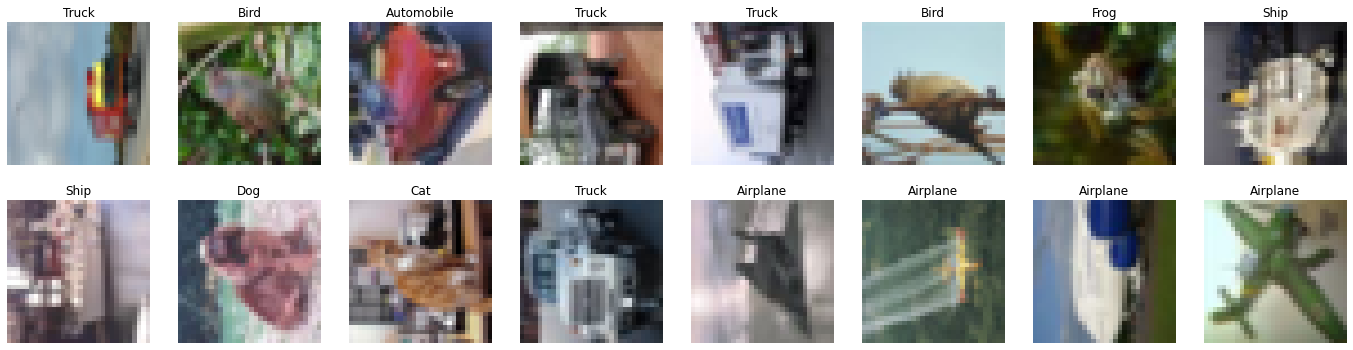

In [2]:
label_dict = {0: 'Airplane', 1: 'Automobile', 2: 'Bird', 3: 'Cat',
              4: 'Deer', 5: 'Dog', 6: 'Frog', 7: 'Horse', 8: 'Ship', 9: 'Truck'}

client_test = ClientPreprocessTest()
data, target = next(iter(client_test[0]))
label_count = (torch.unique(target, return_counts=True))
print('digits\tcount')
for label, count in zip(label_count[0], label_count[1]):
    print(label_dict[int(label)], ':\t', int(count), sep='')
print(data.shape)
fig = plt.figure(figsize=(24, 6))
for i in range(len(target)):
    fig.add_subplot(2, 8, (i+1))
    plt.imshow(data[i].T)
    plt.axis('off')
    plt.title(label_dict[int(target[i])])


In [3]:
global_model = model
print(global_model)

CNN(
  (net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=2048, out_features=1024, bias=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=1024, out_features=512, bias=True)
    (9): ReLU(inplace=True)
    (10): Linear(in_features=512, out_features=10, bias=True)
  )
)


# FedAvg Implemntation for CIFAR NON-IID

In [4]:
global_trainer = GlobalTrainer(global_model, fed_learn_method = 'fedavg')

Files already downloaded and verified


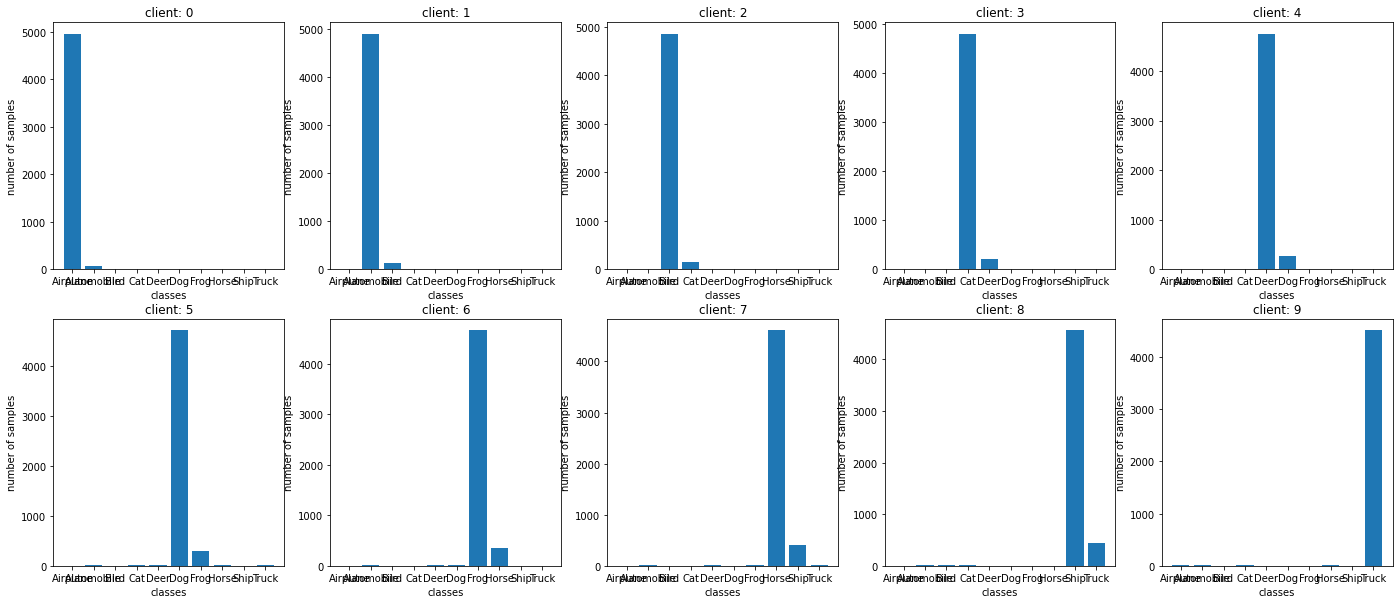

In [5]:
fig = plt.figure(figsize=(24, 10))
for i in range(n_clients):
    fig.add_subplot(2, int(n_clients/2), (i+1))
    distribution = data_label_distribution(global_trainer.trainset[i])
    plt.bar([label_dict[i] for i in distribution.keys()], distribution.values())
    plt.title(f'client: {i}')
    plt.xlabel('classes')
    plt.ylabel('number of samples')


In [6]:
global_trainer.train()

global_training_epoch:   0%|          | 1/250 [00:02<11:32,  2.78s/it]

0


global_training_epoch:   1%|          | 2/250 [00:05<10:18,  2.50s/it]

0


global_training_epoch:   1%|          | 3/250 [00:07<10:19,  2.51s/it]

0


global_training_epoch:   2%|▏         | 4/250 [00:09<09:59,  2.44s/it]

0


global_training_epoch:   2%|▏         | 5/250 [00:12<10:04,  2.47s/it]

0


global_training_epoch:   2%|▏         | 6/250 [00:15<10:11,  2.51s/it]

0


global_training_epoch:   3%|▎         | 7/250 [00:18<10:49,  2.67s/it]

0


global_training_epoch:   3%|▎         | 8/250 [00:20<10:44,  2.66s/it]

0


global_training_epoch:   4%|▎         | 9/250 [00:23<10:21,  2.58s/it]

0


global_training_epoch:   4%|▍         | 10/250 [00:25<10:01,  2.51s/it]

0


global_training_epoch:   4%|▍         | 11/250 [00:27<09:48,  2.46s/it]

0


global_training_epoch:   5%|▍         | 12/250 [00:30<09:35,  2.42s/it]

0


global_training_epoch:   5%|▌         | 13/250 [00:32<09:28,  2.40s/it]

0


global_training_epoch:   6%|▌         | 14/250 [00:34<09:17,  2.36s/it]

0


global_training_epoch:   6%|▌         | 15/250 [00:37<09:32,  2.44s/it]

0


global_training_epoch:   6%|▋         | 16/250 [00:39<09:25,  2.42s/it]

0


global_training_epoch:   7%|▋         | 17/250 [00:42<09:43,  2.51s/it]

0


global_training_epoch:   7%|▋         | 18/250 [00:44<09:37,  2.49s/it]

0


global_training_epoch:   8%|▊         | 19/250 [00:48<10:23,  2.70s/it]

0


global_training_epoch:   8%|▊         | 20/250 [00:51<10:50,  2.83s/it]

0


global_training_epoch:   8%|▊         | 21/250 [00:53<10:21,  2.71s/it]

0


global_training_epoch:   9%|▉         | 22/250 [00:56<09:59,  2.63s/it]

0


global_training_epoch:   9%|▉         | 23/250 [00:58<09:42,  2.57s/it]

0


global_training_epoch:  10%|▉         | 24/250 [01:00<09:24,  2.50s/it]

0


global_training_epoch:  10%|█         | 25/250 [01:03<09:09,  2.44s/it]

0


global_training_epoch:  10%|█         | 26/250 [01:05<09:00,  2.41s/it]

0


global_training_epoch:  11%|█         | 27/250 [01:07<08:52,  2.39s/it]

0


global_training_epoch:  11%|█         | 28/250 [01:10<08:44,  2.36s/it]

0


global_training_epoch:  12%|█▏        | 29/250 [01:13<09:20,  2.53s/it]

0


global_training_epoch:  12%|█▏        | 30/250 [01:15<09:05,  2.48s/it]

0


global_training_epoch:  12%|█▏        | 31/250 [01:17<08:57,  2.45s/it]

0


global_training_epoch:  13%|█▎        | 32/250 [01:20<08:57,  2.47s/it]

0


global_training_epoch:  13%|█▎        | 33/250 [01:22<08:58,  2.48s/it]

0


global_training_epoch:  14%|█▎        | 34/250 [01:25<08:59,  2.50s/it]

0


global_training_epoch:  14%|█▍        | 35/250 [01:27<08:54,  2.49s/it]

0


global_training_epoch:  14%|█▍        | 36/250 [01:30<08:58,  2.52s/it]

0


global_training_epoch:  15%|█▍        | 37/250 [01:32<08:45,  2.47s/it]

0


global_training_epoch:  15%|█▌        | 38/250 [01:35<08:39,  2.45s/it]

0


global_training_epoch:  16%|█▌        | 39/250 [01:37<08:30,  2.42s/it]

0


global_training_epoch:  16%|█▌        | 40/250 [01:39<08:21,  2.39s/it]

0


global_training_epoch:  16%|█▋        | 41/250 [01:42<08:20,  2.40s/it]

0


global_training_epoch:  17%|█▋        | 42/250 [01:44<08:14,  2.38s/it]

0


global_training_epoch:  17%|█▋        | 43/250 [01:46<08:08,  2.36s/it]

0


global_training_epoch:  18%|█▊        | 44/250 [01:49<08:05,  2.36s/it]

0


global_training_epoch:  18%|█▊        | 45/250 [01:52<08:59,  2.63s/it]

0


global_training_epoch:  18%|█▊        | 46/250 [01:54<08:42,  2.56s/it]

0


global_training_epoch:  19%|█▉        | 47/250 [01:57<08:31,  2.52s/it]

0


global_training_epoch:  19%|█▉        | 48/250 [01:59<08:23,  2.49s/it]

0


global_training_epoch:  20%|█▉        | 49/250 [02:02<08:11,  2.45s/it]

0


global_training_epoch:  20%|██        | 50/250 [02:04<08:07,  2.44s/it]

0


global_training_epoch:  20%|██        | 51/250 [02:06<07:58,  2.40s/it]

0


global_training_epoch:  21%|██        | 52/250 [02:09<07:52,  2.39s/it]

0


global_training_epoch:  21%|██        | 53/250 [02:11<07:47,  2.37s/it]

0


global_training_epoch:  22%|██▏       | 54/250 [02:13<07:42,  2.36s/it]

0


global_training_epoch:  22%|██▏       | 55/250 [02:16<07:44,  2.38s/it]

0


global_training_epoch:  22%|██▏       | 56/250 [02:18<07:39,  2.37s/it]

0


global_training_epoch:  23%|██▎       | 57/250 [02:20<07:35,  2.36s/it]

0


global_training_epoch:  23%|██▎       | 58/250 [02:23<07:30,  2.35s/it]

0


global_training_epoch:  24%|██▎       | 59/250 [02:25<07:27,  2.34s/it]

0


global_training_epoch:  24%|██▍       | 60/250 [02:27<07:26,  2.35s/it]

0


global_training_epoch:  24%|██▍       | 61/250 [02:30<07:24,  2.35s/it]

0


global_training_epoch:  25%|██▍       | 62/250 [02:32<07:22,  2.35s/it]

0


global_training_epoch:  25%|██▌       | 63/250 [02:35<07:20,  2.36s/it]

0


global_training_epoch:  26%|██▌       | 64/250 [02:37<07:16,  2.35s/it]

0


global_training_epoch:  26%|██▌       | 65/250 [02:39<07:19,  2.37s/it]

0


global_training_epoch:  26%|██▋       | 66/250 [02:42<07:15,  2.36s/it]

0


global_training_epoch:  27%|██▋       | 67/250 [02:44<07:11,  2.36s/it]

0


global_training_epoch:  27%|██▋       | 68/250 [02:46<07:07,  2.35s/it]

0


global_training_epoch:  28%|██▊       | 69/250 [02:49<07:04,  2.35s/it]

0


global_training_epoch:  28%|██▊       | 70/250 [02:51<07:03,  2.35s/it]

0


global_training_epoch:  28%|██▊       | 71/250 [02:53<07:03,  2.37s/it]

0


global_training_epoch:  29%|██▉       | 72/250 [02:56<07:01,  2.37s/it]

0


global_training_epoch:  29%|██▉       | 73/250 [02:58<06:59,  2.37s/it]

0


global_training_epoch:  30%|██▉       | 74/250 [03:01<06:56,  2.37s/it]

0


global_training_epoch:  30%|███       | 75/250 [03:03<06:52,  2.36s/it]

0


global_training_epoch:  30%|███       | 76/250 [03:05<06:54,  2.38s/it]

0


global_training_epoch:  31%|███       | 77/250 [03:08<06:49,  2.37s/it]

0


global_training_epoch:  31%|███       | 78/250 [03:10<06:47,  2.37s/it]

0


global_training_epoch:  32%|███▏      | 79/250 [03:12<06:43,  2.36s/it]

0


global_training_epoch:  32%|███▏      | 80/250 [03:15<06:40,  2.35s/it]

0


global_training_epoch:  32%|███▏      | 81/250 [03:17<06:41,  2.38s/it]

0


global_training_epoch:  33%|███▎      | 82/250 [03:20<06:42,  2.40s/it]

0


global_training_epoch:  33%|███▎      | 83/250 [03:23<07:46,  2.80s/it]

0


global_training_epoch:  34%|███▎      | 84/250 [03:26<07:35,  2.74s/it]

0


global_training_epoch:  34%|███▍      | 85/250 [03:28<07:19,  2.67s/it]

0


global_training_epoch:  34%|███▍      | 86/250 [03:31<07:06,  2.60s/it]

0


global_training_epoch:  35%|███▍      | 87/250 [03:33<06:53,  2.54s/it]

0


global_training_epoch:  35%|███▌      | 88/250 [03:36<06:48,  2.52s/it]

0


global_training_epoch:  36%|███▌      | 89/250 [03:38<06:39,  2.48s/it]

0


global_training_epoch:  36%|███▌      | 90/250 [03:41<06:32,  2.46s/it]

0


global_training_epoch:  36%|███▋      | 91/250 [03:43<06:25,  2.42s/it]

0


global_training_epoch:  37%|███▋      | 92/250 [03:45<06:19,  2.40s/it]

0


global_training_epoch:  37%|███▋      | 93/250 [03:48<06:17,  2.41s/it]

0


global_training_epoch:  38%|███▊      | 94/250 [03:50<06:18,  2.43s/it]

0


global_training_epoch:  38%|███▊      | 95/250 [03:53<06:15,  2.42s/it]

0


global_training_epoch:  38%|███▊      | 96/250 [03:55<06:10,  2.40s/it]

0


global_training_epoch:  39%|███▉      | 97/250 [03:57<06:05,  2.39s/it]

0


global_training_epoch:  39%|███▉      | 98/250 [04:00<06:04,  2.40s/it]

0


global_training_epoch:  40%|███▉      | 99/250 [04:02<06:11,  2.46s/it]

0


global_training_epoch:  40%|████      | 100/250 [04:05<06:04,  2.43s/it]

0


global_training_epoch:  40%|████      | 101/250 [04:07<05:58,  2.41s/it]

0


global_training_epoch:  41%|████      | 102/250 [04:09<05:54,  2.39s/it]

0


global_training_epoch:  41%|████      | 103/250 [04:12<05:55,  2.42s/it]

0


global_training_epoch:  42%|████▏     | 104/250 [04:14<05:57,  2.45s/it]

0


global_training_epoch:  42%|████▏     | 105/250 [04:17<05:53,  2.44s/it]

0


global_training_epoch:  42%|████▏     | 106/250 [04:19<05:48,  2.42s/it]

0


global_training_epoch:  43%|████▎     | 107/250 [04:21<05:44,  2.41s/it]

0


global_training_epoch:  43%|████▎     | 108/250 [04:24<05:42,  2.41s/it]

0


global_training_epoch:  44%|████▎     | 109/250 [04:26<05:35,  2.38s/it]

0


global_training_epoch:  44%|████▍     | 110/250 [04:29<05:33,  2.38s/it]

0


global_training_epoch:  44%|████▍     | 111/250 [04:31<05:30,  2.38s/it]

0


global_training_epoch:  45%|████▍     | 112/250 [04:33<05:26,  2.36s/it]

0


global_training_epoch:  45%|████▌     | 113/250 [04:36<05:25,  2.37s/it]

0


global_training_epoch:  46%|████▌     | 114/250 [04:38<05:21,  2.36s/it]

0


global_training_epoch:  46%|████▌     | 115/250 [04:40<05:20,  2.37s/it]

0


global_training_epoch:  46%|████▋     | 116/250 [04:43<05:40,  2.54s/it]

0


global_training_epoch:  47%|████▋     | 117/250 [04:47<06:08,  2.77s/it]

0


global_training_epoch:  47%|████▋     | 118/250 [04:50<06:29,  2.95s/it]

0


global_training_epoch:  48%|████▊     | 119/250 [04:54<06:51,  3.14s/it]

0


global_training_epoch:  48%|████▊     | 120/250 [04:56<06:22,  2.95s/it]

0


global_training_epoch:  48%|████▊     | 121/250 [04:59<06:00,  2.79s/it]

0


global_training_epoch:  49%|████▉     | 122/250 [05:01<05:41,  2.67s/it]

0


global_training_epoch:  49%|████▉     | 123/250 [05:03<05:31,  2.61s/it]

0


global_training_epoch:  50%|████▉     | 124/250 [05:06<05:21,  2.55s/it]

0


global_training_epoch:  50%|█████     | 125/250 [05:08<05:16,  2.54s/it]

0


global_training_epoch:  50%|█████     | 126/250 [05:11<05:07,  2.48s/it]

0


global_training_epoch:  51%|█████     | 127/250 [05:14<05:17,  2.58s/it]

0


global_training_epoch:  51%|█████     | 128/250 [05:16<05:25,  2.66s/it]

0


global_training_epoch:  52%|█████▏    | 129/250 [05:19<05:19,  2.64s/it]

0


global_training_epoch:  52%|█████▏    | 130/250 [05:21<05:13,  2.61s/it]

0


global_training_epoch:  52%|█████▏    | 131/250 [05:24<05:04,  2.56s/it]

0


global_training_epoch:  53%|█████▎    | 132/250 [05:26<05:00,  2.55s/it]

0


global_training_epoch:  53%|█████▎    | 133/250 [05:29<04:52,  2.50s/it]

0


global_training_epoch:  54%|█████▎    | 134/250 [05:31<04:46,  2.47s/it]

0


global_training_epoch:  54%|█████▍    | 135/250 [05:34<04:46,  2.49s/it]

0


global_training_epoch:  54%|█████▍    | 136/250 [05:36<04:41,  2.47s/it]

0


global_training_epoch:  55%|█████▍    | 137/250 [05:39<04:36,  2.45s/it]

0


global_training_epoch:  55%|█████▌    | 138/250 [05:41<04:37,  2.48s/it]

0


global_training_epoch:  56%|█████▌    | 139/250 [05:44<04:48,  2.60s/it]

0


global_training_epoch:  56%|█████▌    | 140/250 [05:47<04:55,  2.69s/it]

0


global_training_epoch:  56%|█████▋    | 141/250 [05:50<05:10,  2.85s/it]

0


global_training_epoch:  57%|█████▋    | 142/250 [05:53<05:20,  2.96s/it]

0


global_training_epoch:  57%|█████▋    | 143/250 [05:57<05:41,  3.19s/it]

0


global_training_epoch:  58%|█████▊    | 144/250 [06:01<05:47,  3.28s/it]

0


global_training_epoch:  58%|█████▊    | 145/250 [06:03<05:21,  3.06s/it]

0


global_training_epoch:  58%|█████▊    | 146/250 [06:06<05:02,  2.91s/it]

0


global_training_epoch:  59%|█████▉    | 147/250 [06:08<04:51,  2.83s/it]

0


global_training_epoch:  59%|█████▉    | 148/250 [06:11<04:38,  2.73s/it]

0


global_training_epoch:  60%|█████▉    | 149/250 [06:13<04:30,  2.68s/it]

0


global_training_epoch:  60%|██████    | 150/250 [06:16<04:22,  2.62s/it]

0


global_training_epoch:  60%|██████    | 151/250 [06:18<04:14,  2.57s/it]

0


global_training_epoch:  61%|██████    | 152/250 [06:21<04:13,  2.58s/it]

0


global_training_epoch:  61%|██████    | 153/250 [06:23<04:06,  2.54s/it]

0


global_training_epoch:  62%|██████▏   | 154/250 [06:26<04:01,  2.52s/it]

0


global_training_epoch:  62%|██████▏   | 155/250 [06:28<03:59,  2.53s/it]

0


global_training_epoch:  62%|██████▏   | 156/250 [06:31<03:55,  2.50s/it]

0


global_training_epoch:  63%|██████▎   | 157/250 [06:33<03:57,  2.55s/it]

0


global_training_epoch:  63%|██████▎   | 158/250 [06:37<04:18,  2.82s/it]

0


global_training_epoch:  64%|██████▎   | 159/250 [06:41<04:41,  3.09s/it]

0


global_training_epoch:  64%|██████▍   | 160/250 [06:44<04:52,  3.24s/it]

0


global_training_epoch:  64%|██████▍   | 161/250 [06:47<04:28,  3.02s/it]

0


global_training_epoch:  65%|██████▍   | 162/250 [06:49<04:12,  2.87s/it]

0


global_training_epoch:  65%|██████▌   | 163/250 [06:52<03:59,  2.76s/it]

0


global_training_epoch:  66%|██████▌   | 164/250 [06:54<03:48,  2.65s/it]

0


global_training_epoch:  66%|██████▌   | 165/250 [06:57<03:45,  2.66s/it]

0


global_training_epoch:  66%|██████▋   | 166/250 [06:59<03:39,  2.62s/it]

0


global_training_epoch:  67%|██████▋   | 167/250 [07:02<03:35,  2.60s/it]

0


global_training_epoch:  67%|██████▋   | 168/250 [07:05<03:33,  2.61s/it]

0


global_training_epoch:  68%|██████▊   | 169/250 [07:07<03:34,  2.64s/it]

0


global_training_epoch:  68%|██████▊   | 170/250 [07:10<03:27,  2.60s/it]

0


global_training_epoch:  68%|██████▊   | 171/250 [07:12<03:25,  2.60s/it]

0


global_training_epoch:  69%|██████▉   | 172/250 [07:15<03:20,  2.57s/it]

0


global_training_epoch:  69%|██████▉   | 173/250 [07:17<03:14,  2.52s/it]

0


global_training_epoch:  70%|██████▉   | 174/250 [07:20<03:10,  2.50s/it]

0


global_training_epoch:  70%|███████   | 175/250 [07:22<03:07,  2.50s/it]

0


global_training_epoch:  70%|███████   | 176/250 [07:25<03:06,  2.52s/it]

0


global_training_epoch:  71%|███████   | 177/250 [07:27<03:01,  2.49s/it]

0


global_training_epoch:  71%|███████   | 178/250 [07:30<02:57,  2.47s/it]

0


global_training_epoch:  72%|███████▏  | 179/250 [07:32<02:55,  2.47s/it]

0


global_training_epoch:  72%|███████▏  | 180/250 [07:35<02:51,  2.46s/it]

0


global_training_epoch:  72%|███████▏  | 181/250 [07:37<02:47,  2.43s/it]

0


global_training_epoch:  73%|███████▎  | 182/250 [07:39<02:44,  2.42s/it]

0


global_training_epoch:  73%|███████▎  | 183/250 [07:42<02:42,  2.43s/it]

0


global_training_epoch:  74%|███████▎  | 184/250 [07:44<02:40,  2.43s/it]

0


global_training_epoch:  74%|███████▍  | 185/250 [07:47<02:37,  2.42s/it]

0


global_training_epoch:  74%|███████▍  | 186/250 [07:49<02:34,  2.41s/it]

0


global_training_epoch:  75%|███████▍  | 187/250 [07:51<02:32,  2.42s/it]

0


global_training_epoch:  75%|███████▌  | 188/250 [07:54<02:29,  2.41s/it]

0


global_training_epoch:  76%|███████▌  | 189/250 [07:56<02:28,  2.43s/it]

0


global_training_epoch:  76%|███████▌  | 190/250 [07:59<02:26,  2.44s/it]

0


global_training_epoch:  76%|███████▋  | 191/250 [08:01<02:22,  2.42s/it]

0


global_training_epoch:  77%|███████▋  | 192/250 [08:03<02:19,  2.41s/it]

0


global_training_epoch:  77%|███████▋  | 193/250 [08:06<02:16,  2.39s/it]

0


global_training_epoch:  78%|███████▊  | 194/250 [08:08<02:17,  2.46s/it]

0


global_training_epoch:  78%|███████▊  | 195/250 [08:12<02:36,  2.84s/it]

0


global_training_epoch:  78%|███████▊  | 196/250 [08:15<02:33,  2.83s/it]

0


global_training_epoch:  79%|███████▉  | 197/250 [08:17<02:23,  2.72s/it]

0


global_training_epoch:  79%|███████▉  | 198/250 [08:20<02:17,  2.64s/it]

0


global_training_epoch:  80%|███████▉  | 199/250 [08:22<02:12,  2.61s/it]

0


global_training_epoch:  80%|████████  | 200/250 [08:25<02:08,  2.57s/it]

0


global_training_epoch:  80%|████████  | 201/250 [08:27<02:03,  2.52s/it]

0


global_training_epoch:  81%|████████  | 202/250 [08:30<01:59,  2.50s/it]

0


global_training_epoch:  81%|████████  | 203/250 [08:32<01:56,  2.47s/it]

0


global_training_epoch:  82%|████████▏ | 204/250 [08:35<01:53,  2.46s/it]

0


global_training_epoch:  82%|████████▏ | 205/250 [08:37<01:50,  2.46s/it]

0


global_training_epoch:  82%|████████▏ | 206/250 [08:40<01:50,  2.51s/it]

0


global_training_epoch:  83%|████████▎ | 207/250 [08:43<01:55,  2.68s/it]

0


global_training_epoch:  83%|████████▎ | 208/250 [08:45<01:50,  2.63s/it]

0


global_training_epoch:  84%|████████▎ | 209/250 [08:48<01:46,  2.60s/it]

0


global_training_epoch:  84%|████████▍ | 210/250 [08:51<01:46,  2.66s/it]

0


global_training_epoch:  84%|████████▍ | 211/250 [08:53<01:41,  2.59s/it]

0


global_training_epoch:  85%|████████▍ | 212/250 [08:55<01:36,  2.54s/it]

0


global_training_epoch:  85%|████████▌ | 213/250 [08:59<01:46,  2.89s/it]

0


global_training_epoch:  86%|████████▌ | 214/250 [09:03<01:50,  3.07s/it]

0


global_training_epoch:  86%|████████▌ | 215/250 [09:06<01:52,  3.21s/it]

0


global_training_epoch:  86%|████████▋ | 216/250 [09:09<01:46,  3.13s/it]

0


global_training_epoch:  87%|████████▋ | 217/250 [09:12<01:36,  2.93s/it]

0


global_training_epoch:  87%|████████▋ | 218/250 [09:14<01:29,  2.79s/it]

0


global_training_epoch:  88%|████████▊ | 219/250 [09:17<01:23,  2.68s/it]

0


global_training_epoch:  88%|████████▊ | 220/250 [09:20<01:24,  2.80s/it]

0


global_training_epoch:  88%|████████▊ | 221/250 [09:23<01:22,  2.84s/it]

0


global_training_epoch:  89%|████████▉ | 222/250 [09:25<01:18,  2.79s/it]

0


global_training_epoch:  89%|████████▉ | 223/250 [09:28<01:13,  2.71s/it]

0


global_training_epoch:  90%|████████▉ | 224/250 [09:30<01:10,  2.70s/it]

0


global_training_epoch:  90%|█████████ | 225/250 [09:33<01:06,  2.64s/it]

0


global_training_epoch:  90%|█████████ | 226/250 [09:36<01:03,  2.63s/it]

0


global_training_epoch:  91%|█████████ | 227/250 [09:38<01:00,  2.65s/it]

0


global_training_epoch:  91%|█████████ | 228/250 [09:41<00:57,  2.60s/it]

0


global_training_epoch:  92%|█████████▏| 229/250 [09:43<00:53,  2.56s/it]

0


global_training_epoch:  92%|█████████▏| 230/250 [09:46<00:50,  2.53s/it]

0


global_training_epoch:  92%|█████████▏| 231/250 [09:48<00:47,  2.52s/it]

0


global_training_epoch:  93%|█████████▎| 232/250 [09:51<00:47,  2.63s/it]

0


global_training_epoch:  93%|█████████▎| 233/250 [09:54<00:44,  2.60s/it]

0


global_training_epoch:  94%|█████████▎| 234/250 [09:56<00:41,  2.58s/it]

0


global_training_epoch:  94%|█████████▍| 235/250 [09:59<00:39,  2.61s/it]

0


global_training_epoch:  94%|█████████▍| 236/250 [10:01<00:36,  2.59s/it]

0


global_training_epoch:  95%|█████████▍| 237/250 [10:04<00:33,  2.59s/it]

0


global_training_epoch:  95%|█████████▌| 238/250 [10:07<00:31,  2.65s/it]

0


global_training_epoch:  96%|█████████▌| 239/250 [10:09<00:28,  2.63s/it]

0


global_training_epoch:  96%|█████████▌| 240/250 [10:12<00:25,  2.59s/it]

0


global_training_epoch:  96%|█████████▋| 241/250 [10:14<00:22,  2.54s/it]

0


global_training_epoch:  97%|█████████▋| 242/250 [10:17<00:20,  2.51s/it]

0


global_training_epoch:  97%|█████████▋| 243/250 [10:19<00:18,  2.61s/it]

0


global_training_epoch:  98%|█████████▊| 244/250 [10:22<00:15,  2.65s/it]

0


global_training_epoch:  98%|█████████▊| 245/250 [10:25<00:13,  2.62s/it]

0


global_training_epoch:  98%|█████████▊| 246/250 [10:27<00:10,  2.58s/it]

0


global_training_epoch:  99%|█████████▉| 247/250 [10:30<00:07,  2.61s/it]

0


global_training_epoch:  99%|█████████▉| 248/250 [10:33<00:05,  2.61s/it]

0


global_training_epoch: 100%|█████████▉| 249/250 [10:35<00:02,  2.61s/it]

0


global_training_epoch: 100%|██████████| 250/250 [10:38<00:00,  2.55s/it]

0


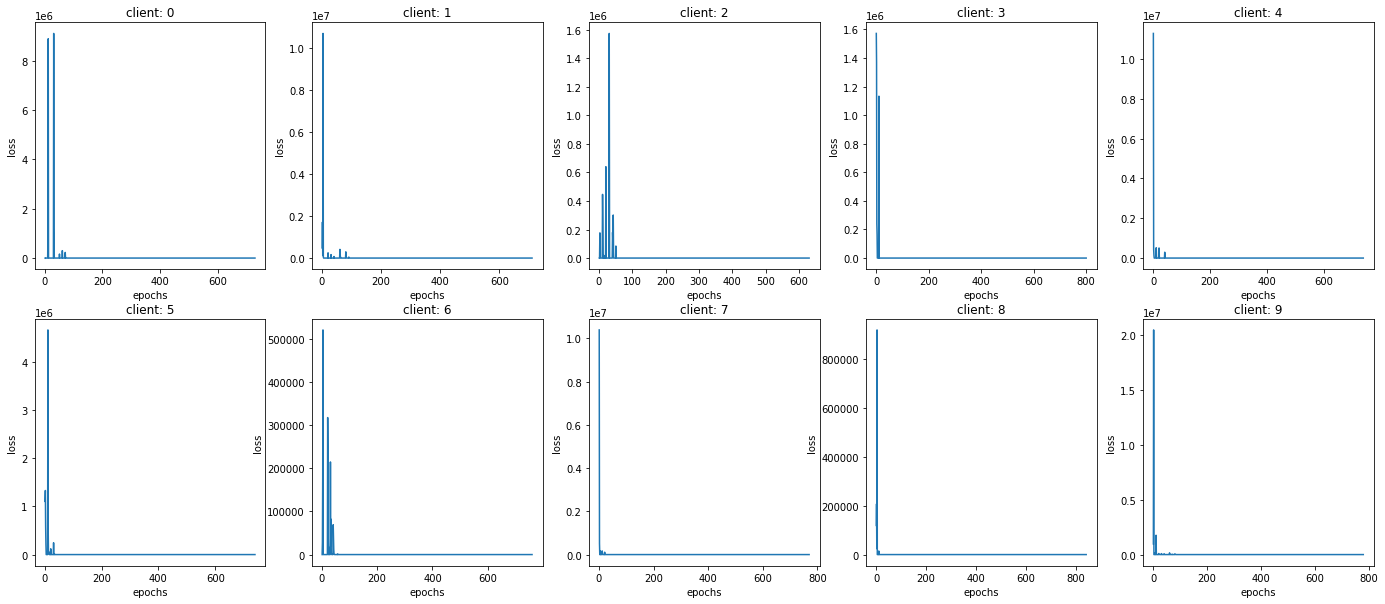

In [7]:
fig = plt.figure(figsize=(24, 10))
for i in range(n_clients):
    fig.add_subplot(2, int(n_clients/2), (i+1))
    X = global_trainer.client_trainer_set[i].loss_history
    Y = [i+1 for i in range(len(X))]
    plt.plot(Y, X)
    plt.title(f'client: {i}')
    plt.xlabel('epochs')
    plt.ylabel('loss')

In [8]:
global_test = GlobalPreprocess()

client_evaluator_set = [ClientEvaluator(i, global_model, client_test[i]) for i in range(n_clients)]
global_evaluator = GlobalEvaluator(global_model, global_test)

Files already downloaded and verified


In [9]:
avg_client_acc = 0
avg_client_loss = 0
avg_client_conf_mat = torch.zeros([10, 10])  
  
for i in range(n_clients):
    client_evaluator_set[i].test()
    avg_client_acc += client_evaluator_set[i].accuracy
    avg_client_loss += client_evaluator_set[i].loss
    print(type(client_evaluator_set[i].conf_mat), type(avg_client_conf_mat))
    avg_client_conf_mat = torch.add(avg_client_conf_mat, client_evaluator_set[i].conf_mat)
    
avg_client_acc /= n_clients
avg_client_loss /= n_clients
avg_client_conf_mat  = torch.div(avg_client_conf_mat, n_clients)
    

client [0]: 100%|██████████| 66/66 [00:01<00:00, 62.53it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [1]: 100%|██████████| 66/66 [00:01<00:00, 50.26it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [2]: 100%|██████████| 66/66 [00:01<00:00, 50.83it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [3]: 100%|██████████| 66/66 [00:01<00:00, 49.35it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [4]: 100%|██████████| 66/66 [00:01<00:00, 47.49it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [5]: 100%|██████████| 66/66 [00:01<00:00, 43.92it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [6]: 100%|██████████| 66/66 [00:01<00:00, 43.29it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [7]: 100%|██████████| 66/66 [00:01<00:00, 59.79it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [8]: 100%|██████████| 66/66 [00:01<00:00, 45.61it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [9]: 100%|██████████| 35/35 [00:00<00:00, 43.39it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'>


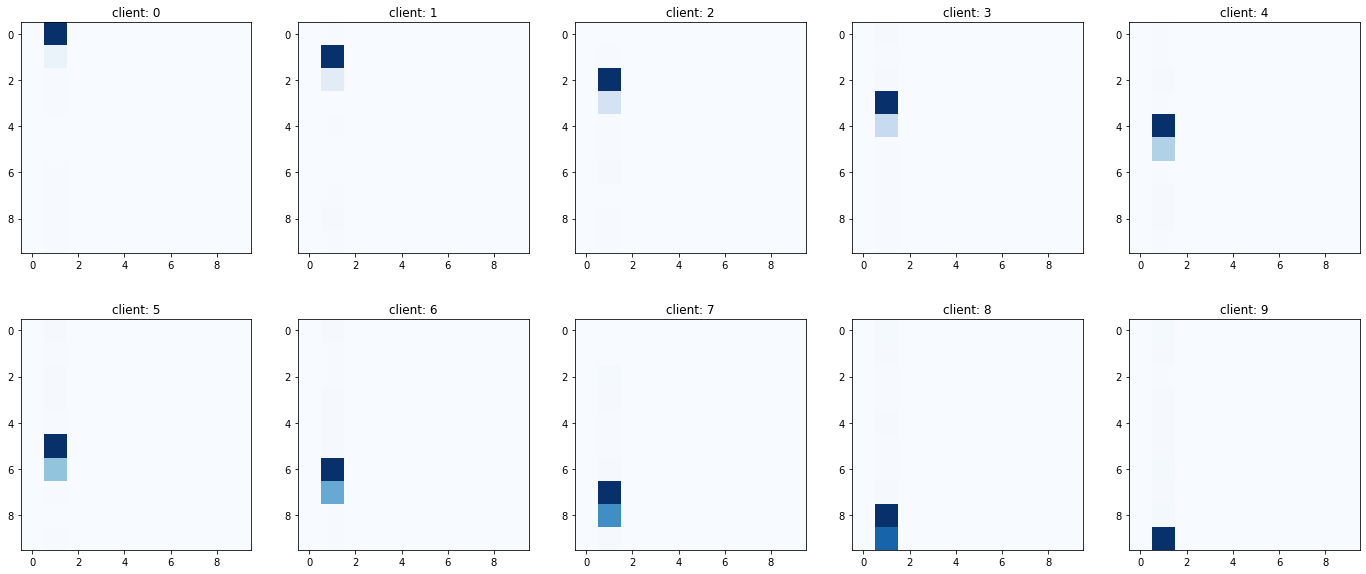

In [10]:
fig = plt.figure(figsize=(24, 10))
for i in range(n_clients):
    fig.add_subplot(2, int(n_clients/2), (i+1))
    plt.imshow(client_evaluator_set[i].conf_mat, cmap='Blues')
    plt.title(f'client: {i}')


<BarContainer object of 10 artists>

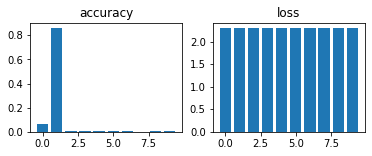

In [11]:
fig = plt.figure(figsize=(6, 2))
fig.add_subplot(1, 2, 1)
plt.bar([i for i in range(n_clients)], [client_evaluator_set[i].accuracy for i in range(n_clients)])
plt.title('accuracy')
fig.add_subplot(1, 2, 2)
plt.title('loss')   
plt.bar([i for i in range(n_clients)], [client_evaluator_set[i].loss for i in range(n_clients)])


In [12]:
global_evaluator.test()

global_evaluation: 100%|██████████| 157/157 [00:09<00:00, 16.50it/s]


Text(0.5, 1.0, 'clieint average')

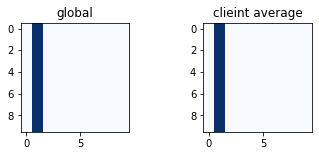

In [13]:
fig = plt.figure(figsize=(6, 2))
fig.add_subplot(1, 2, 1)
plt.imshow(global_evaluator.conf_mat, cmap='Blues')
plt.title('global')
fig.add_subplot(1, 2, 2)
plt.imshow(avg_client_conf_mat, cmap='Blues')
plt.title('clieint average')


In [14]:
print('Global Accuracy', global_evaluator.accuracy, '\tClient avg Accuracy', avg_client_acc)
print('Global Loss' , global_evaluator.loss, '\tClient avg Loss', avg_client_loss)

Global Accuracy 0.09982085987261147 	Client avg Accuracy 0.09560064935064935
Global Loss 2.30258509299404 	Client avg Loss 2.302585092994046


# FedAvgM Implementation for CIFAR Non_IID

In [15]:
global_trainer = GlobalTrainer(global_model, fed_learn_method = 'fedavgM')

Files already downloaded and verified


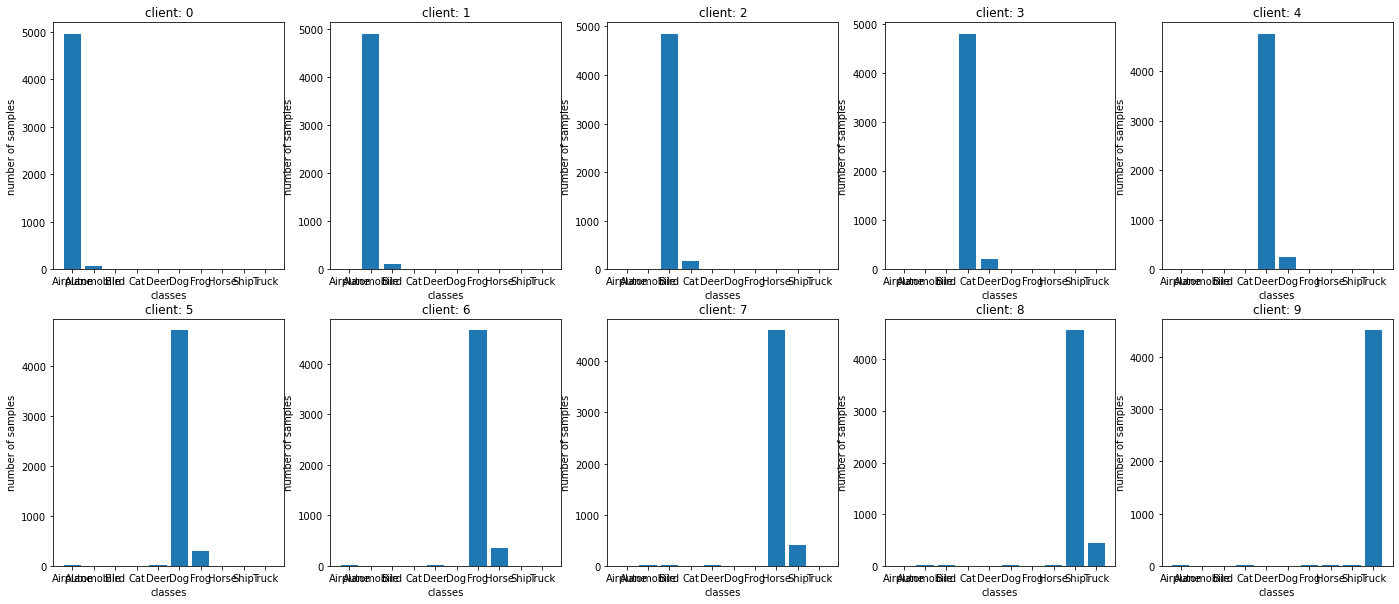

In [16]:
fig = plt.figure(figsize=(24, 10))
for i in range(n_clients):
    fig.add_subplot(2, int(n_clients/2), (i+1))
    distribution = data_label_distribution(global_trainer.trainset[i])
    plt.bar([label_dict[i] for i in distribution.keys()], distribution.values())
    plt.title(f'client: {i}')
    plt.xlabel('classes')
    plt.ylabel('number of samples')


In [17]:
global_trainer.train()

global_training_epoch:   0%|          | 1/250 [00:02<10:05,  2.43s/it]

3
[tensor([ -0.0880,   0.1741,   0.1854,  ..., -76.2268, -76.4553, -76.2873]), tensor([ -0.0880,   0.1741,   0.1854,  ..., -76.1803, -76.4657, -76.2656]), tensor([ -0.0880,   0.1741,   0.1854,  ..., -76.2005, -75.6239, -76.0722])]
tensor([ -0.0880,   0.1741,   0.1854,  ..., -76.2025, -76.1816, -76.2084])


global_training_epoch:   1%|          | 2/250 [00:05<10:30,  2.54s/it]

3
[tensor([ 0.0000,  0.0000,  0.0000,  ..., -0.1724, -0.1531,  0.2230]), tensor([ 0.0000,  0.0000,  0.0000,  ...,  0.7591, -0.0293, -0.0735]), tensor([ 0.0000,  0.0000,  0.0000,  ..., -0.1912, -0.2998, -0.0953])]
tensor([ -0.0792,   0.1567,   0.1669,  ..., -68.4505, -68.7242, -68.5695])


global_training_epoch:   1%|          | 3/250 [00:07<09:52,  2.40s/it]

3
[tensor([-3.9333e-02, -2.7549e-01, -2.8543e-01,  ...,  6.8460e+01,
         6.8638e+01,  6.8696e+01]), tensor([-2.9045e-02, -2.6541e-01, -2.7518e-01,  ...,  6.8452e+01,
         6.8642e+01,  6.8721e+01]), tensor([-2.5985e-02, -2.6370e-01, -2.7308e-01,  ...,  6.8986e+01,
         6.9206e+01,  6.9294e+01])]
tensor([-0.1027, -0.1272, -0.1277,  ...,  7.0274,  6.9769,  7.1912])


global_training_epoch:   2%|▏         | 4/250 [00:09<09:57,  2.43s/it]

3
[tensor([-3.2735e-02, -2.4434e-01, -2.5393e-01,  ...,  6.1608e+01,
         6.1844e+01,  6.1686e+01]), tensor([-3.0611e-02, -2.4242e-01, -2.5229e-01,  ...,  6.1605e+01,
         6.1845e+01,  6.1696e+01]), tensor([-3.0344e-02, -2.4210e-01, -2.5168e-01,  ...,  6.1999e+01,
         6.2193e+01,  6.2051e+01])]
tensor([-0.1237, -0.3574, -0.3676,  ..., 68.0621, 68.2399, 68.2829])


global_training_epoch:   2%|▏         | 5/250 [00:12<10:20,  2.53s/it]

3
[tensor([-2.0442e-03,  1.9708e-02,  1.9789e-02,  ..., -6.3874e+00,
        -6.3275e+00, -6.5285e+00]), tensor([ 0.0673,  0.0894,  0.0899,  ..., -6.1674, -6.0735, -6.2033]), tensor([ 0.0257,  0.0480,  0.0482,  ..., -6.6485, -6.5987, -6.8046])]
tensor([-0.0810, -0.2693, -0.2782,  ..., 54.8548, 55.0827, 54.9424])


client [7]: 100%|██████████| 10/10 [00:00<00:00, 10.92it/s]


3
[tensor([  0.1033,   0.3143,   0.3238,  ..., -61.4833, -60.8571, -61.7122]), tensor([  0.1030,   0.3138,   0.3229,  ..., -61.1184, -61.3003, -61.3559]), tensor([  0.1022,   0.3131,   0.3226,  ..., -60.6871, -61.6376, -61.7183])]


global_training_epoch:   2%|▏         | 6/250 [00:15<10:34,  2.60s/it]

tensor([  0.0299,   0.0713,   0.0727,  ..., -11.7270, -11.6906, -12.1473])


global_training_epoch:   3%|▎         | 7/250 [00:18<11:30,  2.84s/it]

3
[tensor([  0.1054,   0.2750,   0.2827,  ..., -49.4412, -49.6499, -49.2522]), tensor([  0.0999,   0.2689,   0.2763,  ..., -49.4054, -49.5973, -48.9299]), tensor([  0.0968,   0.2666,   0.2748,  ..., -49.5812, -49.2384, -49.3888])]
tensor([  0.1277,   0.3344,   0.3434,  ..., -60.0302, -60.0168, -60.1228])


global_training_epoch:   3%|▎         | 8/250 [00:21<11:21,  2.82s/it]

3
[tensor([ 0.0939,  0.0562,  0.0548,  ..., 10.5412, 10.3245, 10.8262]), tensor([ 0.0849,  0.0477,  0.0467,  ..., 11.0180, 10.2376, 10.7317]), tensor([ 0.0953,  0.0580,  0.0571,  ..., 10.5151, 10.7510, 10.8005])]
tensor([  0.2062,   0.3549,   0.3619,  ..., -43.3357, -43.5774, -43.3244])


global_training_epoch:   4%|▎         | 9/250 [00:23<10:55,  2.72s/it]

3
[tensor([-4.2203e-02, -2.2832e-01, -2.3650e-01,  ...,  5.3956e+01,
         5.3975e+01,  5.4249e+01]), tensor([-1.7414e-03, -1.8338e-01, -1.9083e-01,  ...,  5.4177e+01,
         5.4129e+01,  5.4409e+01]), tensor([-0.0987, -0.2848, -0.2931,  ..., 53.7740, 53.7950, 54.0419])]
tensor([ 0.1381,  0.0872,  0.0856,  ..., 14.9669, 14.7466, 15.2412])


global_training_epoch:   4%|▍         | 10/250 [00:26<10:26,  2.61s/it]

3
[tensor([-1.1770e-02, -1.4344e-01, -1.4830e-01,  ...,  3.9008e+01,
         3.9227e+01,  3.8993e+01]), tensor([-0.2250, -0.3604, -0.3672,  ..., 38.9524, 39.2025, 39.3440]), tensor([-0.1672, -0.3025, -0.3092,  ..., 38.9204, 39.1660, 38.9201])]
tensor([-1.0417e-02, -1.9030e-01, -1.9785e-01,  ...,  5.2430e+01,
         5.2470e+01,  5.2803e+01])


global_training_epoch:   4%|▍         | 11/250 [00:29<11:11,  2.81s/it]

3
[tensor([ -0.1481,  -0.1035,  -0.1026,  ..., -13.4935, -13.4504, -13.4415]), tensor([ -0.1627,  -0.1180,  -0.1170,  ..., -13.1315, -13.4634, -13.9200]), tensor([ -0.1250,  -0.0804,  -0.0794,  ..., -13.5061, -13.5246, -13.8786])]
tensor([-0.1547, -0.2719, -0.2777,  ..., 33.8103, 33.7438, 33.7758])


global_training_epoch:   5%|▍         | 12/250 [00:32<11:11,  2.82s/it]

3
[tensor([ 2.5016e-02,  1.8689e-01,  1.9372e-01,  ..., -4.7290e+01,
        -4.7301e+01, -4.7621e+01]), tensor([ -0.0569,   0.1051,   0.1119,  ..., -47.3018, -47.2064, -47.6412]), tensor([ 3.3001e-02,  1.9487e-01,  2.0167e-01,  ..., -4.7310e+01,
        -4.7416e+01, -4.7181e+01])]
tensor([ -0.1388,  -0.0824,  -0.0809,  ..., -16.8714, -16.9386, -17.0828])


global_training_epoch:   5%|▌         | 13/250 [00:34<10:51,  2.75s/it]

3
[tensor([  0.1326,   0.2382,   0.2436,  ..., -30.4593, -29.7604, -30.5859]), tensor([  0.1589,   0.2644,   0.2698,  ..., -30.1086, -30.3147, -30.5862]), tensor([  0.1609,   0.2663,   0.2715,  ..., -30.4411, -30.3849, -30.0105])]
tensor([ 2.5868e-02,  1.8214e-01,  1.8883e-01,  ..., -4.5521e+01,
        -4.5398e+01, -4.5769e+01])


global_training_epoch:   6%|▌         | 14/250 [00:37<10:29,  2.67s/it]

3
[tensor([ 0.1176,  0.0668,  0.0654,  ..., 15.0827, 15.2042, 15.2038]), tensor([ 0.1456,  0.0948,  0.0935,  ..., 15.4764, 15.1746, 15.1930]), tensor([ 0.1531,  0.1023,  0.1009,  ..., 15.0873, 15.0233, 15.2118])]
tensor([  0.1620,   0.2519,   0.2565,  ..., -25.7530, -25.7242, -25.9889])


global_training_epoch:   6%|▌         | 15/250 [00:40<11:15,  2.87s/it]

3
[tensor([-1.7478e-02, -1.5812e-01, -1.6416e-01,  ...,  4.0833e+01,
         4.0984e+01,  4.1190e+01]), tensor([-3.0365e-03, -1.4371e-01, -1.4973e-01,  ...,  4.0835e+01,
         4.0913e+01,  4.1193e+01]), tensor([ 1.2928e-02, -1.2736e-01, -1.3129e-01,  ...,  4.1079e+01,
         4.1229e+01,  4.1476e+01])]
tensor([ 0.1433,  0.0836,  0.0825,  ..., 17.7376, 17.8904, 17.8966])


global_training_epoch:   6%|▋         | 16/250 [00:43<11:27,  2.94s/it]

3
[tensor([-0.1500, -0.2311, -0.2359,  ..., 23.0924, 22.8869, 23.2910]), tensor([-0.1899, -0.2709, -0.2759,  ..., 23.0467, 23.0805, 23.2428]), tensor([-0.1438, -0.2248, -0.2297,  ..., 23.0948, 23.0882, 23.2938])]
tensor([-3.2279e-02, -1.6699e-01, -1.7292e-01,  ...,  3.9042e+01,
         3.9120e+01,  3.9383e+01])


global_training_epoch:   7%|▋         | 17/250 [00:46<11:36,  2.99s/it]

3
[tensor([ -0.1316,  -0.0778,  -0.0767,  ..., -16.2821, -15.6595, -16.3325]), tensor([  0.0279,   0.0822,   0.0836,  ..., -16.0976, -15.9351, -16.0076]), tensor([ -0.1247,  -0.0711,  -0.0700,  ..., -16.3127, -16.1689, -15.7000])]
tensor([-0.1051, -0.1725, -0.1767,  ..., 18.9068, 19.2868, 19.4312])


global_training_epoch:   7%|▋         | 18/250 [00:49<11:33,  2.99s/it]

3
[tensor([-5.1971e-03,  1.1586e-01,  1.2111e-01,  ..., -3.5368e+01,
        -3.5372e+01, -3.5521e+01]), tensor([-2.3105e-02,  9.7949e-02,  1.0318e-01,  ..., -3.5260e+01,
        -3.5415e+01, -3.5541e+01]), tensor([ -0.0851,   0.0356,   0.0409,  ..., -35.2879, -35.3217, -35.5625])]
tensor([ -0.1324,  -0.0721,  -0.0706,  ..., -18.2893, -18.0116, -18.0535])


global_training_epoch:   8%|▊         | 19/250 [00:52<10:59,  2.86s/it]

3
[tensor([  0.1212,   0.1819,   0.1857,  ..., -17.2531, -17.3561, -17.4688]), tensor([  0.1193,   0.1800,   0.1837,  ..., -17.2498, -17.3328, -17.0634]), tensor([  0.0463,   0.1069,   0.1098,  ..., -16.9618, -17.2447, -17.4366])]
tensor([-2.3581e-02,  9.1384e-02,  9.6180e-02,  ..., -3.3615e+01,
        -3.3522e+01, -3.3571e+01])


global_training_epoch:   8%|▊         | 20/250 [00:54<10:34,  2.76s/it]

3
[tensor([ 0.1426,  0.0884,  0.0874,  ..., 17.3402, 16.2099, 16.1001]), tensor([ 0.1018,  0.0476,  0.0465,  ..., 16.4166, 16.1054, 16.1029]), tensor([ 0.0946,  0.0407,  0.0398,  ..., 16.3892, 16.0931, 16.0954])]
tensor([  0.0918,   0.1412,   0.1444,  ..., -13.5385, -14.0334, -14.1145])


global_training_epoch:   8%|▊         | 21/250 [00:57<10:05,  2.64s/it]

3
[tensor([ 0.0325, -0.0709, -0.0752,  ..., 29.7688, 30.2280, 30.2144]), tensor([ 0.0557, -0.0479, -0.0522,  ..., 29.7913, 30.2557, 30.2170]), tensor([ 0.0560, -0.0476, -0.0519,  ..., 30.6970, 30.2719, 30.2162])]
tensor([ 0.1307,  0.0716,  0.0702,  ..., 17.9011, 17.6218, 17.5128])


global_training_epoch:   9%|▉         | 22/250 [00:59<09:48,  2.58s/it]

3
[tensor([-0.0458, -0.0899, -0.0924,  ..., 12.4445, 12.6868, 12.7293]), tensor([-0.0940, -0.1384, -0.1415,  ..., 12.1745, 12.6113, 12.7044]), tensor([-0.0785, -0.1230, -0.1260,  ..., 12.2401, 12.6539, 12.7049])]
tensor([ 0.0448, -0.0527, -0.0567,  ..., 28.3973, 28.5103, 28.4744])


global_training_epoch:   9%|▉         | 23/250 [01:02<09:30,  2.51s/it]

3
[tensor([ -0.1173,  -0.0642,  -0.0631,  ..., -15.4278, -15.9409, -16.0191]), tensor([ -0.1263,  -0.0732,  -0.0721,  ..., -16.2055, -15.8658, -15.7711]), tensor([ -0.1078,  -0.0550,  -0.0545,  ..., -15.9243, -15.8347, -15.7575])]
tensor([-0.0768, -0.1116, -0.1143,  ...,  9.7051,  9.7788,  9.7777])


global_training_epoch:  10%|▉         | 24/250 [01:04<09:14,  2.45s/it]

3
[tensor([ -0.0480,   0.0398,   0.0436,  ..., -25.6181, -25.6426, -25.9195]), tensor([ -0.0434,   0.0445,   0.0483,  ..., -25.5986, -25.6303, -25.7567]), tensor([-7.0754e-02,  1.6948e-02,  2.0736e-02,  ..., -2.5629e+01,
        -2.5639e+01, -2.5564e+01])]
tensor([ -0.1231,  -0.0666,  -0.0653,  ..., -16.8806, -16.8364, -16.9467])


global_training_epoch:  10%|█         | 25/250 [01:06<09:12,  2.46s/it]

3
[tensor([ 0.0723,  0.1036,  0.1061,  ..., -8.7076, -8.7921, -8.6072]), tensor([ 0.0828,  0.1141,  0.1166,  ..., -9.0420, -8.7978, -8.8549]), tensor([ 0.0832,  0.1146,  0.1170,  ..., -8.3640, -8.9056, -8.7300])]
tensor([ -0.0314,   0.0508,   0.0545,  ..., -23.8971, -23.9846, -23.9827])


global_training_epoch:  10%|█         | 26/250 [01:09<09:01,  2.42s/it]

3
[tensor([-0.0876, -0.1378, -0.1384,  ..., 15.0469, 15.2023, 15.3864]), tensor([ 0.1091,  0.0583,  0.0571,  ..., 14.7118, 15.1742, 15.8446]), tensor([ 0.1113,  0.0605,  0.0593,  ..., 14.8346, 15.1941, 15.3818])]
tensor([ 0.0160,  0.0394,  0.0417,  ..., -6.6429, -6.3959, -6.0468])


global_training_epoch:  11%|█         | 27/250 [01:11<08:54,  2.40s/it]

3
[tensor([-0.0570, -0.1311, -0.1341,  ..., 21.5778, 21.5962, 21.4302]), tensor([9.5214e-02, 2.1058e-02, 1.7563e-02,  ..., 2.1332e+01, 2.1586e+01,
        2.1876e+01]), tensor([9.7071e-02, 2.2903e-02, 1.9417e-02,  ..., 2.1364e+01, 2.1590e+01,
        2.1271e+01])]
tensor([5.9523e-02, 6.3864e-03, 5.1268e-03,  ..., 1.5446e+01, 1.5834e+01,
        1.6083e+01])


global_training_epoch:  11%|█         | 28/250 [01:13<08:49,  2.39s/it]

3
[tensor([0.0392, 0.0182, 0.0160,  ..., 6.6221, 5.7164, 5.2976]), tensor([ 4.4577e-03, -1.6853e-02, -1.9100e-02,  ...,  6.0814e+00,
         5.7580e+00,  5.3426e+00]), tensor([-0.1828, -0.2034, -0.2055,  ...,  6.1195,  5.7682,  5.3548])]
tensor([ 7.1863e-03, -6.1593e-02, -6.4929e-02,  ...,  2.0176e+01,
         1.9999e+01,  1.9807e+01])


global_training_epoch:  12%|█▏        | 29/250 [01:16<08:49,  2.40s/it]

3
[tensor([ -0.1594,  -0.1115,  -0.1098,  ..., -14.1137, -14.2351, -14.4580]), tensor([  0.0263,   0.0740,   0.0751,  ..., -14.0572, -14.2412, -14.6221]), tensor([  0.0279,   0.0757,   0.0768,  ..., -14.2385, -14.4297, -13.9192])]
tensor([-0.0286, -0.0427, -0.0444,  ...,  4.0215,  3.6967,  3.4930])


global_training_epoch:  12%|█▏        | 30/250 [01:18<08:52,  2.42s/it]

3
[tensor([  0.0521,   0.1140,   0.1168,  ..., -17.7711, -17.5982, -18.1565]), tensor([  0.0457,   0.1075,   0.1103,  ..., -17.9193, -17.9357, -17.9557]), tensor([  0.0555,   0.1174,   0.1202,  ..., -17.3187, -18.1613, -18.0420])]
tensor([  0.0254,   0.0745,   0.0758,  ..., -14.0503, -14.5714, -14.9077])


global_training_epoch:  12%|█▏        | 31/250 [01:21<08:48,  2.41s/it]

3
[tensor([-0.0243, -0.0115, -0.0098,  ..., -3.8069, -3.3629, -3.0464]), tensor([ 0.0325,  0.0452,  0.0467,  ..., -3.9102, -3.3645, -3.1057]), tensor([ 0.0344,  0.0472,  0.0487,  ..., -4.0622, -3.3650, -3.1045])]
tensor([  0.0370,   0.0941,   0.0968,  ..., -16.5717, -16.4784, -16.5025])


global_training_epoch:  13%|█▎        | 32/250 [01:23<08:42,  2.40s/it]

3
[tensor([-0.0241, -0.0683, -0.0695,  ..., 12.9019, 13.1152, 13.4556]), tensor([-2.1042e-03, -4.6338e-02, -4.7555e-02,  ...,  1.2812e+01,
         1.3114e+01,  1.3435e+01]), tensor([-2.8001e-03, -4.7038e-02, -4.8258e-02,  ...,  1.2867e+01,
         1.3115e+01,  1.3434e+01])]
tensor([ 0.0237,  0.0307,  0.0320,  ..., -2.0545, -1.7158, -1.4108])


global_training_epoch:  13%|█▎        | 33/250 [01:26<08:42,  2.41s/it]

3
[tensor([-0.0285, -0.0798, -0.0823,  ..., 14.9643, 14.8232, 14.5321]), tensor([-0.0304, -0.0818, -0.0842,  ..., 14.8778, 14.8305, 14.8659]), tensor([-0.0285, -0.0798, -0.0822,  ..., 15.4500, 14.6467, 14.6614])]
tensor([-7.8176e-03, -5.2779e-02, -5.4115e-02,  ...,  1.3248e+01,
         1.3223e+01,  1.3417e+01])


global_training_epoch:  14%|█▎        | 34/250 [01:28<08:35,  2.39s/it]

3
[tensor([-0.0209, -0.0272, -0.0283,  ...,  1.3298,  1.9953,  1.3738]), tensor([-0.0266, -0.0329, -0.0340,  ...,  1.6274,  1.6083,  1.4496]), tensor([-0.0190, -0.0253, -0.0265,  ...,  1.1832,  1.6064,  1.4496])]
tensor([-0.0292, -0.0760, -0.0783,  ..., 13.3036, 13.6370, 13.4994])


global_training_epoch:  14%|█▍        | 35/250 [01:30<08:37,  2.41s/it]

3
[tensor([ 1.1063e-02,  5.1510e-02,  5.2708e-02,  ..., -1.1927e+01,
        -1.2029e+01, -1.2058e+01]), tensor([ 1.0963e-02,  5.1415e-02,  5.2614e-02,  ..., -1.2232e+01,
        -1.2029e+01, -1.2050e+01]), tensor([ 9.7349e-03,  5.0173e-02,  5.1364e-02,  ..., -1.1868e+01,
        -1.2270e+01, -1.1506e+01])]
tensor([-0.0157, -0.0174, -0.0183,  ..., -0.0356,  0.1640,  0.2782])


global_training_epoch:  14%|█▍        | 36/250 [01:33<08:36,  2.41s/it]

3
[tensor([-4.1453e-02,  6.3642e-04,  3.1318e-03,  ..., -1.1723e+01,
        -1.2192e+01, -1.2327e+01]), tensor([  0.0261,   0.0682,   0.0703,  ..., -11.1114, -12.2596, -12.4025]), tensor([  0.0260,   0.0681,   0.0702,  ..., -11.6863, -11.7205, -12.3563])]
tensor([-1.0562e-02,  3.0045e-02,  3.1468e-02,  ..., -1.1539e+01,
        -1.1910e+01, -1.2111e+01])


global_training_epoch:  15%|█▍        | 37/250 [01:35<08:29,  2.39s/it]

3
[tensor([ 0.0376,  0.0391,  0.0398,  ..., -0.2369, -0.2832, -0.2195]), tensor([ 0.0374,  0.0389,  0.0396,  ...,  0.4342, -0.0572, -0.2437]), tensor([ 0.0377,  0.0392,  0.0399,  ..., -0.0012, -0.2833, -0.2242])]
tensor([  0.0280,   0.0661,   0.0681,  ..., -10.3197, -10.9265, -11.1294])


global_training_epoch:  15%|█▌        | 38/250 [01:37<08:27,  2.40s/it]

3
[tensor([ 6.5015e-03, -3.0031e-02, -3.1310e-02,  ...,  1.0317e+01,
         1.0643e+01,  1.0913e+01]), tensor([ 9.6197e-03, -2.6925e-02, -2.8207e-02,  ...,  1.0558e+01,
         1.1615e+01,  1.0904e+01]), tensor([-0.0163, -0.0528, -0.0540,  ..., 10.2879, 10.6439, 10.9133])]
tensor([0.0252, 0.0229, 0.0234,  ..., 1.0997, 1.1336, 0.8937])


global_training_epoch:  16%|█▌        | 39/250 [01:40<08:34,  2.44s/it]

3
[tensor([-0.0161, -0.0503, -0.0521,  ...,  9.1485,  9.4221, 10.5888]), tensor([-0.0155, -0.0497, -0.0515,  ...,  9.2621,  9.5178, 10.0199]), tensor([-0.0157, -0.0499, -0.0517,  ...,  8.7958,  9.5096, 10.0191])]
tensor([ 6.9368e-03, -2.9381e-02, -3.0716e-02,  ...,  1.0059e+01,
         1.0503e+01,  1.1014e+01])


global_training_epoch:  16%|█▌        | 40/250 [01:43<08:43,  2.49s/it]

3
[tensor([-0.0212, -0.0192, -0.0196,  ..., -1.0996, -0.9935, -0.9945]), tensor([-0.0240, -0.0220, -0.0224,  ..., -1.2933, -0.9936, -0.9946]), tensor([-0.0224, -0.0204, -0.0209,  ..., -0.7741, -0.9916, -0.9834])]
tensor([-0.0163, -0.0470, -0.0486,  ...,  7.9970,  8.4601,  8.9213])


global_training_epoch:  16%|█▋        | 41/250 [01:46<09:10,  2.63s/it]

3
[tensor([-0.0160,  0.0167,  0.0180,  ..., -9.1277, -9.4535, -9.9156]), tensor([-7.1506e-03,  2.5560e-02,  2.6735e-02,  ..., -9.2975e+00,
        -9.4564e+00, -1.0038e+01]), tensor([-6.2655e-03,  2.6443e-02,  2.7622e-02,  ..., -9.2190e+00,
        -9.4855e+00, -9.3423e+00])]
tensor([-0.0245, -0.0194, -0.0196,  ..., -2.0174, -1.8510, -1.7361])


global_training_epoch:  17%|█▋        | 42/250 [01:49<09:37,  2.78s/it]

3
[tensor([ 0.0191,  0.0467,  0.0482,  ..., -6.9196, -7.6026, -8.1797]), tensor([ 0.0138,  0.0414,  0.0429,  ..., -6.9525, -7.6025, -8.1796]), tensor([ 0.0183,  0.0459,  0.0474,  ..., -7.1253, -7.5943, -7.6467])]
tensor([-4.9429e-03,  2.7243e-02,  2.8468e-02,  ..., -8.8148e+00,
        -9.2657e+00, -9.5645e+00])


global_training_epoch:  17%|█▋        | 43/250 [01:51<09:20,  2.71s/it]

3
[tensor([0.0234, 0.0188, 0.0190,  ..., 2.0606, 1.3862, 1.3939]), tensor([0.0233, 0.0187, 0.0190,  ..., 1.9273, 1.6721, 1.9292]), tensor([0.0215, 0.0169, 0.0171,  ..., 1.9856, 1.6632, 1.3848])]
tensor([ 0.0183,  0.0426,  0.0440,  ..., -5.9421, -6.7654, -7.0388])


global_training_epoch:  18%|█▊        | 44/250 [01:54<09:02,  2.64s/it]

3
[tensor([ 4.7049e-03, -2.4262e-02, -2.5367e-02,  ...,  7.5544e+00,
         8.4275e+00,  8.3790e+00]), tensor([ 4.5010e-03, -2.4474e-02, -2.5576e-02,  ...,  7.5840e+00,
         8.4284e+00,  8.4235e+00]), tensor([ 5.0218e-03, -2.3945e-02, -2.5049e-02,  ...,  7.8225e+00,
         8.4284e+00,  8.4236e+00])]
tensor([0.0212, 0.0142, 0.0143,  ..., 2.3057, 2.3393, 2.0738])


global_training_epoch:  18%|█▊        | 45/250 [01:56<08:44,  2.56s/it]

3
[tensor([-0.0162, -0.0382, -0.0394,  ...,  5.5324,  6.0888,  6.3336]), tensor([-0.0161, -0.0380, -0.0393,  ...,  5.6090,  6.1004,  6.3892]), tensor([-0.0161, -0.0380, -0.0393,  ...,  5.6296,  6.0892,  6.3497])]
tensor([ 2.9259e-03, -2.5337e-02, -2.6452e-02,  ...,  7.6655e+00,
         8.1982e+00,  8.2239e+00])


global_training_epoch:  18%|█▊        | 46/250 [01:59<08:32,  2.51s/it]

3
[tensor([-0.0182, -0.0119, -0.0120,  ..., -2.4452, -2.1090, -1.8742]), tensor([-0.0191, -0.0128, -0.0129,  ..., -2.5105, -2.1090, -1.8742]), tensor([-0.0190, -0.0126, -0.0127,  ..., -2.3830, -2.1090, -1.8742])]
tensor([-0.0161, -0.0352, -0.0363,  ...,  4.4527,  5.2694,  5.5274])


global_training_epoch:  19%|█▉        | 47/250 [02:01<08:24,  2.48s/it]

3
[tensor([-2.6444e-03,  2.2795e-02,  2.3793e-02,  ..., -7.1515e+00,
        -7.5717e+00, -7.4015e+00]), tensor([-2.8886e-03,  2.2559e-02,  2.3551e-02,  ..., -6.8845e+00,
        -7.3784e+00, -7.4015e+00]), tensor([-2.8883e-03,  2.2559e-02,  2.3551e-02,  ..., -6.8608e+00,
        -7.8508e+00, -7.3982e+00])]
tensor([-0.0173, -0.0091, -0.0091,  ..., -2.9582, -2.8578, -2.4258])


global_training_epoch:  19%|█▉        | 48/250 [02:03<08:18,  2.47s/it]

3
[tensor([ 0.0144,  0.0316,  0.0326,  ..., -3.5244, -4.7630, -4.9816]), tensor([ 0.0144,  0.0316,  0.0326,  ..., -3.4965, -4.7734, -4.9615]), tensor([ 0.0144,  0.0316,  0.0326,  ..., -3.8737, -4.5205, -4.9757])]
tensor([-1.1732e-03,  2.3449e-02,  2.4440e-02,  ..., -6.2939e+00,
        -7.2577e+00, -7.1562e+00])


global_training_epoch:  20%|█▉        | 49/250 [02:06<08:20,  2.49s/it]

3
[tensor([0.0156, 0.0082, 0.0082,  ..., 2.6799, 2.7372, 2.1805]), tensor([0.0156, 0.0082, 0.0082,  ..., 2.7810, 2.7404, 2.7368]), tensor([0.0151, 0.0077, 0.0077,  ..., 2.7510, 3.2727, 2.1700])]
tensor([ 0.0144,  0.0291,  0.0300,  ..., -2.9272, -3.6152, -4.0781])


global_training_epoch:  20%|██        | 50/250 [02:08<08:12,  2.46s/it]

3
[tensor([ 1.2251e-03, -2.0935e-02, -2.1827e-02,  ...,  5.3539e+00,
         6.3523e+00,  6.2586e+00]), tensor([ 1.2209e-03, -2.0939e-02, -2.1832e-02,  ...,  5.7383e+00,
         6.3535e+00,  6.8161e+00]), tensor([ 1.2044e-03, -2.0956e-02, -2.1848e-02,  ...,  5.7345e+00,
         6.1798e+00,  6.2651e+00])]
tensor([0.0142, 0.0053, 0.0052,  ..., 2.9745, 3.0415, 2.7763])


global_training_epoch:  20%|██        | 51/250 [02:11<08:05,  2.44s/it]

3
[tensor([-0.0129, -0.0262, -0.0270,  ...,  2.3790,  3.0981,  3.4835]), tensor([-0.0129, -0.0262, -0.0270,  ...,  2.6384,  3.3391,  3.5769]), tensor([-0.0129, -0.0262, -0.0270,  ...,  2.7756,  3.2810,  3.5131])]
tensor([-1.9194e-04, -2.1462e-02, -2.2345e-02,  ...,  5.2747e+00,
         5.9768e+00,  6.0232e+00])


global_training_epoch:  21%|██        | 52/250 [02:13<08:17,  2.51s/it]

3
[tensor([-0.0128, -0.0048, -0.0047,  ..., -2.1153, -2.1270, -2.5363]), tensor([-0.0127, -0.0047, -0.0047,  ..., -2.5024, -2.6767, -2.5298]), tensor([-0.0127, -0.0047, -0.0047,  ..., -2.5492, -2.6660, -2.5409])]
tensor([-0.0129, -0.0241, -0.0248,  ...,  2.3582,  2.8892,  2.8852])


global_training_epoch:  21%|██        | 53/250 [02:17<09:02,  2.75s/it]

3
[tensor([ 1.9280e-04,  1.9336e-02,  2.0131e-02,  ..., -5.0915e+00,
        -6.2644e+00, -5.4221e+00]), tensor([ 1.9407e-04,  1.9338e-02,  2.0132e-02,  ..., -5.2542e+00,
        -5.8490e+00, -5.1228e+00]), tensor([ 1.8323e-04,  1.9327e-02,  2.0121e-02,  ..., -5.2224e+00,
        -5.8108e+00, -5.4210e+00])]
tensor([-1.1457e-02, -2.3384e-03, -2.1810e-03,  ..., -3.0670e+00,
        -3.3744e+00, -2.7253e+00])


global_training_epoch:  22%|██▏       | 54/250 [02:19<08:46,  2.69s/it]

3
[tensor([ 0.0116,  0.0217,  0.0223,  ..., -2.1337, -2.7953, -2.6989]), tensor([ 0.0117,  0.0217,  0.0223,  ..., -2.1614, -2.9444, -2.5916]), tensor([ 0.0116,  0.0217,  0.0223,  ..., -2.2298, -2.6311, -2.7008])]
tensor([ 1.3363e-03,  1.9567e-02,  2.0346e-02,  ..., -4.9352e+00,
        -5.8272e+00, -5.1165e+00])


global_training_epoch:  22%|██▏       | 55/250 [02:22<08:32,  2.63s/it]

3
[tensor([1.0456e-02, 2.2434e-03, 2.1095e-03,  ..., 2.8693e+00, 3.6465e+00,
        2.4158e+00]), tensor([1.0402e-02, 2.1947e-03, 2.0530e-03,  ..., 2.9920e+00, 3.4953e+00,
        2.5126e+00]), tensor([1.0318e-02, 2.1129e-03, 1.9705e-03,  ..., 3.1323e+00, 3.1809e+00,
        2.4901e+00])]
tensor([ 0.0116,  0.0198,  0.0204,  ..., -1.4438, -1.8036, -2.1320])


global_training_epoch:  22%|██▏       | 56/250 [02:24<08:21,  2.58s/it]

3
[tensor([-1.1730e-03, -1.7579e-02, -1.8283e-02,  ...,  4.5442e+00,
         4.9216e+00,  4.5575e+00]), tensor([-1.3008e-03, -1.7705e-02, -1.8410e-02,  ...,  5.1819e+00,
         5.0768e+00,  4.5494e+00]), tensor([-1.2808e-03, -1.7685e-02, -1.8390e-02,  ...,  4.4498e+00,
         4.7444e+00,  4.5482e+00])]
tensor([ 9.1836e-03,  1.5781e-04, -4.0535e-05,  ...,  3.4258e+00,
         3.2910e+00,  2.6329e+00])


global_training_epoch:  23%|██▎       | 57/250 [02:27<08:13,  2.56s/it]

3
[tensor([-0.0104, -0.0178, -0.0183,  ...,  1.0658,  2.1591,  1.9149]), tensor([-0.0105, -0.0178, -0.0183,  ...,  1.1702,  1.9332,  1.8810]), tensor([-0.0105, -0.0178, -0.0183,  ...,  0.9065,  1.6268,  1.9163])]
tensor([-2.1778e-03, -1.7680e-02, -1.8364e-02,  ...,  4.1308e+00,
         4.8683e+00,  4.2737e+00])


global_training_epoch:  23%|██▎       | 58/250 [02:29<08:01,  2.51s/it]

3
[tensor([-8.2825e-03, -1.5842e-04,  1.9035e-05,  ..., -2.9619e+00,
        -2.7905e+00, -2.5504e+00]), tensor([-8.4671e-03, -3.4280e-04, -1.6515e-04,  ..., -2.9910e+00,
        -2.1957e+00, -2.3626e+00]), tensor([-8.2884e-03, -1.6423e-04,  1.3175e-05,  ..., -2.9687e+00,
        -2.7088e+00, -1.8033e+00])]
tensor([-0.0103, -0.0161, -0.0166,  ...,  0.7438,  1.8164,  1.6075])


global_training_epoch:  24%|██▎       | 59/250 [02:32<07:53,  2.48s/it]

3
[tensor([ 2.0170e-03,  1.5969e-02,  1.6584e-02,  ..., -3.7087e+00,
        -4.5255e+00, -3.4138e+00]), tensor([ 2.0128e-03,  1.5965e-02,  1.6580e-02,  ..., -3.9280e+00,
        -4.7755e+00, -3.9657e+00]), tensor([ 2.0191e-03,  1.5971e-02,  1.6587e-02,  ..., -4.0170e+00,
        -4.8571e+00, -3.9271e+00])]
tensor([-7.2591e-03,  1.4478e-03,  1.6690e-03,  ..., -3.2151e+00,
        -3.0846e+00, -2.3221e+00])


global_training_epoch:  24%|██▍       | 60/250 [02:34<07:43,  2.44s/it]

3
[tensor([ 0.0092,  0.0145,  0.0149,  ..., -0.5017, -0.8841, -1.6456]), tensor([ 0.0093,  0.0145,  0.0149,  ..., -0.7363, -1.5305, -1.6440]), tensor([ 0.0093,  0.0145,  0.0149,  ..., -0.5286, -1.4411, -1.6442])]
tensor([ 2.7259e-03,  1.5807e-02,  1.6401e-02,  ..., -3.4825e+00,
        -4.0613e+00, -3.7345e+00])


global_training_epoch:  24%|██▍       | 61/250 [02:36<07:38,  2.42s/it]

3
[tensor([ 6.5519e-03, -1.2841e-03, -1.4835e-03,  ...,  2.9035e+00,
         2.5883e+00,  2.0903e+00]), tensor([ 6.5546e-03, -1.2817e-03, -1.4807e-03,  ...,  2.9776e+00,
         2.6203e+00,  2.0903e+00]), tensor([ 6.5464e-03, -1.2895e-03, -1.4889e-03,  ...,  3.6420e+00,
         2.1942e+00,  2.0908e+00])]
tensor([ 0.0090,  0.0129,  0.0133,  ...,  0.0401, -1.1876, -1.2706])


global_training_epoch:  25%|██▍       | 62/250 [02:39<07:43,  2.46s/it]

3
[tensor([-2.4406e-03, -1.4214e-02, -1.4748e-02,  ...,  2.9501e+00,
         3.6690e+00,  3.4532e+00]), tensor([-2.4513e-03, -1.4224e-02, -1.4759e-02,  ...,  2.6319e+00,
         3.2255e+00,  3.3749e+00]), tensor([-2.4492e-03, -1.4222e-02, -1.4757e-02,  ...,  2.9512e+00,
         3.6043e+00,  3.2920e+00])]
tensor([ 5.6568e-03, -2.5730e-03, -2.8058e-03,  ...,  2.8805e+00,
         2.4308e+00,  2.2298e+00])


global_training_epoch:  25%|██▌       | 63/250 [02:41<07:39,  2.46s/it]

3
[tensor([-0.0081, -0.0117, -0.0120,  ...,  0.0666,  1.9438,  1.1305]), tensor([-0.0081, -0.0116, -0.0120,  ...,  0.0705,  1.2351,  1.1063]), tensor([-0.0081, -0.0117, -0.0120,  ...,  0.0696,  1.3772,  1.6805])]
tensor([-3.0247e-03, -1.3975e-02, -1.4486e-02,  ...,  2.6614e+00,
         3.7064e+00,  3.3126e+00])


global_training_epoch:  26%|██▌       | 64/250 [02:44<07:34,  2.44s/it]

3
[tensor([-5.0828e-03,  2.3240e-03,  2.5335e-03,  ..., -2.6848e+00,
        -2.5200e+00, -2.1811e+00]), tensor([-5.0834e-03,  2.3234e-03,  2.5329e-03,  ..., -2.5913e+00,
        -2.3292e+00, -1.6350e+00]), tensor([-5.0163e-03,  2.3888e-03,  2.5990e-03,  ..., -2.6089e+00,
        -2.5596e+00, -2.3866e+00])]
tensor([-0.0078, -0.0102, -0.0105,  ..., -0.2330,  0.8661,  0.9138])


global_training_epoch:  26%|██▌       | 65/250 [02:47<08:25,  2.73s/it]

3
[tensor([ 2.6991e-03,  1.2555e-02,  1.3014e-02,  ..., -2.4549e+00,
        -3.2068e+00, -3.0953e+00]), tensor([ 2.6619e-03,  1.2517e-02,  1.2977e-02,  ..., -2.4650e+00,
        -3.2900e+00, -2.8399e+00]), tensor([ 2.6980e-03,  1.2554e-02,  1.3013e-02,  ..., -1.7409e+00,
        -3.3483e+00, -3.0952e+00])]
tensor([-0.0043,  0.0033,  0.0036,  ..., -2.4300, -2.5022, -2.1877])


global_training_epoch:  26%|██▋       | 66/250 [02:51<09:05,  2.96s/it]

3
[tensor([ 0.0070,  0.0092,  0.0094,  ...,  0.0706, -0.1274, -0.9078]), tensor([ 0.0070,  0.0092,  0.0094,  ...,  0.0719, -0.6932, -0.3636]), tensor([ 0.0070,  0.0092,  0.0094,  ...,  0.6229, -0.7480, -0.9076])]
tensor([ 0.0031,  0.0122,  0.0127,  ..., -1.9318, -2.7748, -2.6953])


global_training_epoch:  27%|██▋       | 67/250 [02:54<09:06,  2.99s/it]

3
[tensor([ 0.0039, -0.0030, -0.0032,  ...,  1.8895,  1.4553,  1.7927]), tensor([ 0.0039, -0.0030, -0.0032,  ...,  2.0034,  2.5453,  1.9600]), tensor([ 0.0039, -0.0030, -0.0032,  ...,  1.8246,  2.0776,  1.7877])]
tensor([ 0.0067,  0.0080,  0.0082,  ...,  0.1672, -0.4713, -0.5790])


global_training_epoch:  27%|██▋       | 68/250 [02:56<08:42,  2.87s/it]

3
[tensor([-0.0028, -0.0110, -0.0114,  ...,  1.8303,  2.4702,  2.2929]), tensor([-0.0028, -0.0110, -0.0114,  ...,  1.7602,  2.5189,  2.4300]), tensor([-0.0028, -0.0110, -0.0114,  ...,  1.7850,  2.1425,  2.3668])]
tensor([ 0.0032, -0.0038, -0.0040,  ...,  1.9423,  1.9530,  1.8422])


global_training_epoch:  28%|██▊       | 69/250 [02:59<08:28,  2.81s/it]

3
[tensor([-0.0060, -0.0072, -0.0074,  ..., -0.1391,  0.5316,  0.5247]), tensor([-0.0060, -0.0072, -0.0074,  ..., -0.1695,  0.5985,  0.5245]), tensor([-0.0060, -0.0072, -0.0074,  ...,  0.5125,  0.5803,  0.5245])]
tensor([-0.0031, -0.0106, -0.0110,  ...,  1.8160,  2.3278,  2.1825])


global_training_epoch:  28%|██▊       | 70/250 [03:02<08:37,  2.87s/it]

3
[tensor([-0.0029,  0.0034,  0.0036,  ..., -1.2877, -1.7349, -1.6584]), tensor([-0.0029,  0.0034,  0.0036,  ..., -1.9216, -1.7279, -1.1163]), tensor([-0.0029,  0.0034,  0.0036,  ..., -1.9140, -1.5439, -1.0965])]
tensor([-0.0057, -0.0061, -0.0063,  ..., -0.0734,  0.4262,  0.6738])


global_training_epoch:  28%|██▊       | 71/250 [03:08<11:27,  3.84s/it]

3
[tensor([ 0.0028,  0.0096,  0.0099,  ..., -1.8213, -1.8283, -2.3118]), tensor([ 0.0028,  0.0096,  0.0099,  ..., -1.8667, -2.3010, -2.3318]), tensor([ 0.0028,  0.0096,  0.0099,  ..., -2.1783, -2.1785, -2.3318])]
tensor([-0.0023,  0.0040,  0.0043,  ..., -2.0215, -1.7191, -1.7187])


global_training_epoch:  29%|██▉       | 72/250 [03:11<10:32,  3.55s/it]

3
[tensor([ 0.0051,  0.0055,  0.0056,  ...,  0.1733, -0.4350, -0.0738]), tensor([ 0.0051,  0.0055,  0.0056,  ...,  0.1458, -0.4472, -0.8512]), tensor([ 0.0051,  0.0055,  0.0056,  ...,  0.1733, -0.4859, -0.6369])]
tensor([ 0.0031,  0.0091,  0.0095,  ..., -1.6552, -2.0032, -2.0674])


global_training_epoch:  29%|██▉       | 73/250 [03:13<09:30,  3.22s/it]

3
[tensor([ 0.0021, -0.0036, -0.0038,  ...,  1.8262,  1.5385,  1.4278]), tensor([ 0.0021, -0.0036, -0.0038,  ...,  1.8285,  1.5682,  1.9917]), tensor([ 0.0021, -0.0036, -0.0038,  ...,  1.8382,  2.0613,  1.4615])]
tensor([ 0.0048,  0.0046,  0.0047,  ...,  0.3413, -0.0802, -0.2337])


global_training_epoch:  30%|██▉       | 74/250 [03:16<08:49,  3.01s/it]

3
[tensor([-0.0027, -0.0082, -0.0085,  ...,  1.4907,  2.1953,  1.6905]), tensor([-0.0027, -0.0082, -0.0085,  ...,  1.4872,  1.6302,  1.6701]), tensor([-0.0027, -0.0082, -0.0085,  ...,  1.4864,  1.5495,  1.6785])]
tensor([ 1.6100e-03, -4.0872e-03, -4.2925e-03,  ...,  1.7953e+00,
         1.7195e+00,  1.4694e+00])


global_training_epoch:  30%|███       | 75/250 [03:18<08:19,  2.86s/it]

3
[tensor([-0.0044, -0.0042, -0.0042,  ..., -0.3292, -0.1349, -0.1265]), tensor([-0.0044, -0.0041, -0.0042,  ..., -0.3080, -0.0710,  0.7543]), tensor([-0.0044, -0.0041, -0.0042,  ..., -0.3086, -0.4107,  0.2151])]
tensor([-0.0029, -0.0078, -0.0081,  ...,  1.3005,  1.3420,  1.6035])


global_training_epoch:  30%|███       | 76/250 [03:21<07:53,  2.72s/it]

3
[tensor([-1.4492e-03,  3.6783e-03,  3.8631e-03,  ..., -2.0230e+00,
        -1.4217e+00, -1.3849e+00]), tensor([-1.4490e-03,  3.6785e-03,  3.8633e-03,  ..., -1.6089e+00,
        -1.4225e+00, -1.6486e+00]), tensor([-1.4491e-03,  3.6784e-03,  3.8631e-03,  ..., -1.6072e+00,
        -8.5097e-01, -1.3840e+00])]
tensor([-0.0041, -0.0034, -0.0034,  ..., -0.5759, -0.0240, -0.0294])


global_training_epoch:  31%|███       | 77/250 [03:23<07:37,  2.64s/it]

3
[tensor([ 0.0026,  0.0070,  0.0073,  ..., -1.0553, -1.3896, -1.3555]), tensor([ 0.0026,  0.0070,  0.0073,  ..., -1.1093, -1.5161, -1.3568]), tensor([ 0.0026,  0.0070,  0.0073,  ..., -1.0794, -1.5119, -1.4794])]
tensor([-1.0428e-03,  4.0144e-03,  4.2041e-03,  ..., -1.5997e+00,
        -1.4941e+00, -1.4237e+00])


global_training_epoch:  31%|███       | 78/250 [03:26<07:23,  2.58s/it]

3
[tensor([0.0037, 0.0030, 0.0031,  ..., 0.4819, 0.0988, 0.0414]), tensor([0.0037, 0.0030, 0.0031,  ..., 0.4630, 0.6639, 0.0086]), tensor([ 0.0037,  0.0030,  0.0031,  ...,  0.4726,  0.0941, -0.4969])]
tensor([ 0.0027,  0.0066,  0.0069,  ..., -0.9672, -1.0591, -1.4303])


global_training_epoch:  32%|███▏      | 79/250 [03:28<07:16,  2.55s/it]

3
[tensor([ 9.3844e-04, -3.6131e-03, -3.7837e-03,  ...,  1.4934e+00,
         9.3112e-01,  1.1418e+00]), tensor([ 9.3851e-04, -3.6130e-03, -3.7837e-03,  ...,  1.4590e+00,
         1.1470e+00,  1.3194e+00]), tensor([ 9.3854e-04, -3.6130e-03, -3.7836e-03,  ...,  1.4512e+00,
         1.1426e+00,  9.5939e-01])]
tensor([ 0.0034,  0.0024,  0.0024,  ...,  0.5974,  0.1204, -0.1471])


global_training_epoch:  32%|███▏      | 80/250 [03:30<07:04,  2.50s/it]

3
[tensor([-0.0025, -0.0060, -0.0062,  ...,  0.9202,  0.9990,  1.6011]), tensor([-0.0025, -0.0060, -0.0062,  ...,  0.7890,  0.8702,  1.6455]), tensor([-0.0025, -0.0060, -0.0062,  ...,  0.9303,  0.9876,  1.6453])]
tensor([ 5.9902e-04, -3.8501e-03, -4.0230e-03,  ...,  1.4175e+00,
         1.0606e+00,  1.4983e+00])


global_training_epoch:  32%|███▏      | 81/250 [03:33<06:55,  2.46s/it]

3
[tensor([-0.0030, -0.0021, -0.0021,  ..., -0.5505, -1.0153,  0.1444]), tensor([-0.0030, -0.0021, -0.0021,  ..., -0.6838, -0.8955,  0.1437]), tensor([-0.0030, -0.0021, -0.0021,  ..., -0.4978, -0.7325,  0.0114])]
tensor([-0.0025, -0.0056, -0.0058,  ...,  0.6984,  0.0735,  1.4483])


global_training_epoch:  33%|███▎      | 82/250 [03:35<06:50,  2.44s/it]

3
[tensor([-5.3921e-04,  3.4650e-03,  3.6206e-03,  ..., -1.1880e+00,
        -7.1253e-01, -1.4238e+00]), tensor([-5.3920e-04,  3.4650e-03,  3.6206e-03,  ..., -1.2100e+00,
        -6.1465e-01, -1.3991e+00]), tensor([-5.3919e-04,  3.4650e-03,  3.6206e-03,  ..., -1.2349e+00,
        -3.1915e-01, -1.7382e+00])]
tensor([-0.0028, -0.0016, -0.0016,  ..., -0.5824, -0.4827, -0.2169])


global_training_epoch:  33%|███▎      | 83/250 [03:38<06:45,  2.43s/it]

3
[tensor([ 0.0023,  0.0050,  0.0052,  ..., -0.6141,  0.3680, -1.1000]), tensor([ 0.0023,  0.0050,  0.0052,  ..., -0.6028,  0.3887, -0.5499]), tensor([ 0.0023,  0.0050,  0.0052,  ..., -0.6020,  0.3643, -1.0845])]
tensor([-2.5960e-04,  3.6216e-03,  3.7775e-03,  ..., -1.1305e+00,
        -6.0715e-02, -1.1067e+00])


global_training_epoch:  34%|███▎      | 84/250 [03:40<06:45,  2.44s/it]

3
[tensor([ 0.0025,  0.0014,  0.0014,  ...,  0.5116, -0.0976, -0.0319]), tensor([ 0.0025,  0.0014,  0.0014,  ...,  0.4602, -0.4511,  0.0128]), tensor([ 0.0025,  0.0014,  0.0014,  ...,  1.1552,  0.3540, -0.0104])]
tensor([ 0.0023,  0.0047,  0.0048,  ..., -0.3085, -0.1196, -1.0059])


global_training_epoch:  34%|███▍      | 85/250 [03:42<06:38,  2.41s/it]

3
[tensor([ 2.3385e-04, -3.2593e-03, -3.3995e-03,  ...,  7.5853e-01,
        -1.0547e-01,  7.6292e-01]), tensor([ 2.3374e-04, -3.2594e-03, -3.3996e-03,  ...,  8.3861e-01,
         4.2215e-01,  9.1563e-01]), tensor([ 2.3377e-04, -3.2593e-03, -3.3996e-03,  ...,  8.4287e-01,
         5.7883e-01,  1.4808e+00])]
tensor([0.0023, 0.0009, 0.0009,  ..., 0.5357, 0.1909, 0.1478])


global_training_epoch:  34%|███▍      | 86/250 [03:45<06:43,  2.46s/it]

3
[tensor([-0.0021, -0.0042, -0.0043,  ...,  0.9046,  0.2969,  0.7784]), tensor([-0.0021, -0.0042, -0.0043,  ...,  0.2677,  0.1044,  0.6181]), tensor([-0.0021, -0.0042, -0.0043,  ...,  0.3111,  0.3884,  1.2640])]
tensor([ 4.6839e-06, -3.3539e-03, -3.4929e-03,  ...,  9.7661e-01,
         4.3503e-01,  1.0199e+00])


global_training_epoch:  35%|███▍      | 87/250 [03:48<06:45,  2.49s/it]

3
[tensor([-2.0614e-03, -8.5045e-04, -8.3957e-04,  ..., -8.2646e-01,
        -8.4149e-01, -3.6254e-01]), tensor([-0.0021, -0.0009, -0.0008,  ..., -0.7357, -0.8323, -0.1979]), tensor([-2.0614e-03, -8.5045e-04, -8.3958e-04,  ..., -5.9234e-01,
        -1.0079e+00, -1.9829e-01])]
tensor([-0.0021, -0.0039, -0.0040,  ...,  0.1608, -0.5024,  0.6650])


global_training_epoch:  35%|███▌      | 88/250 [03:50<06:42,  2.49s/it]

3
[tensor([-4.2941e-06,  3.0184e-03,  3.1435e-03,  ..., -8.7317e-01,
         4.5780e-02, -1.1797e+00]), tensor([-4.2124e-06,  3.0185e-03,  3.1436e-03,  ..., -9.1006e-01,
        -2.4215e-01, -1.0849e+00]), tensor([-4.2144e-06,  3.0185e-03,  3.1436e-03,  ..., -9.1762e-01,
        -2.6047e-01, -1.3354e+00])]
tensor([-1.8557e-03, -4.6359e-04, -4.4128e-04,  ..., -7.5557e-01,
        -6.0439e-01, -6.0154e-01])


global_training_epoch:  36%|███▌      | 89/250 [03:53<06:38,  2.48s/it]

3
[tensor([ 0.0019,  0.0035,  0.0036,  ..., -0.3291,  0.4079, -0.4085]), tensor([ 0.0019,  0.0035,  0.0036,  ..., -0.2125,  0.4020, -0.4035]), tensor([ 0.0019,  0.0035,  0.0036,  ...,  0.4844,  0.8360, -0.4154])]
tensor([ 1.8136e-04,  3.0648e-03,  3.1877e-03,  ..., -6.9910e-01,
         4.6722e-03, -9.5054e-01])


global_training_epoch:  36%|███▌      | 90/250 [03:55<06:33,  2.46s/it]

3
[tensor([1.6701e-03, 4.1723e-04, 3.9715e-04,  ..., 5.8349e-01, 6.8055e-01,
        4.2083e-01]), tensor([1.6700e-03, 4.1711e-04, 3.9704e-04,  ..., 6.0531e-01, 4.5583e-01,
        3.5170e-01]), tensor([1.6701e-03, 4.1723e-04, 3.9716e-04,  ..., 4.8988e-01, 5.2242e-01,
        6.5707e-01])]
tensor([ 0.0018,  0.0032,  0.0033,  ..., -0.0696,  0.5571, -0.3789])


global_training_epoch:  36%|███▋      | 91/250 [03:57<06:30,  2.45s/it]

3
[tensor([-1.6318e-04, -2.7583e-03, -2.8689e-03,  ...,  5.9839e-01,
        -2.2899e-02,  7.7658e-01]), tensor([-1.6318e-04, -2.7583e-03, -2.8689e-03,  ...,  6.7904e-01,
         3.3343e-01,  8.5982e-01]), tensor([-1.6318e-04, -2.7583e-03, -2.8689e-03,  ...,  5.3800e-01,
         1.6265e-01,  5.1876e-01])]
tensor([1.4868e-03, 9.9675e-05, 7.0548e-05,  ..., 5.4248e-01, 6.5915e-01,
        3.7734e-01])


global_training_epoch:  37%|███▋      | 92/250 [04:00<06:25,  2.44s/it]

3
[tensor([-0.0016, -0.0029, -0.0029,  ...,  0.1452, -0.2352,  0.0719]), tensor([-0.0016, -0.0029, -0.0029,  ...,  0.0805, -0.5023,  0.0803]), tensor([-0.0016, -0.0029, -0.0029,  ...,  0.1447, -0.4116, -0.0888])]
tensor([-3.1186e-04, -2.7683e-03, -2.8760e-03,  ...,  6.1171e-01,
         2.1020e-01,  3.6075e-01])


global_training_epoch:  37%|███▋      | 93/250 [04:02<06:22,  2.43s/it]

3
[tensor([-1.3382e-03, -8.9744e-05, -6.3530e-05,  ..., -5.3056e-01,
        -7.6960e-01, -6.6697e-01]), tensor([-1.3381e-03, -8.9706e-05, -6.3492e-05,  ..., -5.7986e-01,
        -6.2378e-01, -4.2838e-01]), tensor([-1.3381e-03, -8.9705e-05, -6.3491e-05,  ..., -4.6266e-01,
        -3.8122e-01,  6.0732e-01])]
tensor([-0.0016, -0.0026, -0.0027,  ...,  0.0262, -0.4023,  0.1620])


global_training_epoch:  38%|███▊      | 94/250 [04:05<06:19,  2.43s/it]

3
[tensor([ 2.8069e-04,  2.4915e-03,  2.5884e-03,  ..., -5.8089e-01,
         5.5710e-01, -2.9499e-01]), tensor([ 2.8069e-04,  2.4915e-03,  2.5884e-03,  ..., -6.1993e-01,
        -1.4079e-01, -7.1067e-01]), tensor([ 2.8069e-04,  2.4915e-03,  2.5884e-03,  ..., -5.6546e-01,
        -3.2961e-02, -5.7145e-01])]
tensor([-1.1762e-03,  1.6841e-04,  2.0170e-04,  ..., -5.6520e-01,
        -2.3433e-01, -3.7991e-01])


global_training_epoch:  38%|███▊      | 95/250 [04:07<06:15,  2.42s/it]

3
[tensor([ 0.0015,  0.0023,  0.0024,  ..., -0.1225,  0.0969, -0.1145]), tensor([ 0.0015,  0.0023,  0.0024,  ..., -0.0074, -0.3816, -0.5375]), tensor([ 0.0015,  0.0023,  0.0024,  ..., -0.0962,  0.7477,  0.1399])]
tensor([ 3.9830e-04,  2.4746e-03,  2.5682e-03,  ..., -5.8402e-01,
        -5.6562e-02, -5.1260e-01])


global_training_epoch:  38%|███▊      | 96/250 [04:10<06:17,  2.45s/it]

3
[tensor([ 1.0586e-03, -1.5156e-04, -1.8151e-04,  ...,  5.8072e-01,
         3.0864e-02,  8.0208e-01]), tensor([ 1.0586e-03, -1.5156e-04, -1.8151e-04,  ...,  5.6345e-01,
        -4.4169e-01,  5.5473e-01]), tensor([ 1.0586e-03, -1.5156e-04, -1.8152e-04,  ...,  6.4237e-01,
         2.0316e-03,  7.4411e-01])]
tensor([ 0.0014,  0.0021,  0.0021,  ...,  0.0699, -0.1872,  0.2390])


global_training_epoch:  39%|███▉      | 97/250 [04:12<06:14,  2.45s/it]

3
[tensor([-3.5847e-04, -2.2272e-03, -2.3114e-03,  ...,  1.1327e+00,
        -5.0056e-01,  8.8020e-01]), tensor([-3.5847e-04, -2.2272e-03, -2.3114e-03,  ...,  4.5632e-01,
         8.0830e-01,  6.6647e-01]), tensor([-3.5847e-04, -2.2272e-03, -2.3114e-03,  ...,  5.6793e-01,
        -6.1097e-02,  7.6926e-01])]
tensor([ 9.1691e-04, -3.5912e-04, -3.9450e-04,  ...,  7.8188e-01,
        -8.6238e-02,  9.8705e-01])


global_training_epoch:  39%|███▉      | 98/250 [04:15<06:18,  2.49s/it]

3
[tensor([-0.0013, -0.0019, -0.0019,  ...,  0.0425, -0.1585, -0.2387]), tensor([-0.0013, -0.0019, -0.0019,  ..., -0.2054,  0.1443,  0.1585]), tensor([-0.0013, -0.0019, -0.0019,  ...,  0.3507,  0.1903, -0.2991])]
tensor([-4.5016e-04, -2.1912e-03, -2.2719e-03,  ...,  7.6629e-01,
        -1.8915e-02,  7.6193e-01])


global_training_epoch:  40%|███▉      | 99/250 [04:17<06:15,  2.49s/it]

3
[tensor([-8.2522e-04,  3.2321e-04,  3.5505e-04,  ..., -9.0883e-01,
         9.8316e-02, -1.0266e+00]), tensor([-8.2522e-04,  3.2321e-04,  3.5505e-04,  ..., -9.9832e-01,
         1.4675e-01, -9.1317e-01]), tensor([-8.2522e-04,  3.2321e-04,  3.5505e-04,  ..., -1.1122e+00,
         3.5012e-01, -1.1508e+00])]
tensor([-0.0012, -0.0016, -0.0017,  ..., -0.3168,  0.1814, -0.3445])


global_training_epoch:  40%|████      | 100/250 [04:20<06:11,  2.47s/it]

3
[tensor([ 4.0516e-04,  1.9721e-03,  2.0448e-03,  ..., -7.6958e-01,
        -2.2568e-01, -8.8472e-01]), tensor([ 4.0515e-04,  1.9721e-03,  2.0448e-03,  ..., -9.2607e-02,
         7.8244e-02, -7.6049e-01]), tensor([ 4.0515e-04,  1.9721e-03,  2.0448e-03,  ..., -7.9928e-01,
         9.8564e-02, -8.9619e-01])]
tensor([-7.0218e-04,  4.8810e-04,  5.2403e-04,  ..., -8.3893e-01,
         1.4694e-01, -1.1571e+00])


global_training_epoch:  40%|████      | 101/250 [04:22<06:06,  2.46s/it]

3
[tensor([0.0011, 0.0015, 0.0015,  ..., 0.7319, 0.0563, 0.2140]), tensor([ 0.0011,  0.0015,  0.0015,  ...,  0.1637, -0.0230,  0.2759]), tensor([0.0011, 0.0015, 0.0015,  ..., 0.1362, 0.0067, 0.3212])]
tensor([ 4.7537e-04,  1.9233e-03,  1.9924e-03,  ..., -4.1108e-01,
         1.4557e-01, -7.7109e-01])


global_training_epoch:  41%|████      | 102/250 [04:24<06:01,  2.44s/it]

3
[tensor([ 6.3196e-04, -4.3929e-04, -4.7162e-04,  ...,  5.5503e-01,
        -1.6169e-01,  1.0913e+00]), tensor([ 6.3196e-04, -4.3929e-04, -4.7162e-04,  ...,  1.1333e+00,
        -5.7490e-02,  9.4129e-01]), tensor([ 6.3196e-04, -4.3929e-04, -4.7162e-04,  ...,  4.9309e-01,
        -1.3017e-01,  1.2351e+00])]
tensor([0.0011, 0.0013, 0.0013,  ..., 0.3572, 0.0146, 0.3952])


global_training_epoch:  41%|████      | 103/250 [04:27<05:58,  2.44s/it]

3
[tensor([-4.2783e-04, -1.7310e-03, -1.7931e-03,  ...,  1.5888e-01,
        -4.7343e-01,  8.4653e-01]), tensor([-4.2783e-04, -1.7310e-03, -1.7931e-03,  ...,  2.2173e-01,
        -2.6582e-01,  9.8639e-01]), tensor([-4.2783e-04, -1.7310e-03, -1.7931e-03,  ...,  6.5763e-01,
         1.0234e-01,  6.3801e-01])]
tensor([ 5.2599e-04, -5.6846e-04, -6.0377e-04,  ...,  6.6753e-01,
        -1.9920e-01,  1.1793e+00])


global_training_epoch:  42%|████▏     | 104/250 [04:29<05:57,  2.45s/it]

3
[tensor([-0.0010, -0.0012, -0.0012,  ..., -0.5142,  0.6279, -0.2836]), tensor([-0.0010, -0.0012, -0.0012,  ..., -0.4741,  0.0916, -0.3792]), tensor([-0.0010, -0.0012, -0.0012,  ..., -0.5280, -0.1055, -0.4366])]
tensor([-4.8042e-04, -1.6741e-03, -1.7327e-03,  ...,  9.5345e-02,
         2.5379e-02,  6.9494e-01])


global_training_epoch:  42%|████▏     | 105/250 [04:32<05:52,  2.43s/it]

3
[tensor([-4.7339e-04,  5.1161e-04,  5.4339e-04,  ..., -5.8718e-01,
         5.7332e-02, -9.1213e-01]), tensor([-4.7339e-04,  5.1161e-04,  5.4339e-04,  ..., -5.8545e-01,
        -7.9285e-02, -4.9608e-01]), tensor([-4.7340e-04,  5.1160e-04,  5.4338e-04,  ..., -6.3980e-01,
        -2.7389e-02, -1.3983e+00])]
tensor([-0.0009, -0.0010, -0.0010,  ..., -0.5183,  0.0064, -0.3100])


global_training_epoch:  42%|████▏     | 106/250 [04:34<05:48,  2.42s/it]

3
[tensor([ 4.3238e-04,  1.5067e-03,  1.5595e-03,  ..., -1.4703e-01,
         1.3942e-02, -8.0225e-01]), tensor([ 4.3239e-04,  1.5067e-03,  1.5595e-03,  ..., -9.8920e-02,
         5.9171e-02, -7.2412e-01]), tensor([ 0.0004,  0.0015,  0.0016,  ..., -0.1429,  0.0187, -0.1202])]
tensor([-3.8281e-04,  6.1112e-04,  6.4500e-04,  ..., -5.9610e-01,
         3.6349e-02, -8.2790e-01])


global_training_epoch:  43%|████▎     | 107/250 [04:36<05:43,  2.40s/it]

3
[tensor([0.0008, 0.0009, 0.0009,  ..., 0.5014, 0.0425, 0.0133]), tensor([0.0008, 0.0009, 0.0009,  ..., 0.3893, 0.0374, 0.0539]), tensor([ 0.0008,  0.0009,  0.0009,  ...,  0.4337, -0.2103,  0.0980])]
tensor([ 4.7067e-04,  1.4456e-03,  1.4950e-03,  ..., -9.5017e-02,
        -1.0773e-02, -6.9006e-01])


global_training_epoch:  43%|████▎     | 108/250 [04:39<05:47,  2.45s/it]

3
[tensor([ 3.4453e-04, -5.5001e-04, -5.8050e-04,  ...,  5.7435e-01,
         4.1819e-02,  4.5558e-01]), tensor([ 3.4453e-04, -5.5001e-04, -5.8050e-04,  ...,  4.7418e-01,
        -1.6230e-02,  6.1292e-01]), tensor([ 3.4453e-04, -5.5001e-04, -5.8050e-04,  ...,  5.6423e-01,
         2.4308e-02,  6.4216e-01])]
tensor([ 0.0008,  0.0008,  0.0008,  ...,  0.4521,  0.0069, -0.0508])


global_training_epoch:  44%|████▎     | 109/250 [04:42<06:27,  2.75s/it]

3
[tensor([-4.2360e-04, -1.3010e-03, -1.3455e-03,  ...,  1.5046e-01,
        -3.8632e-02,  7.3601e-01]), tensor([-4.2360e-04, -1.3010e-03, -1.3455e-03,  ...,  1.3197e-01,
        -2.0289e-02,  6.9216e-01]), tensor([-4.2360e-04, -1.3010e-03, -1.3455e-03,  ...,  4.1547e-01,
         5.8705e-01,  6.2364e-01])]
tensor([ 2.6772e-04, -6.2511e-04, -6.5699e-04,  ...,  6.3950e-01,
         1.8228e-01,  6.3819e-01])


global_training_epoch:  44%|████▍     | 110/250 [04:45<06:38,  2.85s/it]

3
[tensor([-0.0007, -0.0007, -0.0007,  ..., -0.4417, -0.1627,  0.1141]), tensor([-0.0007, -0.0007, -0.0007,  ..., -0.4956,  0.4346,  0.2128]), tensor([-0.0007, -0.0007, -0.0007,  ..., -0.5522, -0.2127, -0.0160])]
tensor([-4.5037e-04, -1.2385e-03, -1.2798e-03,  ...,  7.9055e-02,
         1.8380e-01,  6.7799e-01])


global_training_epoch:  44%|████▍     | 111/250 [04:49<06:56,  2.99s/it]

3
[tensor([-2.4095e-04,  5.6260e-04,  5.9129e-04,  ..., -6.2861e-01,
        -3.5383e-01, -6.1854e-01]), tensor([-2.4094e-04,  5.6261e-04,  5.9130e-04,  ..., -6.1234e-01,
        -5.1122e-01, -6.5480e-01]), tensor([-2.4095e-04,  5.6260e-04,  5.9129e-04,  ..., -6.3944e-01,
        -3.4406e-01,  1.1765e-01])]
tensor([-6.4628e-04, -5.5208e-04, -5.6049e-04,  ..., -5.5565e-01,
        -2.3762e-01,  2.2496e-01])


global_training_epoch:  45%|████▍     | 112/250 [04:52<06:41,  2.91s/it]

3
[tensor([ 4.0533e-04,  1.1147e-03,  1.1518e-03,  ..., -1.4785e-01,
        -1.6775e-01, -7.0713e-01]), tensor([ 4.0533e-04,  1.1147e-03,  1.1518e-03,  ..., -1.1611e-01,
        -4.2156e-01, -7.3540e-01]), tensor([ 4.0533e-04,  1.1147e-03,  1.1518e-03,  ..., -5.3236e-02,
        -9.1911e-02, -8.0044e-01])]
tensor([-1.7632e-04,  6.1781e-04,  6.4735e-04,  ..., -6.0581e-01,
        -4.4093e-01, -5.4519e-01])


global_training_epoch:  45%|████▌     | 113/250 [04:54<06:25,  2.81s/it]

3
[tensor([ 0.0006,  0.0005,  0.0005,  ...,  0.4538,  0.3590, -0.1629]), tensor([5.8165e-04, 4.9687e-04, 5.0444e-04,  ..., 5.0657e-01, 3.2055e-01,
        4.3936e-01]), tensor([ 5.8165e-04,  4.9687e-04,  5.0444e-04,  ...,  5.4025e-01,
         3.5084e-01, -2.1413e-01])]
tensor([ 4.2296e-04,  1.0529e-03,  1.0871e-03,  ..., -4.5032e-02,
        -5.3367e-02, -4.6990e-01])


global_training_epoch:  46%|████▌     | 114/250 [04:57<06:18,  2.78s/it]

3
[tensor([ 1.5869e-04, -5.5603e-04, -5.8261e-04,  ...,  5.9670e-01,
         3.9797e-01,  2.6103e-01]), tensor([ 1.5869e-04, -5.5603e-04, -5.8261e-04,  ...,  5.2581e-01,
         3.0419e-01,  9.3613e-01]), tensor([ 1.5869e-04, -5.5603e-04, -5.8261e-04,  ...,  4.6077e-01,
         3.0665e-01,  3.1775e-01])]
tensor([5.3936e-04, 3.9158e-04, 3.9574e-04,  ..., 4.8723e-01, 2.8824e-01,
        8.2063e-02])


global_training_epoch:  46%|████▌     | 115/250 [04:59<06:02,  2.68s/it]

3
[tensor([-3.8067e-04, -9.4761e-04, -9.7835e-04,  ...,  1.0080e-01,
        -6.5207e-03,  7.9918e-01]), tensor([-3.8067e-04, -9.4761e-04, -9.7835e-04,  ...,  1.2594e-01,
         6.8814e-01,  2.7403e-01]), tensor([-0.0004, -0.0009, -0.0010,  ...,  0.0213,  0.0478,  0.1589])]
tensor([ 1.0475e-04, -5.9519e-04, -6.2218e-04,  ...,  5.2117e-01,
         5.0256e-01,  4.8455e-01])


global_training_epoch:  46%|████▋     | 116/250 [05:02<05:47,  2.59s/it]

3
[tensor([-4.8542e-04, -3.5242e-04, -3.5616e-04,  ..., -4.0897e-01,
         2.3600e-01, -2.0759e-01]), tensor([-4.8542e-04, -3.5242e-04, -3.5616e-04,  ..., -3.7696e-01,
        -3.2220e-01, -3.8561e-01]), tensor([-4.8542e-04, -3.5242e-04, -3.5616e-04,  ..., -3.8069e-01,
        -3.0247e-01, -3.3215e-01])]
tensor([-0.0004, -0.0009, -0.0009,  ...,  0.0802,  0.3227,  0.1276])


global_training_epoch:  47%|████▋     | 117/250 [05:04<05:37,  2.54s/it]

3
[tensor([-9.4277e-05,  5.3567e-04,  5.5997e-04,  ..., -5.4155e-01,
        -7.0091e-01, -5.2666e-01]), tensor([-9.4277e-05,  5.3567e-04,  5.5997e-04,  ..., -4.7878e-01,
        -5.7650e-01, -5.7414e-01]), tensor([-9.4277e-05,  5.3567e-04,  5.5997e-04,  ..., -4.4854e-01,
        -5.8973e-01, -6.1881e-01])]
tensor([-4.4631e-04, -2.6361e-04, -2.6455e-04,  ..., -4.1746e-01,
        -3.3191e-01, -4.5832e-01])


global_training_epoch:  47%|████▋     | 118/250 [05:06<05:29,  2.50s/it]

3
[tensor([ 3.5203e-04,  7.9928e-04,  8.2452e-04,  ..., -5.2125e-02,
        -3.8964e-01,  5.6869e-01]), tensor([ 3.5203e-04,  7.9928e-04,  8.2452e-04,  ..., -1.5629e-01,
        -6.6327e-01, -3.0576e-01]), tensor([ 3.5203e-04,  7.9928e-04,  8.2452e-04,  ..., -1.4364e-01,
        -3.9261e-01, -1.4393e-01])]
tensor([-4.9646e-05,  5.6203e-04,  5.8642e-04,  ..., -4.9306e-01,
        -7.8056e-01, -3.7282e-01])


global_training_epoch:  48%|████▊     | 119/250 [05:09<05:37,  2.57s/it]

3
[tensor([4.0167e-04, 2.3725e-04, 2.3810e-04,  ..., 3.2361e-01, 4.3705e-01,
        2.8600e-01]), tensor([4.0167e-04, 2.3725e-04, 2.3810e-04,  ..., 4.1545e-01, 4.9798e-01,
        1.6253e-01]), tensor([ 4.0167e-04,  2.3725e-04,  2.3810e-04,  ...,  3.4821e-01,
         1.8225e-02, -1.0911e-01])]
tensor([ 3.5699e-04,  7.4308e-04,  7.6588e-04,  ..., -8.1332e-02,
        -3.8475e-01, -2.2240e-01])


global_training_epoch:  48%|████▊     | 120/250 [05:12<05:55,  2.73s/it]

3
[tensor([ 4.4681e-05, -5.0583e-04, -5.2778e-04,  ...,  4.2093e-01,
         7.1170e-01,  7.0475e-01]), tensor([ 4.4681e-05, -5.0583e-04, -5.2778e-04,  ...,  3.6948e-01,
         1.4177e+00,  7.2541e-01]), tensor([ 4.4681e-05, -5.0583e-04, -5.2778e-04,  ...,  4.9011e-01,
         6.3808e-01,  1.1905e+00])]
tensor([3.6598e-04, 1.6294e-04, 1.6151e-04,  ..., 3.5364e-01, 5.7623e-01,
        6.7339e-01])


client [1]: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s]


3
[tensor([-0.0003, -0.0007, -0.0007,  ...,  0.2093,  0.1488, -0.0792]), tensor([-0.0003, -0.0007, -0.0007,  ...,  0.1034,  0.0528,  0.0691]), tensor([-0.0003, -0.0007, -0.0007,  ...,  0.0791,  0.0886, -0.1150])]


global_training_epoch:  48%|████▊     | 121/250 [05:15<06:01,  2.80s/it]

tensor([ 8.0838e-06, -5.2212e-04, -5.4393e-04,  ...,  4.4888e-01,
         6.1535e-01,  5.6435e-01])


client [7]: 100%|██████████| 10/10 [00:01<00:00,  9.97it/s]


3
[tensor([-3.2938e-04, -1.4665e-04, -1.4536e-04,  ..., -3.2674e-01,
        -4.4917e-01, -5.1110e-01]), tensor([-3.2938e-04, -1.4665e-04, -1.4536e-04,  ..., -3.8412e-01,
        -3.2989e-01, -6.3825e-01]), tensor([-3.2938e-04, -1.4665e-04, -1.4536e-04,  ...,  1.9951e-01,
        -2.1470e-01, -6.9949e-01])]


global_training_epoch:  49%|████▉     | 122/250 [05:19<06:18,  2.96s/it]

tensor([-0.0003, -0.0006, -0.0006,  ...,  0.2335,  0.2226, -0.1084])


global_training_epoch:  49%|████▉     | 123/250 [05:21<06:06,  2.89s/it]

3
[tensor([-7.2754e-06,  4.6991e-04,  4.8954e-04,  ..., -6.5183e-01,
         5.4268e-02, -3.8472e-01]), tensor([-7.2754e-06,  4.6991e-04,  4.8954e-04,  ...,  8.9327e-02,
        -4.4324e-01, -5.5637e-01]), tensor([-7.2754e-06,  4.6991e-04,  4.8954e-04,  ..., -5.8149e-01,
        -6.0718e-01, -4.9542e-01])]
tensor([-2.9717e-04, -8.4994e-05, -8.1868e-05,  ..., -1.7114e-01,
        -1.3174e-01, -5.7636e-01])


global_training_epoch:  50%|████▉     | 124/250 [05:24<05:57,  2.84s/it]

3
[tensor([ 2.8989e-04,  5.5490e-04,  5.7141e-04,  ..., -3.3746e-01,
        -3.9661e-01, -7.0794e-02]), tensor([ 2.8989e-04,  5.5490e-04,  5.7141e-04,  ..., -3.7674e-01,
        -4.6314e-01,  4.6431e-02]), tensor([ 2.8989e-04,  5.5490e-04,  5.7141e-04,  ...,  3.0273e-01,
        -3.3033e-01, -8.7678e-02])]
tensor([ 2.2441e-05,  4.7841e-04,  4.9772e-04,  ..., -2.9119e-01,
        -5.1526e-01, -5.5607e-01])


global_training_epoch:  50%|█████     | 125/250 [05:27<05:51,  2.81s/it]

3
[tensor([ 2.6745e-04,  7.6495e-05,  7.3681e-05,  ..., -3.1418e-03,
        -2.7464e-02,  2.5561e-01]), tensor([ 2.6745e-04,  7.6495e-05,  7.3681e-05,  ..., -1.3565e-01,
        -3.5260e-01, -3.7094e-02]), tensor([ 2.6745e-04,  7.6495e-05,  7.3681e-05,  ..., -1.3554e-01,
         1.0941e-01,  4.7380e-01])]
tensor([ 2.8765e-04,  5.0706e-04,  5.2163e-04,  ..., -3.5351e-01,
        -5.5396e-01, -2.6969e-01])


global_training_epoch:  50%|█████     | 126/250 [05:29<05:44,  2.78s/it]

3
[tensor([-2.0197e-05, -4.3057e-04, -4.4795e-04,  ...,  2.7607e-01,
         4.5969e-01,  1.4332e+00]), tensor([-2.0197e-05, -4.3057e-04, -4.4795e-04,  ...,  1.9791e-01,
         6.1408e-01,  7.6964e-01]), tensor([-2.0197e-05, -4.3057e-04, -4.4795e-04,  ...,  1.6963e-01,
         2.6930e-01,  4.5740e-01])]
tensor([ 2.3869e-04,  2.5789e-05,  2.1518e-05,  ..., -1.0362e-01,
        -5.0873e-02,  6.4403e-01])


global_training_epoch:  51%|█████     | 127/250 [05:33<06:02,  2.95s/it]

3
[tensor([-2.5888e-04, -4.5636e-04, -4.6947e-04,  ...,  4.0339e-01,
         5.5561e-01,  8.8679e-02]), tensor([-2.5888e-04, -4.5636e-04, -4.6947e-04,  ...,  3.6210e-01,
         4.4680e-01,  1.7996e-01]), tensor([-2.5888e-04, -4.5636e-04, -4.6947e-04,  ...,  3.0123e-01,
         4.7437e-01,  1.8879e-01])]
tensor([-4.4066e-05, -4.3315e-04, -4.5010e-04,  ...,  2.6231e-01,
         4.4648e-01,  7.3211e-01])


global_training_epoch:  51%|█████     | 128/250 [05:36<05:52,  2.89s/it]

3
[tensor([-2.1482e-04, -2.3210e-05, -1.9366e-05,  ...,  7.7047e-01,
         2.7876e-01, -7.3793e-01]), tensor([-2.1482e-04, -2.3210e-05, -1.9366e-05,  ..., -4.6603e-02,
         7.1028e-01,  1.7859e-01]), tensor([-2.1482e-04, -2.3210e-05, -1.9366e-05,  ...,  2.9429e-02,
         1.4744e-01, -5.5086e-01])]
tensor([-2.5448e-04, -4.1304e-04, -4.2446e-04,  ...,  4.8718e-01,
         7.8066e-01,  2.8883e-01])


client [7]: 100%|██████████| 10/10 [00:00<00:00, 12.51it/s]


3
[tensor([ 3.9659e-05,  3.8983e-04,  4.0509e-04,  ..., -4.6129e-01,
        -7.4262e-01, -9.3417e-01]), tensor([ 3.9659e-05,  3.8983e-04,  4.0509e-04,  ..., -3.8726e-01,
        -6.3363e-01, -7.4826e-01]), tensor([ 3.9659e-05,  3.8983e-04,  4.0509e-04,  ...,  2.6882e-01,
        -4.8528e-01, -8.8382e-01])]


global_training_epoch:  52%|█████▏    | 129/250 [05:39<05:51,  2.91s/it]

tensor([-1.8937e-04,  1.8094e-05,  2.3080e-05,  ...,  2.4522e-01,
         8.2083e-02, -5.9547e-01])


global_training_epoch:  52%|█████▏    | 130/250 [05:42<06:04,  3.03s/it]

3
[tensor([ 2.2903e-04,  3.7174e-04,  3.8201e-04,  ..., -6.3367e-01,
        -7.5356e-01, -1.3864e-01]), tensor([ 2.2903e-04,  3.7174e-04,  3.8201e-04,  ..., -6.1007e-01,
        -7.8270e-01, -1.7353e-01]), tensor([ 2.2903e-04,  3.7174e-04,  3.8201e-04,  ..., -5.7185e-01,
        -6.9804e-01, -2.1625e-01])]
tensor([ 5.8596e-05,  3.8802e-04,  4.0278e-04,  ..., -3.8450e-01,
        -6.7089e-01, -7.1206e-01])


global_training_epoch:  52%|█████▏    | 131/250 [05:45<05:51,  2.95s/it]

3
[tensor([ 1.7043e-04, -1.6285e-05, -2.0772e-05,  ..., -1.7258e-01,
         8.8495e-03,  1.0745e+00]), tensor([ 1.7043e-04, -1.6285e-05, -2.0772e-05,  ..., -1.6951e-01,
         5.0418e-02,  3.6933e-01]), tensor([ 1.7043e-04, -1.6285e-05, -2.0772e-05,  ..., -1.2682e-01,
         6.4555e-02,  3.1638e-01])]
tensor([ 2.2317e-04,  3.3293e-04,  3.4173e-04,  ..., -5.0235e-01,
        -5.6253e-01, -5.4125e-02])


global_training_epoch:  53%|█████▎    | 132/250 [05:47<05:32,  2.82s/it]

3
[tensor([-5.2737e-05, -3.4922e-04, -3.6251e-04,  ...,  2.2512e-01,
         2.6198e-01,  4.1959e-01]), tensor([-5.2737e-05, -3.4922e-04, -3.6251e-04,  ...,  2.9190e-01,
         5.8955e-01,  3.9993e-01]), tensor([-5.2737e-05, -3.4922e-04, -3.6251e-04,  ...,  2.4070e-01,
         5.3992e-01,  6.0594e-01])]
tensor([ 1.4812e-04, -4.9578e-05, -5.4945e-05,  ..., -1.9954e-01,
        -4.2457e-02,  4.2644e-01])


global_training_epoch:  53%|█████▎    | 133/250 [05:50<05:27,  2.80s/it]

3
[tensor([-2.0085e-04, -2.9964e-04, -3.0756e-04,  ...,  4.3487e-01,
         4.9759e-01,  9.3300e-02]), tensor([-2.0085e-04, -2.9964e-04, -3.0756e-04,  ...,  4.1194e-01,
         4.9500e-01, -2.6434e-03]), tensor([-2.0085e-04, -2.9964e-04, -3.0756e-04,  ...,  4.0503e-01,
         8.7793e-01,  1.1326e+00])]
tensor([-6.7548e-05, -3.4426e-04, -3.5701e-04,  ...,  2.3769e-01,
         5.8530e-01,  7.9157e-01])


global_training_epoch:  54%|█████▎    | 134/250 [05:53<05:26,  2.81s/it]

3
[tensor([-1.3330e-04,  4.4621e-05,  4.9451e-05,  ...,  1.1535e-01,
         5.2871e-01, -4.1260e-01]), tensor([-1.3330e-04,  4.4621e-05,  4.9451e-05,  ...,  1.2470e-01,
        -3.0115e-01, -8.3283e-01]), tensor([-1.3330e-04,  4.4621e-05,  4.9451e-05,  ...,  1.9808e-01,
         2.4619e-02, -7.7099e-01])]
tensor([-1.9410e-04, -2.6522e-04, -2.7186e-04,  ...,  3.5996e-01,
         6.1083e-01,  4.0271e-02])


global_training_epoch:  54%|█████▍    | 135/250 [05:56<05:32,  2.89s/it]

3
[tensor([ 6.0793e-05,  3.0984e-04,  3.2131e-04,  ..., -1.6072e-01,
        -5.4238e-01, -6.6906e-01]), tensor([ 6.0793e-05,  3.0984e-04,  3.2131e-04,  ...,  5.0784e-01,
        -4.6178e-01, -6.2840e-01]), tensor([ 6.0793e-05,  3.0984e-04,  3.2131e-04,  ..., -1.8414e-01,
        -7.4430e-01, -6.6293e-01])]
tensor([-1.1389e-04,  7.1142e-05,  7.6637e-05,  ...,  3.7829e-01,
        -3.3075e-02, -6.1722e-01])


global_training_epoch:  54%|█████▍    | 136/250 [05:59<05:31,  2.91s/it]

3
[tensor([ 1.7469e-04,  2.3869e-04,  2.4467e-04,  ...,  1.5073e-01,
        -4.3848e-01,  3.0305e-02]), tensor([ 1.7469e-04,  2.3869e-04,  2.4467e-04,  ..., -4.4058e-01,
        -5.3498e-01,  5.8844e-01]), tensor([ 1.7469e-04,  2.3869e-04,  2.4467e-04,  ..., -4.8456e-01,
        -4.8927e-01,  3.6378e-02])]
tensor([ 7.2183e-05,  3.0272e-04,  3.1365e-04,  ...,  8.2323e-02,
        -5.1734e-01, -3.3712e-01])


global_training_epoch:  55%|█████▍    | 137/250 [06:01<05:18,  2.82s/it]

3
[tensor([ 1.0250e-04, -6.4028e-05, -6.8973e-05,  ..., -5.7152e-01,
        -1.8936e-03,  3.3872e-01]), tensor([ 1.0250e-04, -6.4028e-05, -6.8973e-05,  ..., -6.9712e-01,
         6.1518e-01,  4.3033e-01]), tensor([ 1.0250e-04, -6.4028e-05, -6.8973e-05,  ..., -5.3086e-01,
         2.5412e-02,  3.1059e-01])]
tensor([ 1.6747e-04,  2.0842e-04,  2.1331e-04,  ..., -5.2574e-01,
        -2.5271e-01,  5.6472e-02])


global_training_epoch:  55%|█████▌    | 138/250 [06:05<05:30,  2.95s/it]

3
[tensor([-6.4965e-05, -2.7245e-04, -2.8228e-04,  ..., -1.0072e-01,
         2.0609e-01,  1.8690e-01]), tensor([-6.4965e-05, -2.7245e-04, -2.8228e-04,  ..., -2.7735e-02,
         2.6093e-01,  8.0455e-02]), tensor([-6.4965e-05, -2.7245e-04, -2.8228e-04,  ..., -1.5157e-02,
         2.3715e-01,  8.7583e-01])]
tensor([ 8.5758e-05, -8.4870e-05, -9.0304e-05,  ..., -5.2104e-01,
         7.2842e-03,  4.3188e-01])


global_training_epoch:  56%|█████▌    | 139/250 [06:08<05:25,  2.93s/it]

3
[tensor([-1.5072e-04, -1.8758e-04, -1.9198e-04,  ...,  4.5450e-01,
         2.1935e-01, -2.6647e-01]), tensor([-1.5072e-04, -1.8758e-04, -1.9198e-04,  ...,  5.2976e-01,
         2.4330e-01, -4.4064e-01]), tensor([-1.5072e-04, -1.8758e-04, -1.9198e-04,  ...,  4.4873e-01,
         2.2063e-01, -4.6720e-01])]
tensor([-7.3540e-05, -2.6396e-04, -2.7325e-04,  ...,  8.7287e-03,
         2.3432e-01, -2.7432e-03])


global_training_epoch:  56%|█████▌    | 140/250 [06:11<05:31,  3.02s/it]

3
[tensor([-7.7182e-05,  7.6383e-05,  8.1274e-05,  ...,  3.1840e-01,
        -3.7586e-02, -3.3704e-01]), tensor([-7.7182e-05,  7.6383e-05,  8.1274e-05,  ...,  3.1817e-01,
        -7.7251e-02, -2.9991e-01]), tensor([-7.7182e-05,  7.6383e-05,  8.1274e-05,  ...,  3.6951e-01,
         8.4236e-05, -4.8731e-01])]
tensor([-1.4337e-04, -1.6118e-04, -1.6465e-04,  ...,  3.4322e-01,
         1.7263e-01, -3.7722e-01])


global_training_epoch:  56%|█████▋    | 141/250 [06:14<05:42,  3.15s/it]

3
[tensor([ 6.6186e-05,  2.3757e-04,  2.4593e-04,  ..., -4.0305e-02,
        -1.9771e-01,  1.0896e-01]), tensor([ 6.6186e-05,  2.3757e-04,  2.4593e-04,  ...,  3.6092e-02,
        -1.6721e-01,  7.2188e-04]), tensor([ 6.6186e-05,  2.3757e-04,  2.4593e-04,  ...,  3.3744e-02,
        -2.7388e-01,  1.7611e-02])]
tensor([-6.2845e-05,  9.2501e-05,  9.7739e-05,  ...,  3.1874e-01,
        -5.7563e-02, -2.9707e-01])


global_training_epoch:  57%|█████▋    | 142/250 [06:17<05:41,  3.16s/it]

3
[tensor([ 1.2903e-04,  1.4506e-04,  1.4819e-04,  ...,  1.4048e-01,
        -1.5419e-01,  2.0973e-01]), tensor([ 1.2903e-04,  1.4506e-04,  1.4819e-04,  ..., -2.1901e-01,
        -1.1440e-01,  2.7168e-01]), tensor([ 1.2903e-04,  1.4506e-04,  1.4819e-04,  ..., -2.9872e-01,
        -1.4309e-01,  3.8833e-01])]
tensor([ 7.2471e-05,  2.2832e-04,  2.3615e-04,  ...,  1.6112e-01,
        -1.8904e-01,  2.2546e-02])


client [3]: 100%|██████████| 10/10 [00:01<00:00,  8.60it/s]


3
[tensor([ 5.6561e-05, -8.3251e-05, -8.7965e-05,  ..., -3.8353e-01,
        -1.3185e-01,  3.5008e-01]), tensor([ 5.6561e-05, -8.3251e-05, -8.7965e-05,  ...,  3.1697e-01,
         1.4334e-01,  3.7121e-01]), tensor([ 5.6561e-05, -8.3251e-05, -8.7965e-05,  ..., -3.7037e-01,
         6.2633e-02,  4.1120e-01])]


global_training_epoch:  57%|█████▋    | 143/250 [06:22<06:14,  3.50s/it]

tensor([ 1.2178e-04,  1.2223e-04,  1.2457e-04,  ..., -6.3977e-04,
        -1.4543e-01,  3.9779e-01])


global_training_epoch:  58%|█████▊    | 144/250 [06:25<06:21,  3.60s/it]

3
[tensor([-6.5224e-05, -2.0548e-04, -2.1254e-04,  ..., -4.1809e-01,
         1.5177e-01, -1.2432e-02]), tensor([-6.5224e-05, -2.0548e-04, -2.1254e-04,  ...,  3.4427e-01,
         1.0891e-01, -1.0897e-01]), tensor([-6.5224e-05, -2.0548e-04, -2.1254e-04,  ..., -3.5151e-01,
         1.6951e-01,  5.6632e-02])]
tensor([ 4.4382e-05, -9.5475e-05, -1.0042e-04,  ..., -1.4235e-01,
         1.2513e-02,  3.3642e-01])


global_training_epoch:  58%|█████▊    | 145/250 [06:28<05:55,  3.39s/it]

3
[tensor([-1.0961e-04, -1.1001e-04, -1.1212e-04,  ...,  4.6247e-01,
         2.4737e-01, -4.0569e-01]), tensor([-1.0961e-04, -1.1001e-04, -1.1212e-04,  ..., -2.6249e-01,
         1.8526e-01, -3.1462e-01]), tensor([-1.0961e-04, -1.1001e-04, -1.1212e-04,  ..., -2.0552e-01,
         1.4185e-01,  4.0242e-01])]
tensor([-6.9662e-05, -1.9594e-04, -2.0250e-04,  ..., -1.2996e-01,
         2.0276e-01,  1.9682e-01])


global_training_epoch:  58%|█████▊    | 146/250 [06:31<05:38,  3.26s/it]

3
[tensor([-3.9944e-05,  8.5927e-05,  9.0380e-05,  ...,  5.7725e-01,
         2.1564e-02, -4.8502e-01]), tensor([-3.9944e-05,  8.5927e-05,  9.0380e-05,  ..., -1.3172e-01,
        -2.8331e-01, -5.1831e-01]), tensor([-3.9944e-05,  8.5927e-05,  9.0380e-05,  ..., -2.4205e-01,
         6.7634e-01, -3.2664e-01])]
tensor([-1.0264e-04, -9.0416e-05, -9.1866e-05,  ..., -4.9139e-02,
         3.2068e-01, -2.6619e-01])


global_training_epoch:  59%|█████▉    | 147/250 [06:34<05:27,  3.18s/it]

3
[tensor([ 6.2696e-05,  1.7634e-04,  1.8225e-04,  ..., -5.8262e-02,
        -3.9221e-01, -1.9703e-01]), tensor([ 6.2696e-05,  1.7634e-04,  1.8225e-04,  ..., -4.6596e-02,
        -3.3532e-01, -2.9705e-01]), tensor([ 6.2696e-05,  1.7634e-04,  1.8225e-04,  ..., -9.7532e-02,
        -3.4036e-01, -1.8491e-01])]
tensor([-2.9680e-05,  9.4969e-05,  9.9567e-05,  ..., -1.1169e-01,
        -6.7353e-02, -4.6590e-01])


global_training_epoch:  59%|█████▉    | 148/250 [06:37<05:16,  3.10s/it]

3
[tensor([ 9.2376e-05,  8.1374e-05,  8.2679e-05,  ...,  8.4082e-03,
        -2.7680e-01,  2.1009e-01]), tensor([ 9.2376e-05,  8.1374e-05,  8.2679e-05,  ...,  2.5182e-02,
        -2.8077e-01,  2.7555e-01]), tensor([ 9.2376e-05,  8.1374e-05,  8.2679e-05,  ...,  7.2259e-01,
        -2.1224e-01,  2.1486e-01])]
tensor([ 6.5664e-05,  1.6685e-04,  1.7229e-04,  ...,  1.5154e-01,
        -3.1722e-01, -1.8581e-01])


client [4]: 100%|██████████| 10/10 [00:00<00:00, 10.36it/s]


3
[tensor([ 2.6712e-05, -8.5472e-05, -8.9610e-05,  ..., -1.4652e-01,
         5.7393e-02,  3.3254e-01]), tensor([ 2.6712e-05, -8.5472e-05, -8.9610e-05,  ..., -2.0484e-01,
        -4.9439e-03,  2.6444e-01]), tensor([ 2.6712e-05, -8.5472e-05, -8.9610e-05,  ..., -7.4411e-02,
         6.3604e-02,  3.2891e-01])]
tensor([ 8.5810e-05,  6.4690e-05,  6.5450e-05,  ..., -5.5379e-03,
        -2.4681e-01,  1.4140e-01])


global_training_epoch:  60%|██████    | 150/250 [06:43<04:54,  2.94s/it]

3
[tensor([-5.9097e-05, -1.5016e-04, -1.5506e-04,  ..., -4.2027e-02,
         2.4270e-01,  9.1890e-01]), tensor([-5.9097e-05, -1.5016e-04, -1.5506e-04,  ..., -6.7167e-02,
         2.7507e-01, -9.4272e-02]), tensor([-5.9097e-05, -1.5016e-04, -1.5506e-04,  ..., -1.2450e-01,
         2.3217e-01,  1.2028e-02])]
tensor([ 1.8131e-05, -9.1941e-05, -9.6155e-05,  ..., -8.2882e-02,
         2.7846e-02,  4.0615e-01])


global_training_epoch:  60%|██████    | 151/250 [06:46<04:42,  2.86s/it]

3
[tensor([-7.7229e-05, -5.8221e-05, -5.8905e-05,  ..., -4.6971e-02,
        -3.4356e-02, -1.3279e-01]), tensor([-7.7229e-05, -5.8221e-05, -5.8905e-05,  ...,  2.0902e-02,
         1.7710e-01,  5.0468e-01]), tensor([-7.7229e-05, -5.8221e-05, -5.8905e-05,  ..., -6.9334e-02,
         2.2108e-01, -1.5490e-01])]
tensor([-6.0911e-05, -1.4097e-04, -1.4544e-04,  ..., -1.0640e-01,
         1.4634e-01,  4.3786e-01])


global_training_epoch:  61%|██████    | 152/250 [06:48<04:27,  2.72s/it]

3
[tensor([-1.6318e-05,  8.2747e-05,  8.6540e-05,  ...,  6.1857e-02,
        -5.8928e-02, -6.4497e-01]), tensor([-1.6318e-05,  8.2747e-05,  8.6540e-05,  ...,  4.8438e-02,
        -5.5213e-03, -4.7356e-01]), tensor([-1.6318e-05,  8.2747e-05,  8.6540e-05,  ..., -5.8554e-02,
         7.9230e-01, -3.6345e-01])]
tensor([-7.1137e-05, -4.4124e-05, -4.4361e-05,  ..., -7.8508e-02,
         3.7432e-01, -9.9915e-02])


global_training_epoch:  61%|██████    | 153/250 [06:51<04:20,  2.68s/it]

3
[tensor([ 5.4819e-05,  1.2687e-04,  1.3090e-04,  ...,  1.3017e-01,
        -2.8021e-01, -3.8009e-01]), tensor([ 5.4819e-05,  1.2687e-04,  1.3090e-04,  ...,  4.4594e-01,
        -3.8555e-01, -5.3385e-01]), tensor([ 5.4819e-05,  1.2687e-04,  1.3090e-04,  ...,  8.8855e-02,
        -3.0726e-01, -3.9732e-01])]
tensor([-9.2043e-06,  8.7159e-05,  9.0976e-05,  ...,  1.5100e-01,
         1.2548e-02, -5.2701e-01])


global_training_epoch:  62%|██████▏   | 154/250 [06:53<04:10,  2.61s/it]

3
[tensor([ 6.4024e-05,  3.9712e-05,  3.9925e-05,  ...,  1.7535e-02,
        -3.5595e-01,  7.7519e-01]), tensor([ 6.4024e-05,  3.9712e-05,  3.9925e-05,  ..., -4.1727e-02,
        -3.8044e-01,  1.1415e-01]), tensor([ 6.4024e-05,  3.9712e-05,  3.9925e-05,  ..., -1.1623e-01,
         4.1434e-01,  2.5322e-01])]
tensor([ 5.5740e-05,  1.1815e-04,  1.2180e-04,  ...,  8.9093e-02,
        -9.6054e-02, -9.3453e-02])


global_training_epoch:  62%|██████▏   | 155/250 [06:56<04:15,  2.69s/it]

3
[tensor([ 8.2838e-06, -7.8443e-05, -8.1878e-05,  ..., -1.4101e-01,
        -2.2287e-01,  2.0001e-01]), tensor([ 8.2838e-06, -7.8443e-05, -8.1878e-05,  ...,  6.0070e-01,
        -9.3424e-02,  7.4894e-02]), tensor([ 8.2838e-06, -7.8443e-05, -8.1878e-05,  ...,  2.6670e-02,
        -2.4879e-01,  9.6510e-02])]
tensor([ 5.8450e-05,  2.7896e-05,  2.7744e-05,  ...,  2.4230e-01,
        -2.7481e-01,  3.9696e-02])


client [8]: 100%|██████████| 10/10 [00:00<00:00, 10.46it/s]


3
[tensor([-5.0166e-05, -1.0634e-04, -1.0962e-04,  ...,  3.7127e-01,
         1.7378e-01, -2.4229e-01]), tensor([-5.0166e-05, -1.0634e-04, -1.0962e-04,  ..., -2.3345e-01,
         6.9885e-02, -2.1444e-01]), tensor([-5.0166e-05, -1.0634e-04, -1.0962e-04,  ..., -3.9838e-01,
         8.1601e-01,  1.8010e-01])]


global_training_epoch:  62%|██████▏   | 156/250 [06:59<04:30,  2.88s/it]

tensor([ 2.4388e-06, -8.1233e-05, -8.4653e-05,  ...,  1.3122e-01,
         1.0590e-01, -5.6483e-02])


global_training_epoch:  63%|██████▎   | 157/250 [07:02<04:22,  2.82s/it]

3
[tensor([-5.2605e-05, -2.5107e-05, -2.4970e-05,  ..., -5.3157e-01,
         7.1082e-01,  2.1422e-01]), tensor([-5.2605e-05, -2.5107e-05, -2.4970e-05,  ..., -4.4756e-01,
        -9.6101e-02,  2.0581e-01]), tensor([-5.2605e-05, -2.5107e-05, -2.4970e-05,  ..., -4.8498e-01,
        -1.1057e-01,  1.6111e-01])]
tensor([-5.0410e-05, -9.8216e-05, -1.0116e-04,  ..., -3.6994e-01,
         2.6336e-01,  1.4288e-01])


global_training_epoch:  63%|██████▎   | 158/250 [07:04<04:08,  2.70s/it]

3
[tensor([-2.1950e-06,  7.3110e-05,  7.6187e-05,  ..., -9.2944e-02,
        -3.8146e-01,  7.7937e-01]), tensor([-2.1950e-06,  7.3110e-05,  7.6187e-05,  ...,  6.1551e-01,
        -2.4471e-01, -2.8361e-01]), tensor([-2.1950e-06,  7.3110e-05,  7.6187e-05,  ..., -1.5648e-01,
        -3.5155e-01,  7.0915e-02])]
tensor([-4.7564e-05, -1.5285e-05, -1.4854e-05,  ..., -2.1092e-01,
        -8.8885e-02,  3.1748e-01])


global_training_epoch:  64%|██████▎   | 159/250 [07:07<03:59,  2.63s/it]

3
[tensor([ 4.5369e-05,  8.8395e-05,  9.1041e-05,  ...,  1.2451e-01,
        -2.3435e-01, -4.9038e-01]), tensor([ 4.5369e-05,  8.8395e-05,  9.1041e-05,  ..., -3.3180e-02,
         5.2720e-01, -1.9413e-01]), tensor([ 4.5369e-05,  8.8395e-05,  9.1041e-05,  ...,  6.1075e-01,
         3.7516e-01, -4.4593e-01])]
tensor([ 2.5614e-06,  7.4638e-05,  7.7673e-05,  ...,  4.4196e-02,
         1.4267e-01, -9.1080e-02])


global_training_epoch:  64%|██████▍   | 160/250 [07:09<03:49,  2.55s/it]

3
[tensor([ 4.2807e-05,  1.3756e-05,  1.3369e-05,  ..., -7.3989e-04,
        -4.2060e-01, -1.6476e-01]), tensor([ 4.2807e-05,  1.3756e-05,  1.3369e-05,  ...,  1.6943e-02,
        -4.0354e-01,  5.6167e-01]), tensor([ 4.2807e-05,  1.3756e-05,  1.3369e-05,  ...,  1.0639e-02,
        -3.1943e-01, -8.7470e-02])]
tensor([ 4.5113e-05,  8.0931e-05,  8.3274e-05,  ...,  4.8724e-02,
        -2.5279e-01,  2.1176e-02])


global_training_epoch:  64%|██████▍   | 161/250 [07:12<03:49,  2.57s/it]

3
[tensor([-2.3053e-06, -6.7174e-05, -6.9905e-05,  ...,  4.0527e-03,
        -1.0975e-01, -3.0141e-01]), tensor([-2.3053e-06, -6.7174e-05, -6.9905e-05,  ...,  3.2095e-01,
         8.7304e-01, -3.5856e-01]), tensor([-2.3053e-06, -6.7174e-05, -6.9905e-05,  ..., -4.4343e-02,
        -1.2676e-01, -1.9974e-01])]
tensor([ 3.8296e-05,  5.6634e-06,  5.0414e-06,  ...,  1.3741e-01,
        -1.5330e-02, -2.6751e-01])


global_training_epoch:  65%|██████▍   | 162/250 [07:14<03:49,  2.61s/it]

3
[tensor([-4.0601e-05, -7.2838e-05, -7.4947e-05,  ..., -1.1203e-01,
        -8.3362e-02, -1.5586e-01]), tensor([-4.0601e-05, -7.2838e-05, -7.4947e-05,  ...,  4.3148e-01,
         3.1524e-01, -2.3668e-01]), tensor([-4.0601e-05, -7.2838e-05, -7.4947e-05,  ..., -1.4216e-01,
        -5.8190e-02,  2.2531e-03])]
tensor([-6.1349e-06, -6.7741e-05, -7.0410e-05,  ...,  1.8276e-01,
         4.4098e-02, -3.7086e-01])


global_training_epoch:  65%|██████▌   | 163/250 [07:17<03:42,  2.56s/it]

3
[tensor([-3.4467e-05, -5.0971e-06, -4.5372e-06,  ..., -3.4538e-01,
        -2.0451e-01,  3.0273e-01]), tensor([-3.4467e-05, -5.0971e-06, -4.5372e-06,  ..., -2.5352e-01,
        -1.4518e-01,  2.0925e-01]), tensor([-3.4467e-05, -5.0971e-06, -4.5372e-06,  ..., -1.9774e-01,
        -1.3479e-01, -5.6865e-02])]
tensor([-3.9988e-05, -6.6064e-05, -6.7906e-05,  ..., -1.0106e-01,
        -1.2180e-01, -1.8207e-01])


global_training_epoch:  66%|██████▌   | 164/250 [07:19<03:39,  2.56s/it]

3
[tensor([ 5.5214e-06,  6.0967e-05,  6.3369e-05,  ..., -1.6150e-01,
        -2.5397e-02,  2.5307e-01]), tensor([ 5.5214e-06,  6.0967e-05,  6.3369e-05,  ..., -1.8670e-01,
        -3.1876e-01,  3.1523e-01]), tensor([5.5214e-06, 6.0967e-05, 6.3369e-05,  ..., 4.6870e-01, 1.4292e-01,
        1.7934e-01])]
tensor([-3.0468e-05,  1.5093e-06,  2.2534e-06,  ..., -5.0789e-02,
        -1.7670e-01,  8.5355e-02])


global_training_epoch:  66%|██████▌   | 165/250 [07:22<03:34,  2.52s/it]

3
[tensor([ 3.5989e-05,  5.9457e-05,  6.1115e-05,  ..., -6.3778e-02,
         8.5708e-05,  8.9641e-02]), tensor([ 3.5989e-05,  5.9457e-05,  6.1115e-05,  ..., -1.5739e-01,
         8.2327e-03,  2.6456e-01]), tensor([3.5989e-05, 5.9457e-05, 6.1115e-05,  ..., 5.6062e-01, 1.9480e-01,
        5.0772e-02])]
tensor([ 8.5682e-06,  6.0816e-05,  6.3143e-05,  ...,  6.7441e-02,
        -9.1325e-02,  2.1181e-01])


global_training_epoch:  66%|██████▋   | 166/250 [07:24<03:28,  2.48s/it]

3
[tensor([ 2.7421e-05, -1.3584e-06, -2.0280e-06,  ...,  4.9673e-01,
         2.5176e-01,  3.9801e-02]), tensor([ 2.7421e-05, -1.3584e-06, -2.0280e-06,  ..., -3.1146e-01,
         9.6493e-01,  4.1213e-01]), tensor([ 2.7421e-05, -1.3584e-06, -2.0280e-06,  ..., -1.8052e-01,
         1.9519e-01,  1.4320e-01])]
tensor([3.5132e-05, 5.3376e-05, 5.4801e-05,  ..., 6.2280e-02, 3.8843e-01,
        3.8901e-01])


global_training_epoch:  67%|██████▋   | 167/250 [07:27<03:27,  2.50s/it]

3
[tensor([-7.7114e-06, -5.4734e-05, -5.6829e-05,  ..., -2.9872e-01,
        -2.1599e-01, -2.4203e-01]), tensor([-7.7114e-06, -5.4734e-05, -5.6829e-05,  ..., -2.7825e-01,
        -1.3167e-01, -1.1935e-01]), tensor([-7.7114e-06, -5.4734e-05, -5.6829e-05,  ..., -3.3579e-01,
        -1.3506e-01, -5.1713e-02])]
tensor([ 2.3908e-05, -6.6959e-06, -7.5081e-06,  ..., -2.4820e-01,
         1.8868e-01,  2.1241e-01])


global_training_epoch:  67%|██████▋   | 168/250 [07:29<03:25,  2.50s/it]

3
[tensor([-3.1619e-05, -4.8038e-05, -4.9321e-05,  ...,  6.8752e-01,
        -2.6256e-01, -4.9047e-01]), tensor([-3.1619e-05, -4.8038e-05, -4.9321e-05,  ..., -3.6357e-02,
        -3.4330e-01, -4.2608e-01]), tensor([-3.1619e-05, -4.8038e-05, -4.9321e-05,  ...,  1.5056e-02,
        -4.6132e-01, -5.1483e-01])]
tensor([-1.0102e-05, -5.4064e-05, -5.6078e-05,  ..., -1.3111e-03,
        -1.8591e-01, -2.8596e-01])


global_training_epoch:  68%|██████▊   | 169/250 [07:32<03:21,  2.48s/it]

3
[tensor([-2.1517e-05,  6.0263e-06,  6.7573e-06,  ...,  7.9684e-02,
        -2.3102e-01, -1.7200e-01]), tensor([-2.1517e-05,  6.0263e-06,  6.7573e-06,  ..., -3.1318e-02,
         5.8440e-01,  9.1843e-02]), tensor([-2.1517e-05,  6.0263e-06,  6.7573e-06,  ...,  7.0021e-01,
        -4.0462e-02, -2.2402e-01])]
tensor([-3.0609e-05, -4.2632e-05, -4.3713e-05,  ...,  2.4834e-01,
        -6.3019e-02, -3.5875e-01])


global_training_epoch:  68%|██████▊   | 170/250 [07:34<03:18,  2.48s/it]

3
[tensor([ 9.0919e-06,  4.8658e-05,  5.0470e-05,  ..., -2.7430e-01,
        -1.0620e-01,  3.7928e-01]), tensor([ 9.0919e-06,  4.8658e-05,  5.0470e-05,  ..., -2.7333e-01,
        -1.2303e-01,  1.9741e-01]), tensor([ 9.0919e-06,  4.8658e-05,  5.0470e-05,  ...,  4.5237e-01,
        -1.4037e-02,  9.2941e-02])]
tensor([-1.8456e-05,  1.0290e-05,  1.1129e-05,  ...,  1.9176e-01,
        -1.3781e-01, -9.9668e-02])


global_training_epoch:  68%|██████▊   | 171/250 [07:37<03:14,  2.47s/it]

3
[tensor([2.7548e-05, 3.8368e-05, 3.9342e-05,  ..., 2.6103e-01, 7.3646e-02,
        2.3371e-01]), tensor([ 2.7548e-05,  3.8368e-05,  3.9342e-05,  ..., -4.4008e-01,
        -2.4992e-02,  5.1893e-01]), tensor([ 2.7548e-05,  3.8368e-05,  3.9342e-05,  ..., -4.3356e-01,
        -3.6305e-02,  4.6567e-01])]
tensor([ 1.0938e-05,  4.7629e-05,  4.9357e-05,  ..., -3.1620e-02,
        -1.1991e-01,  3.1640e-01])


global_training_epoch:  69%|██████▉   | 172/250 [07:39<03:12,  2.47s/it]

3
[tensor([ 1.6610e-05, -9.2606e-06, -1.0016e-05,  ..., -4.0198e-01,
         9.1250e-02,  9.2061e-02]), tensor([ 1.6610e-05, -9.2606e-06, -1.0016e-05,  ..., -3.8245e-01,
        -7.4473e-02, -6.0233e-02]), tensor([ 1.6610e-05, -9.2606e-06, -1.0016e-05,  ..., -4.2266e-01,
         7.1188e-02, -6.6511e-03])]
tensor([ 2.6454e-05,  3.3606e-05,  3.4406e-05,  ..., -4.3082e-01,
        -7.8597e-02,  2.9315e-01])


global_training_epoch:  69%|██████▉   | 173/250 [07:42<03:10,  2.47s/it]

3
[tensor([-9.8438e-06, -4.2866e-05, -4.4422e-05,  ..., -1.0681e-02,
         1.7285e-01, -2.3490e-01]), tensor([-9.8438e-06, -4.2866e-05, -4.4422e-05,  ...,  2.3607e-02,
         1.7495e-01, -3.1478e-01]), tensor([-9.8438e-06, -4.2866e-05, -4.4422e-05,  ..., -9.6195e-03,
         2.1108e-01, -4.0037e-01])]
tensor([ 1.3965e-05, -1.2621e-05, -1.3456e-05,  ..., -3.8664e-01,
         1.1555e-01, -5.2844e-02])


global_training_epoch:  70%|██████▉   | 174/250 [07:44<03:15,  2.57s/it]

3
[tensor([-2.3809e-05, -3.0245e-05, -3.0965e-05,  ...,  3.1017e-01,
         9.0385e-02, -2.8770e-01]), tensor([-2.3809e-05, -3.0245e-05, -3.0965e-05,  ...,  2.9388e-01,
         6.8321e-02, -2.0552e-01]), tensor([-2.3809e-05, -3.0245e-05, -3.0965e-05,  ...,  3.0764e-01,
         9.0019e-02,  6.3036e-01])]
tensor([-1.1240e-05, -4.1604e-05, -4.3076e-05,  ..., -4.4076e-02,
         1.8691e-01, -1.8476e-03])


global_training_epoch:  70%|███████   | 175/250 [07:47<03:21,  2.68s/it]

3
[tensor([-1.2569e-05,  1.1359e-05,  1.2111e-05,  ...,  3.4987e-01,
        -1.7416e-01, -2.4551e-01]), tensor([-1.2569e-05,  1.1359e-05,  1.2111e-05,  ...,  4.7869e-01,
        -8.0178e-02, -2.9306e-01]), tensor([-1.2569e-05,  1.1359e-05,  1.2111e-05,  ...,  2.9424e-01,
        -7.9979e-02, -2.7432e-01])]
tensor([-2.2685e-05, -2.6085e-05, -2.6658e-05,  ...,  3.3460e-01,
         5.6778e-02, -2.7262e-01])


client [5]: 100%|██████████| 10/10 [00:01<00:00,  8.66it/s]


3
[tensor([ 1.0116e-05,  3.7444e-05,  3.8768e-05,  ...,  3.0975e-02,
        -2.2133e-01,  9.0499e-01]), tensor([ 1.0116e-05,  3.7444e-05,  3.8768e-05,  ..., -2.9128e-02,
        -1.7248e-01,  9.2470e-02]), tensor([ 1.0116e-05,  3.7444e-05,  3.8768e-05,  ..., -1.8043e-02,
        -1.4609e-01,  6.3624e-02])]


global_training_epoch:  70%|███████   | 176/250 [07:51<03:33,  2.89s/it]

tensor([-1.0300e-05,  1.3967e-05,  1.4776e-05,  ...,  2.9574e-01,
        -1.2887e-01,  1.0833e-01])


client [1]: 100%|██████████| 10/10 [00:01<00:00,  6.61it/s]


3
[tensor([ 2.0416e-05,  2.3476e-05,  2.3992e-05,  ..., -2.5724e-01,
         7.5004e-01,  1.6020e-01]), tensor([ 2.0416e-05,  2.3476e-05,  2.3992e-05,  ..., -2.1328e-01,
        -1.4135e-01,  8.0567e-01]), tensor([ 2.0416e-05,  2.3476e-05,  2.3992e-05,  ..., -2.7337e-01,
        -7.0461e-02,  9.0663e-02])]


global_training_epoch:  71%|███████   | 177/250 [07:55<04:03,  3.34s/it]

tensor([1.1146e-05, 3.6047e-05, 3.7291e-05,  ..., 1.8206e-02, 6.3429e-02,
        4.4968e-01])


global_training_epoch:  71%|███████   | 178/250 [07:59<04:04,  3.39s/it]

3
[tensor([ 9.2700e-06, -1.2571e-05, -1.3299e-05,  ..., -2.6064e-01,
        -1.8540e-01, -3.0891e-01]), tensor([ 9.2700e-06, -1.2571e-05, -1.3299e-05,  ..., -1.8428e-01,
        -1.4982e-01, -2.7973e-01]), tensor([ 9.2700e-06, -1.2571e-05, -1.3299e-05,  ..., -2.8069e-01,
        -8.8222e-02, -3.8194e-01])]
tensor([ 1.9302e-05,  1.9871e-05,  2.0263e-05,  ..., -2.2548e-01,
        -8.4064e-02,  8.1181e-02])


global_training_epoch:  72%|███████▏  | 179/250 [08:01<03:46,  3.19s/it]

3
[tensor([-1.0032e-05, -3.2442e-05, -3.3562e-05,  ..., -1.2750e-01,
         7.6134e-01, -3.3765e-01]), tensor([-1.0032e-05, -3.2442e-05, -3.3562e-05,  ...,  1.8785e-03,
        -3.0745e-01, -6.3866e-01]), tensor([-1.0032e-05, -3.2442e-05, -3.3562e-05,  ..., -1.1195e-01,
        -2.5005e-02, -4.5803e-01])]
tensor([ 7.3399e-06, -1.4558e-05, -1.5325e-05,  ..., -2.8213e-01,
         6.7305e-02, -4.0505e-01])


global_training_epoch:  72%|███████▏  | 180/250 [08:04<03:30,  3.00s/it]

3
[tensor([-1.7372e-05, -1.7884e-05, -1.8237e-05,  ...,  9.2493e-02,
         7.1386e-01,  9.2651e-03]), tensor([-1.7372e-05, -1.7884e-05, -1.8237e-05,  ...,  2.3901e-01,
        -5.2767e-02, -1.4780e-01]), tensor([-1.7372e-05, -1.7884e-05, -1.8237e-05,  ...,  3.0508e-01,
        -8.1182e-02, -3.3191e-01])]
tensor([-1.0766e-05, -3.0986e-05, -3.2029e-05,  ..., -4.1719e-02,
         2.5388e-01, -5.2136e-01])


global_training_epoch:  72%|███████▏  | 181/250 [08:06<03:17,  2.87s/it]

3
[tensor([-6.6059e-06,  1.3102e-05,  1.3793e-05,  ...,  2.6803e-01,
        -4.5812e-01,  3.5308e-02]), tensor([-6.6059e-06,  1.3102e-05,  1.3793e-05,  ...,  2.5279e-01,
        -3.1476e-01,  3.7262e-01]), tensor([-6.6059e-06,  1.3102e-05,  1.3793e-05,  ...,  3.2917e-01,
        -2.9032e-01,  5.0061e-03])]
tensor([-1.6295e-05, -1.4786e-05, -1.5034e-05,  ...,  2.4578e-01,
        -1.2591e-01, -3.3158e-01])


global_training_epoch:  73%|███████▎  | 182/250 [08:09<03:16,  2.89s/it]

3
[tensor([ 9.6891e-06,  2.7888e-05,  2.8826e-05,  ...,  9.8147e-02,
        -1.8250e-01,  7.9965e-01]), tensor([ 9.6891e-06,  2.7888e-05,  2.8826e-05,  ..., -1.3995e-02,
        -3.1018e-01,  2.4749e-01]), tensor([ 9.6891e-06,  2.7888e-05,  2.8826e-05,  ...,  7.8512e-01,
        -1.0544e-01,  4.1108e-01])]
tensor([-4.9764e-06,  1.4581e-05,  1.5296e-05,  ...,  5.1096e-01,
        -3.1269e-01,  1.8765e-01])


global_training_epoch:  73%|███████▎  | 183/250 [08:12<03:11,  2.86s/it]

3
[tensor([ 1.4665e-05,  1.3307e-05,  1.3530e-05,  ..., -4.8018e-01,
        -2.3712e-01,  1.8865e-01]), tensor([ 1.4665e-05,  1.3307e-05,  1.3530e-05,  ..., -3.8527e-01,
         3.8574e-02,  3.5116e-01]), tensor([ 1.4665e-05,  1.3307e-05,  1.3530e-05,  ..., -3.7689e-01,
         5.0720e-03,  1.2956e+00])]
tensor([ 1.0187e-05,  2.6430e-05,  2.7297e-05,  ...,  4.5753e-02,
        -3.4591e-01,  7.8067e-01])


global_training_epoch:  74%|███████▎  | 184/250 [08:15<02:59,  2.71s/it]

3
[tensor([ 4.4788e-06, -1.3123e-05, -1.3766e-05,  ..., -5.7784e-01,
         1.1872e+00, -8.3343e-02]), tensor([ 4.4788e-06, -1.3123e-05, -1.3766e-05,  ..., -4.4383e-01,
         2.4360e-01, -4.3974e-01]), tensor([ 4.4788e-06, -1.3123e-05, -1.3766e-05,  ..., -4.8358e-01,
         3.0977e-01, -2.0215e-01])]
tensor([ 1.3647e-05,  1.0664e-05,  1.0801e-05,  ..., -4.6057e-01,
         2.6885e-01,  4.6086e-01])


global_training_epoch:  74%|███████▍  | 185/250 [08:17<02:50,  2.62s/it]

3
[tensor([-9.1680e-06, -2.3787e-05, -2.4567e-05,  ..., -1.0609e-01,
         1.5611e-01, -5.9887e-01]), tensor([-9.1680e-06, -2.3787e-05, -2.4567e-05,  ..., -9.5270e-02,
         6.6038e-01,  2.3161e-01]), tensor([-9.1680e-06, -2.3787e-05, -2.4567e-05,  ..., -4.4990e-02,
        -1.3951e-01, -8.9695e-01])]
tensor([ 3.1141e-06, -1.4189e-05, -1.4846e-05,  ..., -4.9663e-01,
         4.6763e-01, -6.6266e-03])


global_training_epoch:  74%|███████▍  | 186/250 [08:19<02:45,  2.59s/it]

3
[tensor([-1.2282e-05, -9.5977e-06, -9.7206e-06,  ...,  5.0762e-01,
        -4.4280e-01, -7.5953e-01]), tensor([-1.2282e-05, -9.5977e-06, -9.7206e-06,  ...,  4.7368e-01,
        -2.8285e-01, -8.0017e-01]), tensor([-1.2282e-05, -9.5977e-06, -9.7206e-06,  ...,  4.4915e-01,
        -2.0395e-01, -5.9738e-01])]
tensor([-9.4794e-06, -2.2368e-05, -2.3082e-05,  ...,  2.9846e-02,
         1.1100e-01, -7.2499e-01])


global_training_epoch:  75%|███████▍  | 187/250 [08:22<02:41,  2.56s/it]

3
[tensor([-2.8027e-06,  1.2770e-05,  1.3362e-05,  ...,  2.8508e-01,
        -2.7067e-01, -6.5132e-02]), tensor([-2.8027e-06,  1.2770e-05,  1.3362e-05,  ...,  3.6059e-01,
        -2.8768e-01, -1.4971e-01]), tensor([-2.8027e-06,  1.2770e-05,  1.3362e-05,  ...,  1.1081e+00,
        -2.1973e-01, -3.7045e-01])]
tensor([-1.1334e-05, -7.3609e-06, -7.4123e-06,  ...,  6.1145e-01,
        -1.5946e-01, -8.4759e-01])


global_training_epoch:  75%|███████▌  | 188/250 [08:24<02:35,  2.51s/it]

3
[tensor([ 8.5315e-06,  2.0131e-05,  2.0774e-05,  ..., -1.7075e-01,
        -3.8033e-01,  1.7457e-01]), tensor([ 8.5315e-06,  2.0131e-05,  2.0774e-05,  ..., -2.0529e-01,
        -1.0211e-01,  3.8602e-01]), tensor([ 8.5315e-06,  2.0131e-05,  2.0774e-05,  ..., -1.3389e-01,
         1.7094e-01,  1.5767e+00])]
tensor([-1.6692e-06,  1.3506e-05,  1.4103e-05,  ...,  3.8033e-01,
        -2.4735e-01, -5.0402e-02])


global_training_epoch:  76%|███████▌  | 189/250 [08:27<02:34,  2.54s/it]

3
[tensor([1.0201e-05, 6.6248e-06, 6.6711e-06,  ..., 1.3315e-01, 1.4362e-01,
        3.9844e-01]), tensor([ 1.0201e-05,  6.6248e-06,  6.6711e-06,  ..., -5.0964e-01,
         4.7581e-03,  5.0283e-01]), tensor([ 1.0201e-05,  6.6248e-06,  6.6711e-06,  ..., -5.1130e-01,
         6.6163e-01,  9.5989e-01])]
tensor([8.6984e-06, 1.8780e-05, 1.9364e-05,  ..., 4.6370e-02, 4.7384e-02,
        5.7503e-01])


global_training_epoch:  76%|███████▌  | 190/250 [08:29<02:29,  2.49s/it]

3
[tensor([ 1.5023e-06, -1.2156e-05, -1.2693e-05,  ..., -5.3151e-01,
        -1.2411e-01, -2.4620e-02]), tensor([ 1.5023e-06, -1.2156e-05, -1.2693e-05,  ..., -5.5572e-01,
        -1.7877e-01,  2.1405e-01]), tensor([ 1.5023e-06, -1.2156e-05, -1.2693e-05,  ..., -5.1940e-01,
        -1.0925e-01, -7.9704e-02])]
tensor([ 9.3309e-06,  4.7468e-06,  4.7347e-06,  ..., -4.9381e-01,
        -9.4729e-02,  5.5410e-01])


global_training_epoch:  76%|███████▋  | 191/250 [08:32<02:23,  2.44s/it]

3
[tensor([-7.8286e-06, -1.6902e-05, -1.7427e-05,  ..., -1.0047e-01,
        -1.3733e-01, -7.7122e-01]), tensor([-7.8286e-06, -1.6902e-05, -1.7427e-05,  ...,  6.1924e-01,
         1.4577e-01, -7.1934e-01]), tensor([-7.8286e-06, -1.6902e-05, -1.7427e-05,  ..., -2.1586e-01,
         9.4329e-02, -3.6936e-01])]
tensor([ 5.6923e-07, -1.2630e-05, -1.3166e-05,  ..., -3.4346e-01,
        -5.1001e-02, -1.2128e-01])


global_training_epoch:  77%|███████▋  | 192/250 [08:34<02:20,  2.42s/it]

3
[tensor([-8.3978e-06, -4.2721e-06, -4.2612e-06,  ...,  2.9159e-01,
         5.2393e-02,  6.4232e-01]), tensor([-8.3978e-06, -4.2721e-06, -4.2612e-06,  ...,  2.2823e-01,
         5.0756e-02, -1.3923e-01]), tensor([-8.3978e-06, -4.2721e-06, -4.2612e-06,  ...,  1.4557e-01,
         4.7987e-02, -1.6169e-01])]
tensor([-7.8855e-06, -1.5639e-05, -1.6111e-05,  ..., -8.7320e-02,
         4.4778e-03,  4.6476e-03])


global_training_epoch:  77%|███████▋  | 193/250 [08:36<02:18,  2.42s/it]

3
[tensor([-5.1231e-07,  1.1367e-05,  1.1850e-05,  ...,  2.2670e-01,
         1.4642e-01,  8.0320e-02]), tensor([-5.1231e-07,  1.1367e-05,  1.1850e-05,  ...,  1.7790e-01,
         8.5654e-01,  6.9736e-02]), tensor([-5.1231e-07,  1.1367e-05,  1.1850e-05,  ...,  2.2748e-01,
         1.1970e-01, -2.9165e-02])]
tensor([-7.6093e-06, -2.7082e-06, -2.6502e-06,  ...,  1.3210e-01,
         3.7825e-01,  4.4480e-02])


global_training_epoch:  78%|███████▊  | 194/250 [08:39<02:15,  2.43s/it]

3
[tensor([ 7.0969e-06,  1.4075e-05,  1.4500e-05,  ...,  2.5316e-01,
        -3.2175e-01, -2.4235e-01]), tensor([ 7.0969e-06,  1.4075e-05,  1.4500e-05,  ..., -3.8026e-02,
         5.3914e-01,  7.5097e-02]), tensor([ 7.0969e-06,  1.4075e-05,  1.4500e-05,  ...,  1.6217e-01,
        -1.8818e-01, -2.2153e-02])]
tensor([ 2.4862e-07,  1.1638e-05,  1.2115e-05,  ...,  2.4466e-01,
         3.5016e-01, -2.3104e-02])


client [5]: 100%|██████████| 10/10 [00:01<00:00,  8.60it/s]


3
[tensor([ 6.8483e-06,  2.4374e-06,  2.3851e-06,  ..., -1.3958e-01,
        -5.2677e-01, -3.1167e-02]), tensor([ 6.8483e-06,  2.4374e-06,  2.3851e-06,  ..., -2.5935e-01,
         2.1208e-01,  5.9023e-02]), tensor([ 6.8483e-06,  2.4374e-06,  2.3851e-06,  ..., -1.4801e-01,
        -5.4607e-01, -1.1899e-01])]
tensor([ 7.0721e-06,  1.2912e-05,  1.3288e-05,  ...,  3.7882e-02,
         2.8224e-02, -5.1170e-02])


global_training_epoch:  78%|███████▊  | 196/250 [08:46<02:35,  2.89s/it]

3
[tensor([-2.2375e-07, -1.0474e-05, -1.0903e-05,  ..., -1.6719e-01,
        -5.9365e-01, -2.3358e-01]), tensor([-2.2375e-07, -1.0474e-05, -1.0903e-05,  ..., -3.3528e-02,
        -5.9012e-01, -4.1090e-01]), tensor([-2.2375e-07, -1.0474e-05, -1.0903e-05,  ..., -3.4429e-02,
        -5.7728e-01,  6.1738e-01])]
tensor([ 6.1411e-06,  1.1462e-06,  1.0563e-06,  ..., -4.4288e-02,
        -5.6161e-01, -5.5084e-02])


global_training_epoch:  79%|███████▉  | 197/250 [08:49<02:42,  3.07s/it]

3
[tensor([-6.3649e-06, -1.1620e-05, -1.1959e-05,  ..., -4.2415e-02,
        -2.9805e-01, -4.2284e-01]), tensor([-6.3649e-06, -1.1620e-05, -1.1959e-05,  ..., -4.6077e-02,
        -4.0425e-02, -8.2437e-02]), tensor([-6.3649e-06, -1.1620e-05, -1.1959e-05,  ..., -9.2243e-02,
        -1.6177e-02, -1.7732e-01])]
tensor([-8.3787e-07, -1.0589e-05, -1.1009e-05,  ..., -1.0010e-01,
        -6.2367e-01, -2.7711e-01])


global_training_epoch:  79%|███████▉  | 198/250 [08:52<02:40,  3.09s/it]

3
[tensor([-5.5270e-06, -1.0316e-06, -9.5068e-07,  ...,  1.1579e-01,
         3.7027e-01, -6.8979e-02]), tensor([-5.5270e-06, -1.0316e-06, -9.5068e-07,  ...,  1.4510e-02,
         4.8610e-01,  1.6845e-01]), tensor([-5.5270e-06, -1.0316e-06, -9.5068e-07,  ...,  7.1504e-02,
         4.7787e-01, -1.4488e-02])]
tensor([-6.2811e-06, -1.0562e-05, -1.0859e-05,  ..., -2.2828e-02,
        -1.1656e-01, -2.2107e-01])


global_training_epoch:  80%|███████▉  | 199/250 [08:56<02:45,  3.25s/it]

3
[tensor([ 7.5408e-07,  9.5300e-06,  9.9079e-06,  ..., -2.2450e-02,
         1.4392e+00,  5.5205e-01]), tensor([7.5408e-07, 9.5300e-06, 9.9079e-06,  ..., 6.3424e-02, 4.7386e-01,
        3.1718e-01]), tensor([7.5408e-07, 9.5300e-06, 9.9079e-06,  ..., 1.1710e-01, 5.5058e-01,
        1.9020e-01])]
tensor([-4.8989e-06,  2.4575e-08,  1.3518e-07,  ...,  3.2146e-02,
         7.1632e-01,  1.5418e-01])


global_training_epoch:  80%|████████  | 200/250 [08:59<02:34,  3.09s/it]

3
[tensor([ 5.6530e-06,  9.5054e-06,  9.7727e-06,  ..., -2.3109e-02,
        -9.6885e-03,  3.1899e-01]), tensor([5.6530e-06, 9.5054e-06, 9.7727e-06,  ..., 1.0414e-01, 7.3021e-02,
        2.8999e-01]), tensor([5.6530e-06, 9.5054e-06, 9.7727e-06,  ..., 1.1615e-01, 5.9230e-02,
        1.0441e+00])]
tensor([1.2440e-06, 9.5275e-06, 9.8944e-06,  ..., 9.4659e-02, 6.8554e-01,
        6.8978e-01])


global_training_epoch:  80%|████████  | 201/250 [09:01<02:27,  3.01s/it]

3
[tensor([ 4.4090e-06, -2.2117e-08, -1.2166e-07,  ..., -7.3800e-02,
        -7.9311e-01, -5.4210e-01]), tensor([ 4.4090e-06, -2.2117e-08, -1.2166e-07,  ..., -1.6052e-01,
        -6.5992e-01, -2.8282e-01]), tensor([ 4.4090e-06, -2.2117e-08, -1.2166e-07,  ..., -2.5816e-02,
        -7.6248e-01, -4.8970e-01])]
tensor([ 5.5286e-06,  8.5527e-06,  8.7833e-06,  ..., -1.5190e-03,
        -1.2151e-01,  1.8259e-01])


global_training_epoch:  81%|████████  | 202/250 [09:04<02:25,  3.04s/it]

3
[tensor([-1.1196e-06, -8.5748e-06, -8.9049e-06,  ...,  5.1116e-01,
        -7.0501e-01, -8.1535e-01]), tensor([-1.1196e-06, -8.5748e-06, -8.9049e-06,  ..., -1.3439e-01,
        -5.4200e-01, -5.2298e-01]), tensor([-1.1196e-06, -8.5748e-06, -8.9049e-06,  ...,  6.8113e-01,
        -5.0070e-01, -8.1405e-01])]
tensor([ 3.8562e-06, -8.7738e-07, -9.9999e-07,  ...,  3.5126e-01,
        -6.9194e-01, -5.5312e-01])


global_training_epoch:  81%|████████  | 203/250 [09:07<02:20,  2.99s/it]

3
[tensor([-4.9757e-06, -7.6974e-06, -7.9050e-06,  ...,  3.3201e-01,
         1.9878e-01, -1.6437e-01]), tensor([-4.9757e-06, -7.6974e-06, -7.9050e-06,  ..., -4.1952e-01,
         9.2897e-03, -3.0121e-02]), tensor([-4.9757e-06, -7.6974e-06, -7.9050e-06,  ..., -3.4492e-01,
         3.2122e-02, -1.6035e-01])]
tensor([-1.5052e-06, -8.4870e-06, -8.8049e-06,  ...,  1.7200e-01,
        -5.4268e-01, -6.1609e-01])


global_training_epoch:  82%|████████▏ | 204/250 [09:10<02:17,  2.98s/it]

3
[tensor([-3.4705e-06,  7.8965e-07,  8.9999e-07,  ...,  1.8066e-01,
         4.8401e-01,  3.5039e-01]), tensor([-3.4705e-06,  7.8965e-07,  8.9999e-07,  ..., -5.3968e-01,
         3.8009e-01,  4.5555e-01]), tensor([-3.4705e-06,  7.8965e-07,  8.9999e-07,  ..., -5.5591e-01,
         2.5959e-01,  3.2544e-01])]
tensor([-4.8252e-06, -6.8487e-06, -7.0245e-06,  ..., -1.5018e-01,
        -1.1385e-01, -1.7736e-01])


global_training_epoch:  82%|████████▏ | 205/250 [09:13<02:14,  2.99s/it]

3
[tensor([ 1.3547e-06,  7.6383e-06,  7.9244e-06,  ..., -3.6157e-01,
         1.4296e-01,  3.6804e-01]), tensor([ 1.3547e-06,  7.6383e-06,  7.9244e-06,  ..., -4.0714e-01,
         1.4071e+00,  8.6555e-01]), tensor([ 1.3547e-06,  7.6383e-06,  7.9244e-06,  ..., -3.0038e-01,
         6.2569e-01,  1.4798e+00])]
tensor([-2.9880e-06,  1.4745e-06,  1.6024e-06,  ..., -4.9153e-01,
         6.2278e-01,  7.4484e-01])


global_training_epoch:  82%|████████▏ | 206/250 [09:16<02:11,  3.00s/it]

3
[tensor([ 4.3427e-06,  6.1638e-06,  6.3220e-06,  ...,  2.8270e-02,
        -8.3052e-02, -1.3781e-02]), tensor([ 4.3427e-06,  6.1638e-06,  6.3220e-06,  ...,  1.1695e-01,
        -5.1668e-02,  7.8564e-01]), tensor([ 4.3427e-06,  6.1638e-06,  6.3220e-06,  ...,  3.9959e-02,
        -2.7681e-01, -1.0130e-01])]
tensor([ 1.6535e-06,  7.4909e-06,  7.7642e-06,  ..., -3.8065e-01,
         4.2332e-01,  8.9388e-01])


global_training_epoch:  83%|████████▎ | 207/250 [09:19<02:09,  3.01s/it]

3
[tensor([ 2.6892e-06, -1.3271e-06, -1.4422e-06,  ...,  4.2430e-01,
        -2.2034e-01, -7.2388e-01]), tensor([ 2.6892e-06, -1.3271e-06, -1.4422e-06,  ...,  2.7270e-01,
        -4.4690e-01, -7.6148e-01]), tensor([ 2.6892e-06, -1.3271e-06, -1.4422e-06,  ...,  6.9194e-01,
        -4.3492e-01, -9.2307e-01])]
tensor([4.1773e-06, 5.4147e-06, 5.5456e-06,  ..., 1.2040e-01, 1.3603e-02,
        1.6828e-03])


global_training_epoch:  83%|████████▎ | 208/250 [09:22<02:06,  3.01s/it]

3
[tensor([-1.4881e-06, -6.7418e-06, -6.9878e-06,  ...,  7.7216e-01,
         5.5170e-01, -9.2296e-01]), tensor([-1.4881e-06, -6.7418e-06, -6.9878e-06,  ...,  2.1462e-01,
         3.7694e-01, -6.9378e-01]), tensor([-1.4881e-06, -6.7418e-06, -6.9878e-06,  ...,  2.9638e-01,
        -2.6796e-01, -8.3645e-01])]
tensor([ 2.2715e-06, -1.8685e-06, -1.9967e-06,  ...,  5.3607e-01,
         2.3247e-01, -8.1622e-01])


global_training_epoch:  84%|████████▎ | 209/250 [09:25<01:58,  2.88s/it]

3
[tensor([-3.7596e-06, -4.8733e-06, -4.9910e-06,  ..., -3.4493e-01,
         2.4692e-01,  1.4720e-01]), tensor([-3.7596e-06, -4.8733e-06, -4.9910e-06,  ..., -2.2006e-01,
        -3.9391e-01,  1.6830e-01]), tensor([-3.7596e-06, -4.8733e-06, -4.9910e-06,  ...,  1.4898e-01,
         4.5210e-01, -4.7787e-02])]
tensor([-1.7153e-06, -6.5549e-06, -6.7881e-06,  ...,  3.4380e-01,
         3.1092e-01, -6.4535e-01])


global_training_epoch:  84%|████████▍ | 210/250 [09:28<01:51,  2.79s/it]

3
[tensor([-2.0443e-06,  1.6817e-06,  1.7971e-06,  ...,  5.5236e-02,
        -3.5893e-01,  5.7835e-01]), tensor([-2.0443e-06,  1.6817e-06,  1.7971e-06,  ..., -5.0319e-01,
        -8.4381e-01,  1.4197e+00]), tensor([-2.0443e-06,  1.6817e-06,  1.7971e-06,  ..., -4.8326e-01,
        -7.5091e-01,  6.3286e-01])]
tensor([-3.5881e-06, -4.2178e-06, -4.3122e-06,  ..., -9.8765e-04,
        -3.7139e-01,  2.9616e-01])


global_training_epoch:  84%|████████▍ | 211/250 [09:30<01:46,  2.74s/it]

3
[tensor([ 1.5437e-06,  5.8994e-06,  6.1093e-06,  ..., -4.9085e-01,
        -3.5684e-01,  4.1850e-01]), tensor([ 1.5437e-06,  5.8994e-06,  6.1093e-06,  ..., -6.4410e-01,
        -5.3643e-01,  4.4584e-01]), tensor([ 1.5437e-06,  5.8994e-06,  6.1093e-06,  ..., -5.3212e-01,
        -5.9910e-01,  3.4219e-01])]
tensor([-1.6855e-06,  2.1035e-06,  2.2283e-06,  ..., -5.5658e-01,
        -8.3170e-01,  6.6873e-01])


global_training_epoch:  85%|████████▍ | 212/250 [09:33<01:42,  2.68s/it]

3
[tensor([ 3.2293e-06,  3.7960e-06,  3.8810e-06,  ..., -3.1671e-02,
         1.4100e-01, -2.0644e-01]), tensor([ 3.2293e-06,  3.7960e-06,  3.8810e-06,  ...,  7.0029e-01,
         5.0774e-01, -3.7259e-01]), tensor([ 3.2293e-06,  3.7960e-06,  3.8810e-06,  ..., -2.9987e-02,
         1.1254e-02, -3.2751e-01])]
tensor([ 1.7123e-06,  5.6891e-06,  5.8865e-06,  ..., -2.8804e-01,
        -5.2853e-01,  2.9967e-01])


global_training_epoch:  85%|████████▌ | 213/250 [09:35<01:36,  2.61s/it]

3
[tensor([ 1.5170e-06, -1.8931e-06, -2.0055e-06,  ...,  3.9287e-01,
         2.9346e-01, -6.2472e-01]), tensor([ 1.5170e-06, -1.8931e-06, -2.0055e-06,  ...,  2.6223e-01,
         1.2135e-01, -5.0081e-01]), tensor([ 1.5170e-06, -1.8931e-06, -2.0055e-06,  ...,  3.1795e-01,
         4.5288e-01, -5.4078e-01])]
tensor([ 3.0580e-06,  3.2271e-06,  3.2924e-06,  ...,  6.5107e-02,
        -1.8645e-01, -2.8573e-01])


global_training_epoch:  86%|████████▌ | 214/250 [09:38<01:32,  2.56s/it]

3
[tensor([-1.5411e-06, -5.1202e-06, -5.2978e-06,  ...,  2.4447e-01,
         4.3691e-01, -2.6292e-01]), tensor([-1.5411e-06, -5.1202e-06, -5.2978e-06,  ...,  9.5889e-01,
         8.3310e-01, -3.4219e-01]), tensor([-1.5411e-06, -5.1202e-06, -5.2978e-06,  ...,  2.7873e-01,
         7.1846e-01, -2.6225e-01])]
tensor([ 1.2112e-06, -2.2158e-06, -2.3347e-06,  ...,  5.5263e-01,
         4.9501e-01, -5.4628e-01])


global_training_epoch:  86%|████████▌ | 215/250 [09:40<01:28,  2.52s/it]

3
[tensor([-2.7522e-06, -2.9044e-06, -2.9631e-06,  ..., -3.3115e-01,
         5.5393e-01,  1.8547e-01]), tensor([-2.7522e-06, -2.9044e-06, -2.9631e-06,  ..., -3.4720e-01,
         3.1119e-01,  2.0924e-01]), tensor([-2.7522e-06, -2.9044e-06, -2.9631e-06,  ...,  4.0803e-01,
         4.8400e-01,  6.4100e-02])]
tensor([-1.6622e-06, -4.8986e-06, -5.0643e-06,  ...,  4.0726e-01,
         8.9522e-01, -3.3871e-01])


global_training_epoch:  86%|████████▋ | 216/250 [09:43<01:25,  2.53s/it]

3
[tensor([-1.0901e-06,  1.9942e-06,  2.1012e-06,  ..., -7.1010e-01,
        -1.7698e-01,  4.3208e-01]), tensor([-1.0901e-06,  1.9942e-06,  2.1012e-06,  ..., -6.9356e-01,
        -4.8114e-01,  4.6806e-01]), tensor([-1.0901e-06,  1.9942e-06,  2.1012e-06,  ..., -6.2313e-01,
        -6.1803e-01,  3.1673e-01])]
tensor([-2.5860e-06, -2.4145e-06, -2.4567e-06,  ..., -3.0906e-01,
         3.8031e-01,  1.0078e-01])


global_training_epoch:  87%|████████▋ | 217/250 [09:45<01:22,  2.51s/it]

3
[tensor([ 1.4960e-06,  4.4087e-06,  4.5579e-06,  ..., -4.0614e-01,
        -6.3158e-01,  3.4644e-01]), tensor([ 1.4960e-06,  4.4087e-06,  4.5579e-06,  ..., -4.2325e-01,
        -5.8826e-01,  3.3151e-01]), tensor([ 1.4960e-06,  4.4087e-06,  4.5579e-06,  ..., -5.0665e-01,
         1.2841e-01,  5.3317e-01])]
tensor([-8.3145e-07,  2.2357e-06,  2.3469e-06,  ..., -7.2350e-01,
        -2.1528e-02,  4.9441e-01])


global_training_epoch:  87%|████████▋ | 218/250 [09:47<01:19,  2.50s/it]

3
[tensor([ 2.3274e-06,  2.1731e-06,  2.2110e-06,  ...,  3.3775e-01,
        -5.7172e-01, -1.6423e-01]), tensor([ 2.3274e-06,  2.1731e-06,  2.2110e-06,  ...,  2.4399e-01,
        -6.7517e-01, -9.7151e-02]), tensor([ 2.3274e-06,  2.1731e-06,  2.2110e-06,  ...,  3.1039e-01,
        -5.3868e-01, -2.7142e-01])]
tensor([ 1.5791e-06,  4.1852e-06,  4.3232e-06,  ..., -3.5378e-01,
        -6.1457e-01,  2.6737e-01])


client [6]: 100%|██████████| 10/10 [00:00<00:00, 13.73it/s]


3
[tensor([ 7.4830e-07, -2.0121e-06, -2.1122e-06,  ...,  1.3720e+00,
        -6.0815e-03, -8.4922e-01]), tensor([ 7.4830e-07, -2.0121e-06, -2.1122e-06,  ...,  5.8214e-01,
         5.5588e-03, -6.3493e-01]), tensor([ 7.4830e-07, -2.0121e-06, -2.1122e-06,  ...,  7.3420e-01,
        -1.4708e-01, -8.8558e-01])]
tensor([ 2.1695e-06,  1.7545e-06,  1.7787e-06,  ...,  5.7770e-01,
        -6.0231e-01, -5.4928e-01])


global_training_epoch:  88%|████████▊ | 220/250 [09:52<01:14,  2.47s/it]

3
[tensor([-1.4212e-06, -3.7667e-06, -3.8909e-06,  ..., -7.7104e-04,
         5.1809e-01,  1.7452e-01]), tensor([-1.4212e-06, -3.7667e-06, -3.8909e-06,  ...,  7.1691e-02,
         5.3444e-01,  1.2169e-01]), tensor([-1.4212e-06, -3.7667e-06, -3.8909e-06,  ..., -3.1515e-02,
         5.7488e-01,  3.3738e-02])]
tensor([ 5.3135e-07, -2.1876e-06, -2.2901e-06,  ...,  5.3306e-01,
         3.8797e-04, -3.8437e-01])


global_training_epoch:  88%|████████▊ | 221/250 [09:55<01:11,  2.46s/it]

3
[tensor([-1.9526e-06, -1.5791e-06, -1.6008e-06,  ..., -3.6876e-01,
         3.7145e-01,  8.5619e-02]), tensor([-1.9526e-06, -1.5791e-06, -1.6008e-06,  ..., -3.5902e-01,
         4.6982e-01,  1.3532e+00]), tensor([-1.9526e-06, -1.5791e-06, -1.6008e-06,  ..., -4.8846e-01,
         4.1230e-01,  4.6560e-01])]
tensor([-1.4743e-06, -3.5479e-06, -3.6619e-06,  ...,  7.4344e-02,
         4.1820e-01,  2.8886e-01])


global_training_epoch:  89%|████████▉ | 222/250 [09:57<01:10,  2.51s/it]

3
[tensor([-4.7822e-07,  1.9688e-06,  2.0611e-06,  ..., -5.7888e-01,
         9.1980e-01,  3.8248e-01]), tensor([-4.7822e-07,  1.9688e-06,  2.0611e-06,  ..., -4.9011e-01,
         1.3493e-01,  1.5498e-01]), tensor([-4.7822e-07,  1.9688e-06,  2.0611e-06,  ..., -5.1669e-01,
        -1.8211e-03,  2.0071e-01])]
tensor([-1.8051e-06, -1.2243e-06, -1.2346e-06,  ..., -4.6165e-01,
         7.2735e-01,  5.0603e-01])


global_training_epoch:  89%|████████▉ | 223/250 [10:00<01:07,  2.50s/it]

3
[tensor([ 1.3269e-06,  3.1931e-06,  3.2957e-06,  ..., -9.9985e-02,
        -6.0580e-01, -1.8958e-01]), tensor([ 1.3269e-06,  3.1931e-06,  3.2957e-06,  ...,  6.3427e-01,
        -4.8500e-01, -4.4138e-01]), tensor([ 1.3269e-06,  3.1931e-06,  3.2957e-06,  ...,  7.0100e-03,
        -6.3923e-01, -4.0374e-01])]
tensor([-2.9771e-07,  2.0912e-06,  2.1845e-06,  ..., -2.3505e-01,
         7.7941e-02,  1.1053e-01])


global_training_epoch:  90%|████████▉ | 224/250 [10:03<01:09,  2.66s/it]

3
[tensor([ 1.6246e-06,  1.1019e-06,  1.1112e-06,  ...,  1.8700e-02,
         1.0542e-01, -1.7551e-01]), tensor([ 1.6246e-06,  1.1019e-06,  1.1112e-06,  ...,  5.7885e-02,
        -5.8361e-01, -3.0616e-01]), tensor([ 1.6246e-06,  1.1019e-06,  1.1112e-06,  ...,  1.9977e-01,
        -6.3012e-01, -3.5117e-01])]
tensor([ 1.3567e-06,  2.9840e-06,  3.0773e-06,  ..., -1.1943e-01,
        -2.9929e-01, -1.7814e-01])


global_training_epoch:  90%|█████████ | 225/250 [10:06<01:07,  2.68s/it]

3
[tensor([ 2.6794e-07, -1.8821e-06, -1.9661e-06,  ...,  2.2984e-01,
        -4.5825e-01, -1.7641e-01]), tensor([ 2.6794e-07, -1.8821e-06, -1.9661e-06,  ...,  2.7038e-01,
        -3.0015e-01, -2.5287e-01]), tensor([ 2.6794e-07, -1.8821e-06, -1.9661e-06,  ...,  9.9265e-01,
        -2.4650e-01, -2.6016e-01])]
tensor([ 1.4889e-06,  8.0347e-07,  8.0344e-07,  ...,  3.9014e-01,
        -6.0433e-01, -3.9014e-01])


global_training_epoch:  90%|█████████ | 226/250 [10:09<01:08,  2.85s/it]

3
[tensor([-1.2210e-06, -2.6856e-06, -2.7695e-06,  ..., -4.1098e-02,
         2.6439e-02,  2.0186e-01]), tensor([-1.2210e-06, -2.6856e-06, -2.7695e-06,  ..., -2.4334e-01,
         9.6141e-01,  4.2616e-01]), tensor([-1.2210e-06, -2.6856e-06, -2.7695e-06,  ..., -1.0312e-01,
         8.0126e-02,  2.4318e-01])]
tensor([ 1.1904e-07, -1.9625e-06, -2.0464e-06,  ...,  2.2194e-01,
        -1.8791e-01, -6.0729e-02])


global_training_epoch:  91%|█████████ | 227/250 [10:11<01:03,  2.75s/it]

3
[tensor([-1.3400e-06, -7.2312e-07, -7.2310e-07,  ..., -3.6010e-01,
         1.0536e+00,  4.9418e-01]), tensor([-1.3400e-06, -7.2312e-07, -7.2310e-07,  ...,  3.9696e-01,
         3.9658e-01,  1.8562e-01]), tensor([-1.3400e-06, -7.2312e-07, -7.2310e-07,  ..., -2.9339e-01,
         7.5463e-02,  2.8058e-01])]
tensor([-1.2329e-06, -2.4893e-06, -2.5649e-06,  ...,  1.1423e-01,
         3.3943e-01,  2.6547e-01])


global_training_epoch:  91%|█████████ | 228/250 [10:14<01:00,  2.74s/it]

3
[tensor([-1.0714e-07,  1.7662e-06,  1.8418e-06,  ..., -3.8971e-01,
        -1.5865e-01, -3.4094e-02]), tensor([-1.0714e-07,  1.7662e-06,  1.8418e-06,  ..., -3.4279e-01,
        -4.7691e-02,  8.1294e-01]), tensor([-1.0714e-07,  1.7662e-06,  1.8418e-06,  ..., -4.5123e-01,
         7.1996e-01,  2.7988e-01])]
tensor([-1.2168e-06, -4.7419e-07, -4.6661e-07,  ..., -2.9177e-01,
         4.7669e-01,  5.9183e-01])


global_training_epoch:  92%|█████████▏| 229/250 [10:17<00:55,  2.65s/it]

3
[tensor([ 1.1096e-06,  2.2404e-06,  2.3084e-06,  ..., -1.0815e-01,
        -5.3110e-01, -4.8233e-01]), tensor([ 1.1096e-06,  2.2404e-06,  2.3084e-06,  ..., -1.1327e-01,
        -3.4330e-01, -4.7290e-01]), tensor([ 1.1096e-06,  2.2404e-06,  2.3084e-06,  ..., -1.5610e-01,
        -4.5259e-01, -4.3757e-01])]
tensor([ 1.4539e-08,  1.8136e-06,  1.8884e-06,  ..., -3.8843e-01,
        -1.3306e-02,  6.8377e-02])


global_training_epoch:  92%|█████████▏| 230/250 [10:19<00:52,  2.60s/it]

3
[tensor([ 1.0951e-06,  4.2677e-07,  4.1995e-07,  ...,  1.4939e-01,
        -3.3524e-01, -5.3176e-01]), tensor([ 1.0951e-06,  4.2677e-07,  4.1995e-07,  ...,  2.2206e-01,
        -3.9685e-01, -5.7388e-01]), tensor([ 1.0951e-06,  4.2677e-07,  4.1995e-07,  ...,  1.9811e-01,
        -5.0816e-01, -5.3386e-01])]
tensor([ 1.1082e-06,  2.0590e-06,  2.1196e-06,  ..., -1.5973e-01,
        -4.2539e-01, -4.8496e-01])


global_training_epoch:  92%|█████████▏| 231/250 [10:22<00:49,  2.59s/it]

3
[tensor([-1.3085e-08, -1.6323e-06, -1.6996e-06,  ...,  3.0959e-01,
         4.3922e-01,  9.1139e-01]), tensor([-1.3085e-08, -1.6323e-06, -1.6996e-06,  ...,  1.1181e+00,
        -1.5567e-02, -2.2812e-01]), tensor([-1.3085e-08, -1.6323e-06, -1.6996e-06,  ...,  4.3556e-01,
        -4.1743e-02, -1.2761e-01])]
tensor([ 9.8426e-07,  2.2086e-07,  2.0800e-07,  ...,  4.7731e-01,
        -2.5555e-01, -2.5124e-01])


global_training_epoch:  93%|█████████▎| 232/250 [10:24<00:45,  2.54s/it]

3
[tensor([-9.9735e-07, -1.8531e-06, -1.9076e-06,  ..., -1.3817e-01,
        -2.7897e-02,  1.7909e-01]), tensor([-9.9735e-07, -1.8531e-06, -1.9076e-06,  ..., -2.3384e-02,
        -3.8031e-04,  9.4405e-01]), tensor([-9.9735e-07, -1.8531e-06, -1.9076e-06,  ..., -1.1784e-01,
        -2.9735e-01,  2.5263e-01])]
tensor([-1.1151e-07, -1.6544e-06, -1.7204e-06,  ...,  3.3645e-01,
        -3.3853e-01,  2.3247e-01])


global_training_epoch:  93%|█████████▎| 233/250 [10:27<00:44,  2.60s/it]

3
[tensor([-8.8584e-07, -1.9878e-07, -1.8720e-07,  ..., -3.3432e-01,
        -1.6023e-01,  7.4216e-01]), tensor([-8.8584e-07, -1.9878e-07, -1.8720e-07,  ..., -3.2974e-01,
         6.9379e-03, -7.4695e-02]), tensor([-8.8584e-07, -1.9878e-07, -1.8720e-07,  ..., -3.3143e-01,
        -5.1087e-02, -6.0944e-02])]
tensor([-9.8620e-07, -1.6877e-06, -1.7356e-06,  ..., -2.9026e-02,
        -3.7281e-01,  4.1140e-01])


global_training_epoch:  94%|█████████▎| 234/250 [10:30<00:44,  2.78s/it]

3
[tensor([ 1.0036e-07,  1.4889e-06,  1.5484e-06,  ...,  3.5083e-01,
         6.6484e-01, -4.5649e-01]), tensor([ 1.0036e-07,  1.4889e-06,  1.5484e-06,  ..., -3.0741e-01,
         1.2536e+00,  4.2473e-01]), tensor([ 1.0036e-07,  1.4889e-06,  1.5484e-06,  ..., -3.8331e-01,
         5.0979e-01, -3.4852e-01])]
tensor([-7.8722e-07, -3.0005e-08, -1.3640e-08,  ..., -1.3942e-01,
         4.7388e-01,  2.4350e-01])


global_training_epoch:  94%|█████████▍| 235/250 [10:33<00:42,  2.83s/it]

3
[tensor([ 8.8758e-07,  1.5189e-06,  1.5620e-06,  ..., -2.5662e-01,
         5.3656e-01, -7.0344e-01]), tensor([ 8.8758e-07,  1.5189e-06,  1.5620e-06,  ..., -2.6813e-01,
         3.3981e-01, -5.4919e-01]), tensor([ 8.8758e-07,  1.5189e-06,  1.5620e-06,  ..., -2.2933e-01,
         1.6120e-01, -5.6964e-01])]
tensor([ 1.7908e-07,  1.4919e-06,  1.5497e-06,  ..., -3.7684e-01,
         7.7235e-01, -3.8827e-01])


global_training_epoch:  94%|█████████▍| 236/250 [10:36<00:39,  2.79s/it]

3
[tensor([ 7.0850e-07,  2.7005e-08,  1.2276e-08,  ...,  5.4345e-03,
        -1.5140e-01, -3.5511e-01]), tensor([ 7.0850e-07,  2.7005e-08,  1.2276e-08,  ...,  7.0338e-02,
        -3.0544e-01, -2.9690e-01]), tensor([ 7.0850e-07,  2.7005e-08,  1.2276e-08,  ...,  1.6965e-01,
        -5.7559e-01, -3.7227e-01])]
tensor([ 8.6967e-07,  1.3697e-06,  1.4070e-06,  ..., -2.5734e-01,
         3.5097e-01, -6.9088e-01])


global_training_epoch:  95%|█████████▍| 237/250 [10:38<00:35,  2.72s/it]

3
[tensor([-1.6117e-07, -1.3427e-06, -1.3948e-06,  ...,  4.3047e-01,
        -9.6610e-01,  1.1278e+00]), tensor([-1.6117e-07, -1.3427e-06, -1.3948e-06,  ...,  2.6400e-01,
        -5.1199e-01,  2.1904e-01]), tensor([-1.6117e-07, -1.3427e-06, -1.3948e-06,  ...,  3.1592e-01,
        -7.4410e-01,  1.1779e-01])]
tensor([ 6.2153e-07, -1.0997e-07, -1.2843e-07,  ...,  1.0519e-01,
        -4.2486e-01, -1.3358e-01])


global_training_epoch:  95%|█████████▌| 238/250 [10:41<00:31,  2.65s/it]

3
[tensor([-7.8270e-07, -1.2328e-06, -1.2663e-06,  ...,  2.6697e-01,
        -1.9158e-01,  3.3466e-01]), tensor([-7.8270e-07, -1.2328e-06, -1.2663e-06,  ...,  2.0863e-01,
        -4.0997e-01,  1.4075e-01]), tensor([-7.8270e-07, -1.2328e-06, -1.2663e-06,  ...,  2.7477e-01,
        -2.7065e-01,  3.2259e-01])]
tensor([-2.2333e-07, -1.3317e-06, -1.3819e-06,  ...,  3.4479e-01,
        -6.7311e-01,  1.4577e-01])


global_training_epoch:  96%|█████████▌| 239/250 [10:43<00:29,  2.66s/it]

3
[tensor([-5.5938e-07,  9.8972e-08,  1.1558e-07,  ..., -1.5703e-02,
         1.2927e-01,  2.5152e-01]), tensor([-5.5938e-07,  9.8972e-08,  1.1558e-07,  ..., -9.4182e-02,
         5.9154e-02,  3.0276e-01]), tensor([-5.5938e-07,  9.8972e-08,  1.1558e-07,  ..., -3.0426e-02,
         9.2130e-02,  4.4497e-01])]
tensor([-7.6037e-07, -1.0996e-06, -1.1281e-06,  ...,  2.6354e-01,
        -5.1228e-01,  4.6428e-01])


global_training_epoch:  96%|█████████▌| 240/250 [10:46<00:26,  2.61s/it]

3
[tensor([ 2.0099e-07,  1.1986e-06,  1.2437e-06,  ..., -2.1307e-01,
         1.3873e+00,  2.8861e-01]), tensor([ 2.0099e-07,  1.1986e-06,  1.2437e-06,  ..., -2.8598e-01,
         4.6433e-01, -2.4321e-01]), tensor([ 2.0099e-07,  1.1986e-06,  1.2437e-06,  ..., -2.4647e-01,
         3.1212e-01,  6.4511e-01])]
tensor([-4.8334e-07,  2.0893e-07,  2.2840e-07,  ..., -1.1316e-02,
         2.6022e-01,  6.4802e-01])


global_training_epoch:  96%|█████████▋| 241/250 [10:48<00:23,  2.56s/it]

3
[tensor([ 6.8433e-07,  9.8963e-07,  1.0153e-06,  ..., -2.8457e-01,
         3.8992e-01, -7.7474e-01]), tensor([ 6.8433e-07,  9.8963e-07,  1.0153e-06,  ..., -4.2689e-01,
         8.3093e-01, -7.5263e-01]), tensor([ 6.8433e-07,  9.8963e-07,  1.0153e-06,  ..., -3.9878e-01,
         5.7863e-01, -7.3547e-01])]
tensor([ 2.4933e-07,  1.1777e-06,  1.2209e-06,  ..., -3.8027e-01,
         8.3402e-01, -1.7106e-01])


global_training_epoch:  97%|█████████▋| 242/250 [10:51<00:20,  2.52s/it]

3
[tensor([ 4.3500e-07, -1.8804e-07, -2.0556e-07,  ...,  3.4821e-02,
         4.9118e-01, -3.5259e-01]), tensor([ 4.3500e-07, -1.8804e-07, -2.0556e-07,  ...,  1.1341e-01,
        -5.2233e-01,  1.9485e-01]), tensor([ 4.3500e-07, -1.8804e-07, -2.0556e-07,  ...,  1.5305e-01,
        -4.3088e-01, -6.5989e-01])]
tensor([ 6.5940e-07,  8.7186e-07,  8.9323e-07,  ..., -2.4181e-01,
         5.9661e-01, -4.2650e-01])


global_training_epoch:  97%|█████████▋| 243/250 [10:53<00:17,  2.46s/it]

3
[tensor([-2.2440e-07, -1.0599e-06, -1.0988e-06,  ...,  1.3489e-01,
         7.4048e-02, -1.2760e-02]), tensor([-2.2440e-07, -1.0599e-06, -1.0988e-06,  ...,  3.3403e-01,
        -8.3682e-01, -2.5992e-01]), tensor([-2.2440e-07, -1.0599e-06, -1.0988e-06,  ...,  3.6905e-01,
        -7.0251e-01, -3.1728e-01])]
tensor([ 3.6906e-07, -2.7522e-07, -2.9488e-07,  ...,  6.1691e-02,
         4.8525e-02, -5.8050e-01])


global_training_epoch:  98%|█████████▊| 244/250 [10:55<00:14,  2.41s/it]

3
[tensor([-5.9346e-07, -7.8468e-07, -8.0391e-07,  ...,  3.3455e-02,
         8.6494e-02,  4.8281e-01]), tensor([-5.9346e-07, -7.8468e-07, -8.0391e-07,  ...,  1.5503e-01,
        -7.1925e-01,  3.1317e-01]), tensor([-5.9346e-07, -7.8468e-07, -8.0391e-07,  ...,  2.3917e-01,
        -6.8922e-01,  2.3041e-01])]
tensor([-2.6130e-07, -1.0324e-06, -1.0693e-06,  ...,  1.9807e-01,
        -3.9699e-01, -1.8032e-01])


global_training_epoch:  98%|█████████▊| 245/250 [10:58<00:12,  2.55s/it]

3
[tensor([-3.3216e-07,  2.4770e-07,  2.6539e-07,  ..., -1.0972e-01,
         4.2400e-01,  6.4297e-01]), tensor([-3.3216e-07,  2.4770e-07,  2.6539e-07,  ...,  9.8533e-02,
        -3.8274e-01,  3.2786e-01]), tensor([-3.3216e-07,  2.4770e-07,  2.6539e-07,  ...,  5.9788e-02,
        -5.0278e-01,  4.7210e-01])]
tensor([-5.6733e-07, -6.8144e-07, -6.9698e-07,  ...,  1.9447e-01,
        -5.1113e-01,  3.1869e-01])


global_training_epoch:  98%|█████████▊| 246/250 [11:01<00:10,  2.51s/it]

3
[tensor([ 2.3517e-07,  9.2914e-07,  9.6237e-07,  ..., -1.3586e-01,
         2.8565e-02,  1.0338e-01]), tensor([ 2.3517e-07,  9.2914e-07,  9.6237e-07,  ...,  5.9586e-01,
        -6.0412e-02,  2.0512e-01]), tensor([ 2.3517e-07,  9.2914e-07,  9.6237e-07,  ..., -2.1112e-01,
         7.9389e-02,  1.1894e-01])]
tensor([-2.7543e-07,  3.1585e-07,  3.3509e-07,  ...,  2.5798e-01,
        -4.4417e-01,  4.2930e-01])


global_training_epoch:  99%|█████████▉| 247/250 [11:03<00:07,  2.42s/it]

3
[tensor([ 5.1060e-07,  6.1330e-07,  6.2728e-07,  ..., -4.2634e-01,
         3.9413e-01, -4.5257e-01]), tensor([ 5.1060e-07,  6.1330e-07,  6.2728e-07,  ..., -3.0407e-01,
         5.6278e-01, -3.7194e-01]), tensor([ 5.1060e-07,  6.1330e-07,  6.2728e-07,  ...,  3.3361e-01,
         5.5692e-01, -2.9373e-01])]
tensor([2.6271e-07, 8.9756e-07, 9.2886e-07,  ..., 9.9918e-02, 1.0486e-01,
        1.3623e-02])


global_training_epoch:  99%|█████████▉| 248/250 [11:05<00:04,  2.38s/it]

3
[tensor([ 2.4788e-07, -2.8426e-07, -3.0158e-07,  ...,  3.0548e-01,
         4.0273e-01, -3.3790e-01]), tensor([ 2.4788e-07, -2.8426e-07, -3.0158e-07,  ..., -5.4259e-01,
         1.2172e+00, -6.4767e-02]), tensor([ 2.4788e-07, -2.8426e-07, -3.0158e-07,  ..., -4.4461e-01,
         3.1207e-01,  6.1230e-01])]
tensor([ 4.8433e-07,  5.2354e-07,  5.3439e-07,  ..., -1.3731e-01,
         7.3837e-01,  8.2138e-02])


global_training_epoch: 100%|█████████▉| 249/250 [11:08<00:02,  2.45s/it]

3
[tensor([-2.3644e-07, -8.0780e-07, -8.3598e-07,  ...,  3.7646e-01,
        -2.0376e-01, -3.6432e-01]), tensor([-2.3644e-07, -8.0780e-07, -8.3598e-07,  ..., -3.3363e-01,
        -3.0060e-01, -3.6938e-01]), tensor([-2.3644e-07, -8.0780e-07, -8.3598e-07,  ..., -2.9212e-01,
        -3.1092e-01,  5.2405e-01])]
tensor([ 1.9945e-07, -3.3662e-07, -3.5502e-07,  ..., -2.0668e-01,
         3.9277e-01,  4.0420e-03])


global_training_epoch: 100%|██████████| 250/250 [11:10<00:00,  2.68s/it]

3
[tensor([-4.3589e-07, -4.7119e-07, -4.8096e-07,  ..., -1.3911e-01,
        -5.9550e-01, -3.2595e-01]), tensor([-4.3589e-07, -4.7119e-07, -4.8096e-07,  ..., -1.5999e-01,
        -8.0566e-01, -2.3941e-01]), tensor([-4.3589e-07, -4.7119e-07, -4.8096e-07,  ...,  5.0439e-01,
        -6.5944e-01, -3.5286e-01])]
tensor([-2.5639e-07, -7.7414e-07, -8.0047e-07,  ..., -1.1758e-01,
        -3.3337e-01, -3.0244e-01])


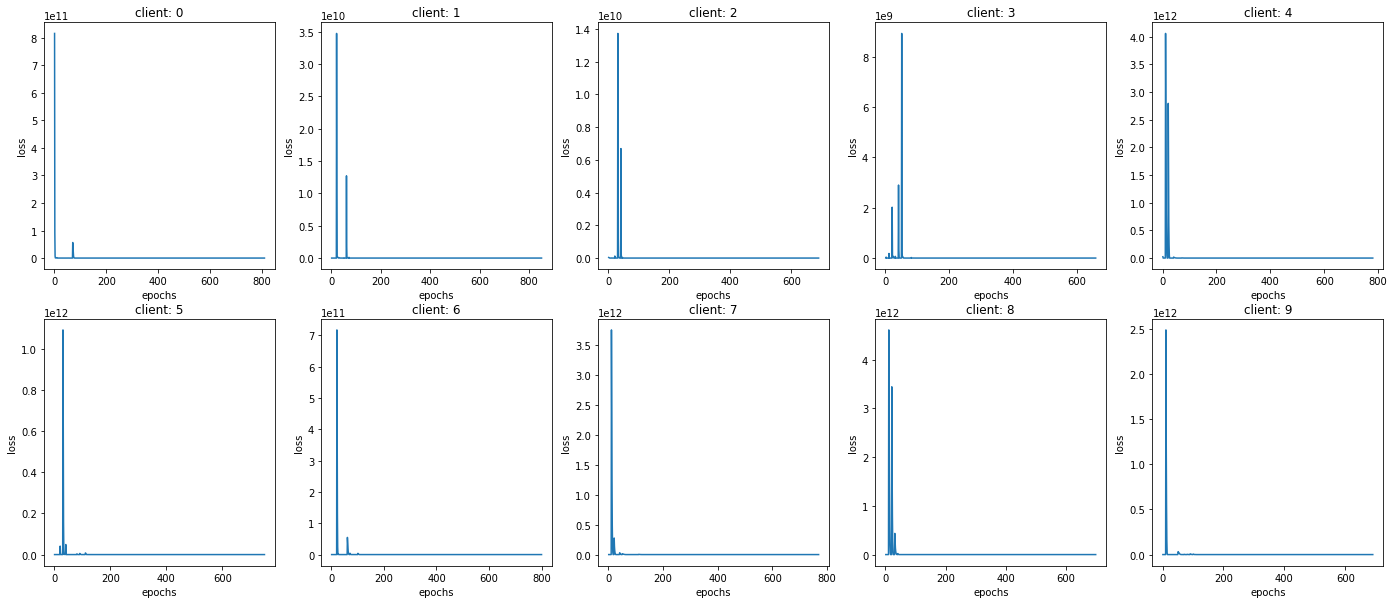

In [26]:
fig = plt.figure(figsize=(24, 10))
for i in range(n_clients):
    fig.add_subplot(2, int(n_clients/2), (i+1))
    X = global_trainer.client_trainer_set[i].loss_history
    Y = [i+1 for i in range(len(X))]
    plt.plot(Y, X)
    plt.title(f'client: {i}')
    plt.xlabel('epochs')
    plt.ylabel('loss')

In [27]:
global_test = GlobalPreprocess()

client_evaluator_set = [ClientEvaluator(i, global_model, client_test[i]) for i in range(n_clients)]
global_evaluator = GlobalEvaluator(global_model, global_test)

Files already downloaded and verified


In [28]:
avg_client_acc = 0
avg_client_loss = 0
avg_client_conf_mat = torch.zeros([10, 10])  
  
for i in range(n_clients):
    client_evaluator_set[i].test()
    avg_client_acc += client_evaluator_set[i].accuracy
    avg_client_loss += client_evaluator_set[i].loss
    print(type(client_evaluator_set[i].conf_mat), type(avg_client_conf_mat))
    avg_client_conf_mat = torch.add(avg_client_conf_mat, client_evaluator_set[i].conf_mat)
    
avg_client_acc /= n_clients
avg_client_loss /= n_clients
avg_client_conf_mat  = torch.div(avg_client_conf_mat, n_clients)
    

client [0]: 100%|██████████| 66/66 [00:01<00:00, 62.27it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [1]: 100%|██████████| 66/66 [00:00<00:00, 71.61it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [2]: 100%|██████████| 66/66 [00:00<00:00, 70.86it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [3]: 100%|██████████| 66/66 [00:00<00:00, 70.52it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [4]: 100%|██████████| 66/66 [00:00<00:00, 67.12it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [5]: 100%|██████████| 66/66 [00:01<00:00, 58.79it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [6]: 100%|██████████| 66/66 [00:00<00:00, 67.81it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [7]: 100%|██████████| 66/66 [00:01<00:00, 65.95it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [8]: 100%|██████████| 66/66 [00:01<00:00, 64.59it/s]


<class 'torch.Tensor'> <class 'torch.Tensor'>


client [9]: 100%|██████████| 35/35 [00:00<00:00, 52.81it/s]

<class 'torch.Tensor'> <class 'torch.Tensor'>


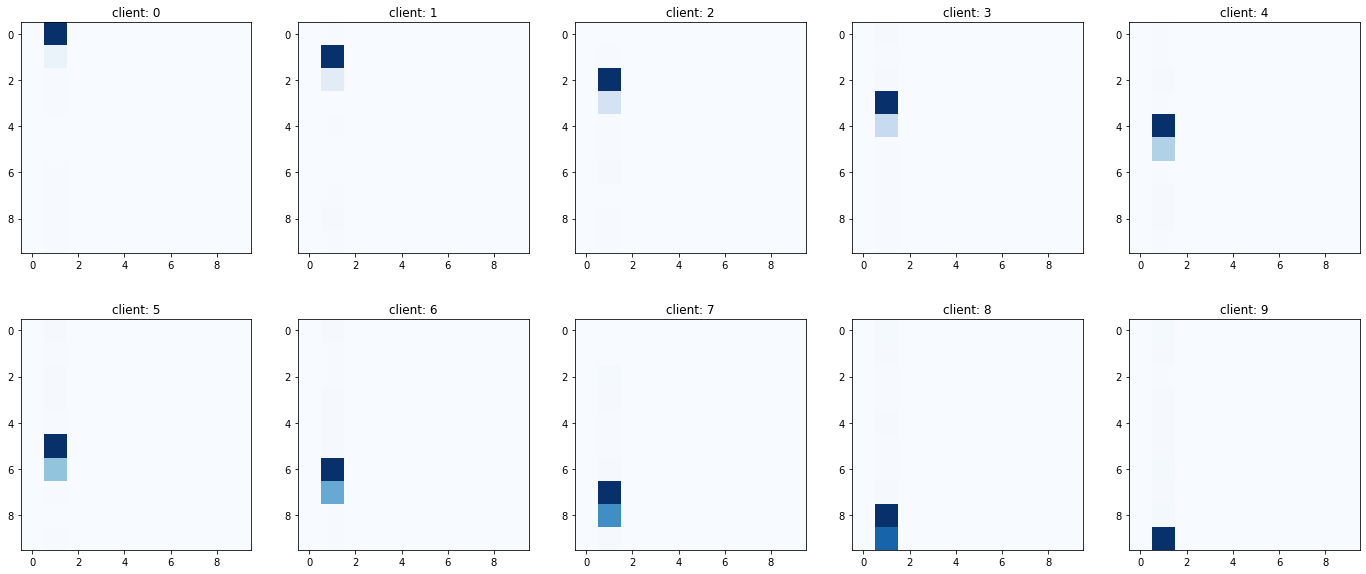

In [29]:
fig = plt.figure(figsize=(24, 10))
for i in range(n_clients):
    fig.add_subplot(2, int(n_clients/2), (i+1))
    plt.imshow(client_evaluator_set[i].conf_mat, cmap='Blues')
    plt.title(f'client: {i}')


<BarContainer object of 10 artists>

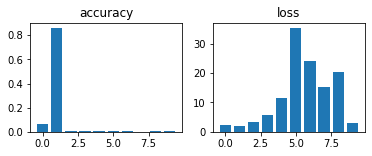

In [30]:
fig = plt.figure(figsize=(6, 2))
fig.add_subplot(1, 2, 1)
plt.bar([i for i in range(n_clients)], [client_evaluator_set[i].accuracy for i in range(n_clients)])
plt.title('accuracy')
fig.add_subplot(1, 2, 2)
plt.title('loss')   
plt.bar([i for i in range(n_clients)], [client_evaluator_set[i].loss for i in range(n_clients)])


In [31]:
global_evaluator.test()

global_evaluation: 100%|██████████| 157/157 [00:06<00:00, 22.53it/s]


Text(0.5, 1.0, 'clieint average')

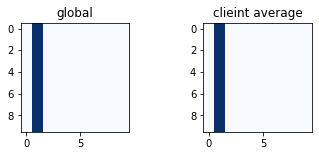

In [32]:
fig = plt.figure(figsize=(6, 2))
fig.add_subplot(1, 2, 1)
plt.imshow(global_evaluator.conf_mat, cmap='Blues')
plt.title('global')
fig.add_subplot(1, 2, 2)
plt.imshow(avg_client_conf_mat, cmap='Blues')
plt.title('clieint average')


In [33]:
print('Global Accuracy', global_evaluator.accuracy, '\tClient avg Accuracy', avg_client_acc)
print('Global Loss' , global_evaluator.loss, '\tClient avg Loss', avg_client_loss)

Global Accuracy 0.09982085987261147 	Client avg Accuracy 0.09560064935064935
Global Loss 12.729663523057866 	Client avg Loss 12.255824108245037
